# Fe-Ni-Ti-Al novel alloy customization

- Author (Original Code): Yao Xiling
- Reproduced by: Chen Lequn

- System requirement
    - Python 3
    - Pymoo 0.3.0
    
 This program builds the metamodels using the single equilibrium result of Fe-Ni-Ti-Al alloy

In [1]:
# ! pip install pymoo 0.3.0
# !pip uninstall pymoo

### Import necessary libraries

In [26]:
import pandas as pd
from pandas import DataFrame

# For data standardization (transformation of the data onto unit scale (mean=0 and variance=1), required in most machine learning)
from sklearn.preprocessing import StandardScaler
# For K means clustering on W(FCC_A1#1,CR)_max
from sklearn.cluster import KMeans
# For principal component analysis (PCA):
from sklearn.decomposition import PCA as sklearnPCA
import plotly.io as pio
# For K Nearest Neighbours (Regression):
from sklearn import neighbors
# For linear models (Regression):
from sklearn import linear_model
# For Polynomial regression model:
from sklearn.preprocessing import PolynomialFeatures
# For support vector regression:
from sklearn import svm
# For neural network regression:
from sklearn import neural_network
# For decision tree regression:
from sklearn import tree
# For ensemble methods:
from sklearn import ensemble
# For data standardization (transform the data so that they have a near-normally distribution with zero mean and unit variance)
from sklearn import preprocessing
from sklearn.utils import shuffle

from sklearn.model_selection import KFold
import seaborn as sns

# Use grid search with cross validation to select ML model parameters:
from sklearn.model_selection import train_test_split  # random split the data into "training data" and "testing data"
from sklearn.model_selection import GridSearchCV  # Exhaustive grid search with cross validation (CV)
from sklearn import metrics
# User imputation to handle missing data in T_Ni3Ti (Ni3Ti formation temperature)
from sklearn.impute import SimpleImputer

# For Parallel Coordinates Plot
import plotly.graph_objects as go

# For material design optimization:
from scipy.optimize import differential_evolution
from scipy.optimize import NonlinearConstraint, Bounds  # constraints in differential_evolution() (NOT used in this program yet)

# For multiobjective optimization using pymoo:
#import autograd.numpy as anp
import numpy as np
import pymoo
from pymoo.model.problem import Problem
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation, get_termination, get_decomposition
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.performance_indicator.hv import Hypervolume
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca 
import os

In [2]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images")
os.makedirs(IMAGE_PATH, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Get the raw data (Thermal-Calc results)

In [3]:
wt_Ni3Ti_list = []
wt_Laves_list = []
wt_FCC_list = []

T_Ni3Ti_list = []


for num in range (0,1815):
    resultFile = "Fe-Ni-Ti-Al_single_eq_results/single_eq_" + format(num+1) + ".txt"
    resultFile = open(resultFile, 'r')
    result = resultFile.read()  # result is a string

    #print(num+1)

    # Obtain the system mass in grams (N=1, 1 mole):
    # Remove all characters before 'Mass in grams'
    result_mass = result[result.find('Mass in grams'):]  # .find() returns the index in the string
    result_mass = result_mass.split(' ')  # a list of string
    # print(result_mass)
    system_mass = result_mass[4]  # system_mass is a string
    system_mass = system_mass.rstrip('\n')  # remove the trailing '\n'
    system_mass = float(system_mass)  # convert the string in exponential form (e.g., "12E-01") to float
    #print(system_mass)


    if 'NI3TI' in result:
        # Remove all characters before 'NI3TI'
        result_Ni3Ti = result[result.find('NI3TI'):]  # .find() returns the index in the string
        result_Ni3Ti = result_Ni3Ti.split(' ')  # a list of string
        wt_Ni3Ti = result_Ni3Ti[36]  # wt_Ni3Ti is a string
        wt_Ni3Ti = wt_Ni3Ti.rstrip(',')  # remove the trailing ','
        wt_Ni3Ti = float(wt_Ni3Ti) / system_mass * 100.0 # convert the string in exponential form (e.g., "12E-01") to float
        #print('Ni3Ti = ' + format(wt_Ni3Ti))
        wt_Ni3Ti_list.append(wt_Ni3Ti)
    else:
        wt_Ni3Ti_list.append(0.0)

    if 'LAVES_PHASE_C14' in result:
        # Remove all characters before 'LAVES_PHASE_C14'
        result_Laves = result[result.find('LAVES_PHASE_C14'):]  # .find() returns the index in the string
        result_Laves = result_Laves.split(' ')  # a list of string
        wt_Laves = result_Laves[26]  # wt_Laves is a string
        wt_Laves = wt_Laves.rstrip(',')  # remove the trailing ','
        wt_Laves = float(wt_Laves) / system_mass * 100.0  # convert the string in exponential form (e.g., "12E-01") to float
        #print('Laves = ' + format(wt_Laves))
        wt_Laves_list.append(wt_Laves)
    else:
        wt_Laves_list.append(0.0)

    if 'FCC_A1' in result:
        # Remove all characters before 'FCC_A1'
        result_FCC = result[result.find('FCC_A1'):]  # .find() returns the index in the string
        result_FCC = result_FCC.split(' ')  # a list of string
        if 'FCC_A1#1' in result:
            wt_FCC = result_FCC[33]  # wt_FCC is a string
        else:  # 'FCC_A1' only, without '#1'
            wt_FCC = result_FCC[35]  # wt_FCC is a string
        wt_FCC = wt_FCC.rstrip(',')  # remove the trailing ','
        wt_FCC = float(wt_FCC) / system_mass * 100.0  # convert the string in exponential form (e.g., "12E-01") to float
        #print('FCC = ' + format(wt_FCC))
        wt_FCC_list.append(wt_FCC)
    else:
        wt_FCC_list.append(0.0)
        
        
    #----------------------------------------------------------------------------------------
    # The T vs Phases property diagram Excel ".xls" files:
    propertyDiagramFile = "Fe-Ni-Ti-Al_property_diagram_results/property_diagram_" + format(num+1) + ".xls"

    Ni3Ti_property_diagram = []  # list of all Ni3Ti data in the excel file
    T_property_diagram = []  # list of all temperature data in the excel file

    # Read the .xls file as text:
    lines = [line.rstrip('\n') for line in open(propertyDiagramFile)]  # "lines" is a list of strings. Each string is a row
    for i, row in enumerate(lines):
        if i == 0:
            continue  # i.e. the 1st row has only the strings "T BPW(LIQUID) BPW(BCC_A2) ...", skip the 1st row
        row = row.split('\t')  # adjacent columns have a "tab" in between. "row" is now a list of strings ['xx', 'xx', ...]
        T_property_diagram.append(float(row[0]))
        Ni3Ti_property_diagram.append(float(row[5]))

    Ni3Ti_property_diagram_new = [x for x in Ni3Ti_property_diagram if float(x) > 0.01]  # remove all values less than 0.01 (1wt%) Ni3Ti

    if not Ni3Ti_property_diagram_new:  # if the list is empty, i.e., no Ni3Ti formation (or less than 0.01, 1wt%)
        T_Ni3Ti_list.append(np.nan)  # a missing value

    else:
        # Get the temperature when Ni3Ti starts to form (i.e., the temperature at minimum Ni3Ti)
        T_Ni3Ti = T_property_diagram[ Ni3Ti_property_diagram.index( min(Ni3Ti_property_diagram_new) ) ]
        T_Ni3Ti_list.append(T_Ni3Ti)

In [4]:
# Upper and lower bounds used in plotting
Ni3Ti_upper = max(wt_Ni3Ti_list)
Ni3Ti_lower = min(wt_Ni3Ti_list)
Laves_upper = max(wt_Laves_list)
Laves_lower = min(wt_Laves_list)
FCC_upper = max(wt_FCC_list)
FCC_lower = min(wt_FCC_list)
T_Ni3Ti_upper = max(T_Ni3Ti_list)
T_Ni3Ti_lower = min(T_Ni3Ti_list)

### Create pandas dataframe (skip this)
- All the the results are already stored into csv files
- single_eq_Ni3Ti_metamodel folder
- single_eq_Laves_metamodel
- single_eq_FCC_metamodel
- property_diagram_T_Ni3Ti_metamodel/ T_Ni3Ti_vs_composition
- All_data

### Retrieve pandas dataframe from the csv file

In [189]:
df_All = pd.read_csv('All_data.csv')
df_T_Ni3Ti = pd.read_csv('property_diagram_T_Ni3Ti_metamodel/T_Ni3Ti_vs_composition.csv')
df_FCC = pd.read_csv("single_eq_FCC_metamodel/FCC_vs_composition.csv")
df_Laves = pd.read_csv("single_eq_Laves_metamodel/Laves_vs_composition.csv")
df_Ni3Ti = pd.read_csv("single_eq_Ni3Ti_metamodel/Ni3Ti_vs_composition.csv")
df_Ni3Ti_Laves_FCC = pd.read_csv("Ni3Ti_Laves_FCC_vs_composition.csv")

### Inspect the dataframes

In [6]:
df_All.head()

Ni   Ti   Al     Ni3Ti  Laves        FCC   T_Ni3Ti
0  15.0  1.0  0.0  4.677395    0.0  18.713854  894.8367
1  16.0  1.0  0.0  4.677250    0.0  20.384773  894.8367
2  17.0  1.0  0.0  4.677283    0.0  22.057620  894.8367
3  18.0  1.0  0.0  4.677316    0.0  23.728838  904.1500
4  19.0  1.0  0.0  4.677340    0.0  25.400160  914.1500

In [7]:
df_Laves

Ni    Ti    Al      Laves
0     15.0   1.0   0.0   0.000000
1     16.0   1.0   0.0   0.000000
2     17.0   1.0   0.0   0.000000
3     18.0   1.0   0.0   0.000000
4     19.0   1.0   0.0   0.000000
...    ...   ...   ...        ...
1810  21.0  15.0  10.0  37.445089
1811  22.0  15.0  10.0  37.196023
1812  23.0  15.0  10.0  36.921008
1813  24.0  15.0  10.0  36.596154
1814  25.0  15.0  10.0  36.277523

[1815 rows x 4 columns]

## Data preparation for Machine Learning Metamodel (regression)

In [8]:
# Feature selection - select the variables that has strong contribution to the output
# Reference:  https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
# Reference:  https://scikit-learn.org/stable/modules/feature_selection.html
# Method: Correlation matrix shown in Heatmap

#correlation_matrix = df_All.corr(method='spearman')  # 'spearman' for monotonic correlation, 'pearson' for linear correlation
#print(correlation_matrix)
## Use a Heatmap to visualize the correlation matrix:
#fig = go.Figure(data=go.Heatmap(z=correlation_matrix,
                                #x=["Ni", "Ti", "Al", "Ni3Ti", "Laves", "FCC", "T_Ni3Ti"],
                                #y=["Ni", "Ti", "Al", "Ni3Ti", "Laves", "FCC", "T_Ni3Ti"]))
## Use the offline mode of plotly:
#pio.write_html(fig, file="Correlation matrix (all data) (spearman).html", auto_open=True)

### correlation matrix

In [191]:
df_All_selected = df_Ni3Ti_Laves_FCC[["Ni", "Ti", "Al", "Ni3Ti", "Laves"]]

Saving figure correlation_heatmap


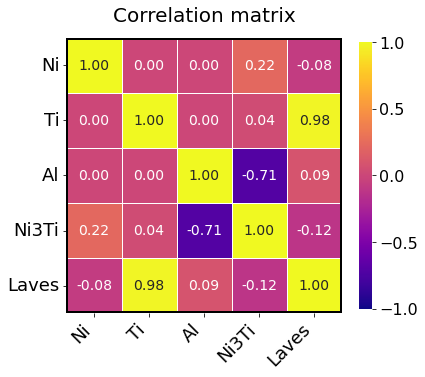

In [194]:
corr = df_All_selected.corr(method='spearman')
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
# sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
# sns.set(font_scale=1.2)
sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    # cmap=sns.diverging_palette(20, 220, n=200),
    cmap="plasma", #plasma, inferno,gnuplot, spring  https://matplotlib.org/2.0.2/users/colormaps.html
    square=True,
    ax=ax,
    annot=True,
    annot_kws={"size":14},
    cbar_kws={"shrink": .7,
             "ticks": [-1,-0.5, 0,0.5, 1]},
    fmt='.2f',
    linewidths=0.8, linecolor='white'
)

##---------set color bar text font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 18,
)

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    # horizontalalignment='right',
    fontsize = 18
)

ax.set_title("Correlation matrix", fontsize = 20, pad = 16)

ax.axhline(y=0, color='k',linewidth=4)
ax.axhline(y=corr.shape[1], color='k',linewidth=4)
ax.axvline(x=0, color='k',linewidth=4)
ax.axvline(x=corr.shape[0], color='k',linewidth=4)

save_fig('correlation_heatmap')

### Split data into Features X and Lable Y

In [9]:
X_Ni3Ti = df_Ni3Ti.iloc[:,0:3].values  # alloy composition
Y_Ni3Ti = df_Ni3Ti.iloc[:,3].values    # Ni3Ti weight percent
X_Laves = df_Laves.iloc[:,0:3].values  # alloy composition
Y_Laves = df_Laves.iloc[:,3].values    # Laves weight percent
X_FCC = df_FCC.iloc[:,0:3].values  # alloy composition
Y_FCC = df_FCC.iloc[:,3].values    # FCC weight percent

X_T_Ni3Ti = df_T_Ni3Ti.iloc[:,0:3].values  # alloy composition
Y_T_Ni3Ti = df_T_Ni3Ti.iloc[:,3].values    # Ni3Ti formation temperature

### Train test split

In [10]:
X_Ni3Ti_train, X_Ni3Ti_test, Y_Ni3Ti_train, Y_Ni3Ti_test = train_test_split(X_Ni3Ti, Y_Ni3Ti, test_size=0.3, random_state=0, shuffle=True)
X_Laves_train, X_Laves_test, Y_Laves_train, Y_Laves_test = train_test_split(X_Laves, Y_Laves, test_size=0.3, random_state=0, shuffle=True)
X_FCC_train, X_FCC_test, Y_FCC_train, Y_FCC_test = train_test_split(X_FCC, Y_FCC, test_size=0.3, random_state=0, shuffle=True)
X_T_Ni3Ti_train, X_T_Ni3Ti_test, Y_T_Ni3Ti_train, Y_T_Ni3Ti_test = train_test_split(X_T_Ni3Ti, Y_T_Ni3Ti, test_size=0.3, random_state=0, shuffle=True)

### Data standarization

In [11]:
scaler = preprocessing.StandardScaler().fit(X_Ni3Ti)  # X_Ni3Ti == X_Laves == X_FCC == X_T_Ni3Ti == [Ni_list, Ti_list, Al_list]

#scaler = preprocessing.StandardScaler().fit(X_Ni3Ti_train)
X_Ni3Ti_train_transformed = scaler.transform(X_Ni3Ti_train)
X_Ni3Ti_test_transformed = scaler.transform(X_Ni3Ti_test)

#scaler = preprocessing.StandardScaler().fit(X_Laves_train)
X_Laves_train_transformed = scaler.transform(X_Laves_train)
X_Laves_test_transformed = scaler.transform(X_Laves_test)

#scaler = preprocessing.StandardScaler().fit(X_FCC_train)
X_FCC_train_transformed = scaler.transform(X_FCC_train)
X_FCC_test_transformed = scaler.transform(X_FCC_test)

#scaler = preprocessing.StandardScaler().fit(X_T_Ni3Ti_train)
X_T_Ni3Ti_train_transformed = scaler.transform(X_T_Ni3Ti_train)
X_T_Ni3Ti_test_transformed = scaler.transform(X_T_Ni3Ti_test)

## ML training, with hyperparameter optimization, cross-validation

#### Ni3Ti

In [12]:
# poly = PolynomialFeatures(degree=2)
# X_Ni3Ti_train_transformed = poly.fit_transform(X_Ni3Ti_train_transformed)
# X_Ni3Ti_test_transformed = poly.fit_transform(X_Ni3Ti_test_transformed)
# metamodel_Ni3Ti = linear_model.LinearRegression()

tuned_parameters = {'n_neighbors': [3, 4, 5, 6, 7, 8, 9],
                    'weights': ['uniform', 'distance']}    # a dict (dictionary)
score = "r2" #"neg_mean_squared_error"
metamodel_Ni3Ti_KNN = GridSearchCV(neighbors.KNeighborsRegressor(), tuned_parameters, scoring=score, cv=4)

# tuned_parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#                     'degree': [2, 3, 4],
#                     'gamma': ['scale', 'auto']}    # a dict (dictionary)
# score = "r2" #"neg_mean_squared_error"
# metamodel_Ni3Ti = GridSearchCV(svm.SVR(), tuned_parameters, scoring=score, cv=4)

tuned_parameters = {'max_depth': [2,3,4,5,6]}    # a dict (dictionary)
score = "r2" #"neg_mean_squared_error"
metamodel_Ni3Ti_DT = GridSearchCV(tree.DecisionTreeRegressor(), tuned_parameters, scoring=score, cv=4)

tuned_parameters = {'n_estimators': [100,200,300,400]}    # a dict (dictionary)
score = "r2" #"neg_mean_squared_error"
metamodel_Ni3Ti_AdaBoost = GridSearchCV(ensemble.AdaBoostRegressor(), tuned_parameters, scoring=score, cv=4)

# RandomForestRegressor is has highest R2 score for Ni3Ti metamodel
tuned_parameters = {'max_depth': [10,30,60,90,100]}    # a dict (dictionary)
score = "r2" #"neg_mean_squared_error"
metamodel_Ni3Ti_RF = GridSearchCV(ensemble.RandomForestRegressor(), tuned_parameters, scoring=score, cv=4)

#### Laves

In [13]:
#poly = PolynomialFeatures(degree=2)
#X_Laves_train_transformed = poly.fit_transform(X_Laves_train_transformed)
#X_Laves_test_transformed = poly.fit_transform(X_Laves_test_transformed)
#metamodel_Laves = linear_model.LinearRegression()

# KNeighborsRegressor can result in zero Laves in optimized composition, although the metamodel does not have the highest R2 score
tuned_parameters = {'n_neighbors': [3, 4, 5, 6, 7, 8, 9],
                    'weights': ['uniform', 'distance']}    # a dict (dictionary)
score = "r2" #"neg_mean_squared_error"
metamodel_Laves_KNN = GridSearchCV(neighbors.KNeighborsRegressor(), tuned_parameters, scoring=score, cv=4)

# tuned_parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#                     'degree': [2, 3, 4],
#                     'gamma': ['scale', 'auto']}    # a dict (dictionary)
# score = "r2" #"neg_mean_squared_error"
# metamodel_Laves = GridSearchCV(svm.SVR(), tuned_parameters, scoring=score, cv=4)

tuned_parameters = {'max_depth': [2,3,4,5,6]}    # a dict (dictionary)
score = "r2" #"neg_mean_squared_error"
metamodel_Laves_DT = GridSearchCV(tree.DecisionTreeRegressor(), tuned_parameters, scoring=score, cv=4)

tuned_parameters = {'n_estimators': [100,200,300,400]}    # a dict (dictionary)
score = "r2" #"neg_mean_squared_error"
metamodel_Laves_AdaBoost = GridSearchCV(ensemble.AdaBoostRegressor(), tuned_parameters, scoring=score, cv=4)

# RandomForestRegressor is has highest R2 score for Laves metamodel
tuned_parameters = {'max_depth': [10,30,60,90,100]}    # a dict (dictionary)
score = "r2" #"neg_mean_squared_error"
metamodel_Laves_RF = GridSearchCV(ensemble.RandomForestRegressor(), tuned_parameters, scoring=score, cv=4)

#### FCC

In [14]:
#poly = PolynomialFeatures(degree=2)
#X_FCC_train_transformed = poly.fit_transform(X_FCC_train_transformed)
#X_FCC_test_transformed = poly.fit_transform(X_FCC_test_transformed)
#metamodel_FCC = linear_model.LinearRegression()

tuned_parameters = {'n_neighbors': [3, 4, 5, 6, 7, 8, 9],
                    'weights': ['uniform', 'distance']}    # a dict (dictionary)
score = "r2" #"neg_mean_squared_error"
metamodel_FCC_KNN = GridSearchCV(neighbors.KNeighborsRegressor(), tuned_parameters, scoring=score, cv=4)

# tuned_parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#                     'degree': [2, 3, 4],
#                     'gamma': ['scale', 'auto']}    # a dict (dictionary)
# score = "r2" #"neg_mean_squared_error"
# metamodel_FCC = GridSearchCV(svm.SVR(), tuned_parameters, scoring=score, cv=4)

tuned_parameters = {'max_depth': [2,3,4,5,6]}    # a dict (dictionary)
score = "r2" #"neg_mean_squared_error"
metamodel_FCC_DT = GridSearchCV(tree.DecisionTreeRegressor(), tuned_parameters, scoring=score, cv=4)

tuned_parameters = {'n_estimators': [100,200,300,400]}    # a dict (dictionary)
score = "r2" #"neg_mean_squared_error"
metamodel_FCC_AdaBoost = GridSearchCV(ensemble.AdaBoostRegressor(), tuned_parameters, scoring=score, cv=4)

# RandomForestRegressor is has highest R2 score for FCC metamodel
tuned_parameters = {'max_depth': [10,30,60,90,100]}    # a dict (dictionary)
score = "r2" #"neg_mean_squared_error"
metamodel_FCC_RF = GridSearchCV(ensemble.RandomForestRegressor(), tuned_parameters, scoring=score, cv=4)

#### T_Ni3Ti, formation temperature of Ni3Ti

In [15]:
#poly = PolynomialFeatures(degree=2)
#X_T_Ni3Ti_train_transformed = poly.fit_transform(X_T_Ni3Ti_train_transformed)
#X_T_Ni3Ti_test_transformed = poly.fit_transform(X_T_Ni3Ti_test_transformed)
#metamodel_T_Ni3Ti = linear_model.LinearRegression()

tuned_parameters = {'n_neighbors': [3, 4, 5, 6, 7, 8, 9],
                    'weights': ['uniform', 'distance']}    # a dict (dictionary)
score = "r2" #"neg_mean_squared_error"
metamodel_T_Ni3Ti_KNN = GridSearchCV(neighbors.KNeighborsRegressor(), tuned_parameters, scoring=score, cv=4)

# tuned_parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#                     'degree': [2, 3, 4],
#                     'gamma': ['scale', 'auto']}    # a dict (dictionary)
# score = "r2" #"neg_mean_squared_error"
# metamodel_T_Ni3Ti = GridSearchCV(svm.SVR(), tuned_parameters, scoring=score, cv=4)

tuned_parameters = {'max_depth': [2,3,4,5,6]}    # a dict (dictionary)
score = "r2" #"neg_mean_squared_error"
metamodel_T_Ni3Ti_DT = GridSearchCV(tree.DecisionTreeRegressor(), tuned_parameters, scoring=score, cv=4)

tuned_parameters = {'n_estimators': [100,200,300,400]}    # a dict (dictionary)
score = "r2" #"neg_mean_squared_error"
metamodel_T_Ni3Ti_AdaBoost = GridSearchCV(ensemble.AdaBoostRegressor(), tuned_parameters, scoring=score, cv=4)

# RandomForestRegressor has highest R2 score for FCC metamodel
tuned_parameters = {'max_depth': [10,30,60,90,100]}    # a dict (dictionary)
score = "r2" #"neg_mean_squared_error"
metamodel_T_Ni3Ti_RF = GridSearchCV(ensemble.RandomForestRegressor(), tuned_parameters, scoring=score, cv=4)

### Fit the regression models

In [16]:
metamodel_Ni3Ti_RF.fit(X_Ni3Ti_train_transformed, Y_Ni3Ti_train)
metamodel_Laves_RF.fit(X_Laves_train_transformed, Y_Laves_train)
metamodel_FCC_RF.fit(X_FCC_train_transformed, Y_FCC_train)
metamodel_T_Ni3Ti_RF.fit(X_T_Ni3Ti_train_transformed, Y_T_Ni3Ti_train)

GridSearchCV(cv=4, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 30, 60, 90, 100]}, scoring='r2')

In [17]:
metamodel_Ni3Ti_DT.fit(X_Ni3Ti_train_transformed, Y_Ni3Ti_train)
metamodel_Laves_DT.fit(X_Laves_train_transformed, Y_Laves_train)
metamodel_FCC_DT.fit(X_FCC_train_transformed, Y_FCC_train)
metamodel_T_Ni3Ti_DT.fit(X_T_Ni3Ti_train_transformed, Y_T_Ni3Ti_train)

GridSearchCV(cv=4, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 3, 4, 5, 6]}, scoring='r2')

In [18]:
metamodel_Ni3Ti_KNN.fit(X_Ni3Ti_train_transformed, Y_Ni3Ti_train)
metamodel_Laves_KNN.fit(X_Laves_train_transformed, Y_Laves_train)
metamodel_FCC_KNN.fit(X_FCC_train_transformed, Y_FCC_train)
metamodel_T_Ni3Ti_KNN.fit(X_T_Ni3Ti_train_transformed, Y_T_Ni3Ti_train)

GridSearchCV(cv=4, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [3, 4, 5, 6, 7, 8, 9],
                         'weights': ['uniform', 'distance']},
             scoring='r2')

In [19]:
metamodel_Ni3Ti_AdaBoost.fit(X_Ni3Ti_train_transformed, Y_Ni3Ti_train)
metamodel_Laves_AdaBoost.fit(X_Laves_train_transformed, Y_Laves_train)
metamodel_FCC_AdaBoost.fit(X_FCC_train_transformed, Y_FCC_train)
metamodel_T_Ni3Ti_AdaBoost.fit(X_T_Ni3Ti_train_transformed, Y_T_Ni3Ti_train)

GridSearchCV(cv=4, estimator=AdaBoostRegressor(),
             param_grid={'n_estimators': [100, 200, 300, 400]}, scoring='r2')

## Best hyperparameters of each models

In [20]:
print("\nBest parameters set found on development set:")
print(metamodel_Ni3Ti_KNN.best_params_)
print("\nBest parameters set found on development set:")
print(metamodel_Laves_KNN.best_params_)
print("\nBest parameters set found on development set:")
print(metamodel_FCC_KNN.best_params_)
print("\nBest parameters set found on development set:")
print(metamodel_T_Ni3Ti_KNN.best_params_)


Best parameters set found on development set:
{'n_neighbors': 6, 'weights': 'distance'}

Best parameters set found on development set:
{'n_neighbors': 8, 'weights': 'distance'}

Best parameters set found on development set:
{'n_neighbors': 5, 'weights': 'distance'}

Best parameters set found on development set:
{'n_neighbors': 3, 'weights': 'distance'}


In [21]:
print("\nBest parameters set found on development set:")
print(metamodel_Ni3Ti_DT.best_params_)
print("\nBest parameters set found on development set:")
print(metamodel_Laves_DT.best_params_)
print("\nBest parameters set found on development set:")
print(metamodel_FCC_DT.best_params_)
print("\nBest parameters set found on development set:")
print(metamodel_T_Ni3Ti_DT.best_params_)


Best parameters set found on development set:
{'max_depth': 6}

Best parameters set found on development set:
{'max_depth': 6}

Best parameters set found on development set:
{'max_depth': 6}

Best parameters set found on development set:
{'max_depth': 6}


In [22]:
print("\nBest parameters set found on development set:")
print(metamodel_Ni3Ti_AdaBoost.best_params_)
print("\nBest parameters set found on development set:")
print(metamodel_Laves_AdaBoost.best_params_)
print("\nBest parameters set found on development set:")
print(metamodel_FCC_AdaBoost.best_params_)
print("\nBest parameters set found on development set:")
print(metamodel_T_Ni3Ti_AdaBoost.best_params_)


Best parameters set found on development set:
{'n_estimators': 300}

Best parameters set found on development set:
{'n_estimators': 400}

Best parameters set found on development set:
{'n_estimators': 100}

Best parameters set found on development set:
{'n_estimators': 300}


In [23]:
print("\nBest parameters set found on development set:")
print(metamodel_Ni3Ti_RF.best_params_)
print("\nBest parameters set found on development set:")
print(metamodel_Laves_RF.best_params_)
print("\nBest parameters set found on development set:")
print(metamodel_FCC_RF.best_params_)
print("\nBest parameters set found on development set:")
print(metamodel_T_Ni3Ti_RF.best_params_)


Best parameters set found on development set:
{'max_depth': 60}

Best parameters set found on development set:
{'max_depth': 100}

Best parameters set found on development set:
{'max_depth': 60}

Best parameters set found on development set:
{'max_depth': 90}


### Testing (cross-validation)

In [24]:
# Y_Ni3Ti_predict = metamodel_Ni3Ti.predict(X_Ni3Ti_test_transformed)
# Y_Laves_predict = metamodel_Laves.predict(X_Laves_test_transformed)
# Y_FCC_predict = metamodel_FCC.predict(X_FCC_test_transformed)
# Y_T_Ni3Ti_predict = metamodel_T_Ni3Ti.predict(X_T_Ni3Ti_test_transformed)


# print("\nMean squared error of the metamodel on Ni3Ti weight percent:")
# print(metrics.mean_squared_error(Y_Ni3Ti_test, Y_Ni3Ti_predict))

# print("\nMean squared error of the metamodel on Laves weight percent:")
# print(metrics.mean_squared_error(Y_Laves_test, Y_Laves_predict))

# print("\nMean squared error of the metamodel on FCC weight percent:")
# print(metrics.mean_squared_error(Y_FCC_test, Y_FCC_predict))


# print("\nR^2 of the metamodel on Ni3Ti weight percent:")
# print(metrics.r2_score(Y_Ni3Ti_test, Y_Ni3Ti_predict))

# print("\nR^2 of the metamodel on Laves weight percent:")
# print(metrics.r2_score(Y_Laves_test, Y_Laves_predict))

# print("\nR^2 of the metamodel on FCC weight percent:")
# print(metrics.r2_score(Y_FCC_test, Y_FCC_predict))

# print("\nR^2 of the metamodel on Ni3Ti formation temperature:")
# print(metrics.r2_score(Y_T_Ni3Ti_test, Y_T_Ni3Ti_predict))

### metamodel_Ni3Ti

In [131]:
# fit_models = []
Ni3Ti_train_accuracy = []
Ni3Ti_train_accuracy_std = []
Ni3Ti_test_accuracy = []
Ni3Ti_test_accuracy_std = []
Ni3Ti_train_mae=[]
Ni3Ti_train_mae_std=[]
Ni3Ti_test_mae=[]
Ni3Ti_test_mae_std=[]

Saving figure Ni3Ti precipitateKNN_test_.png


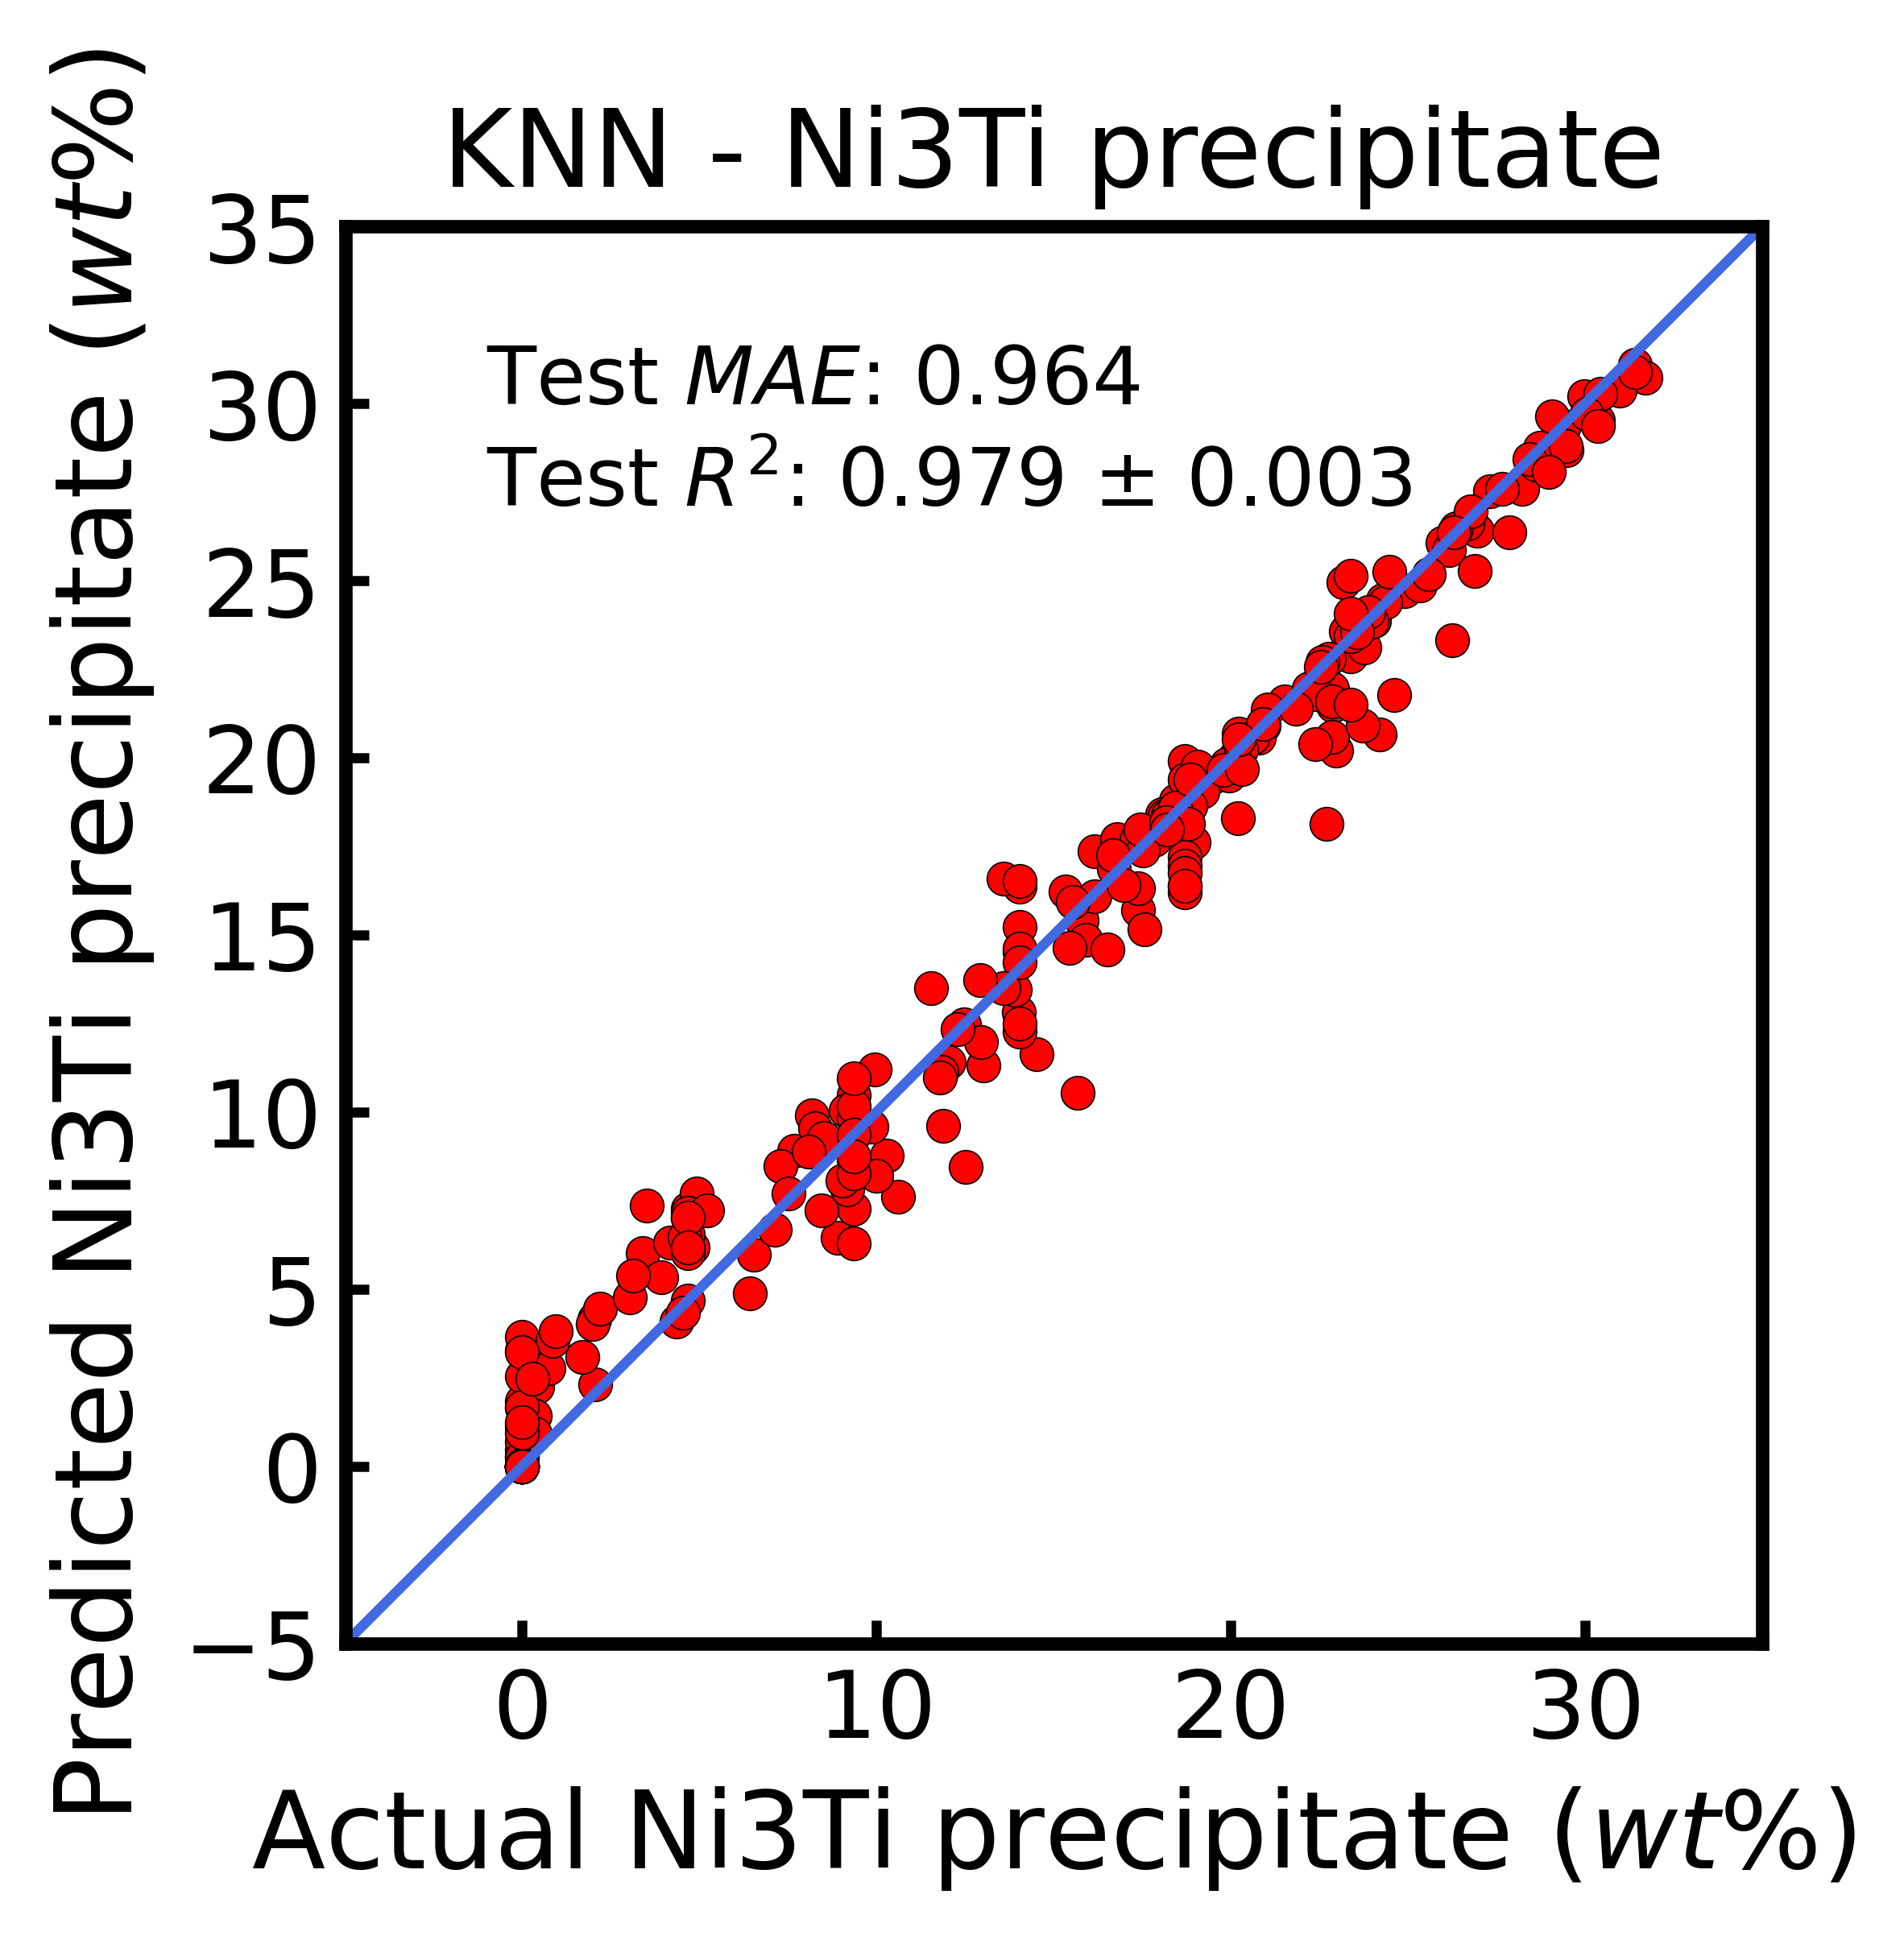

Saving figure Ni3Ti precipitateAdaBoost_test_.png


<Figure size 432x288 with 0 Axes>

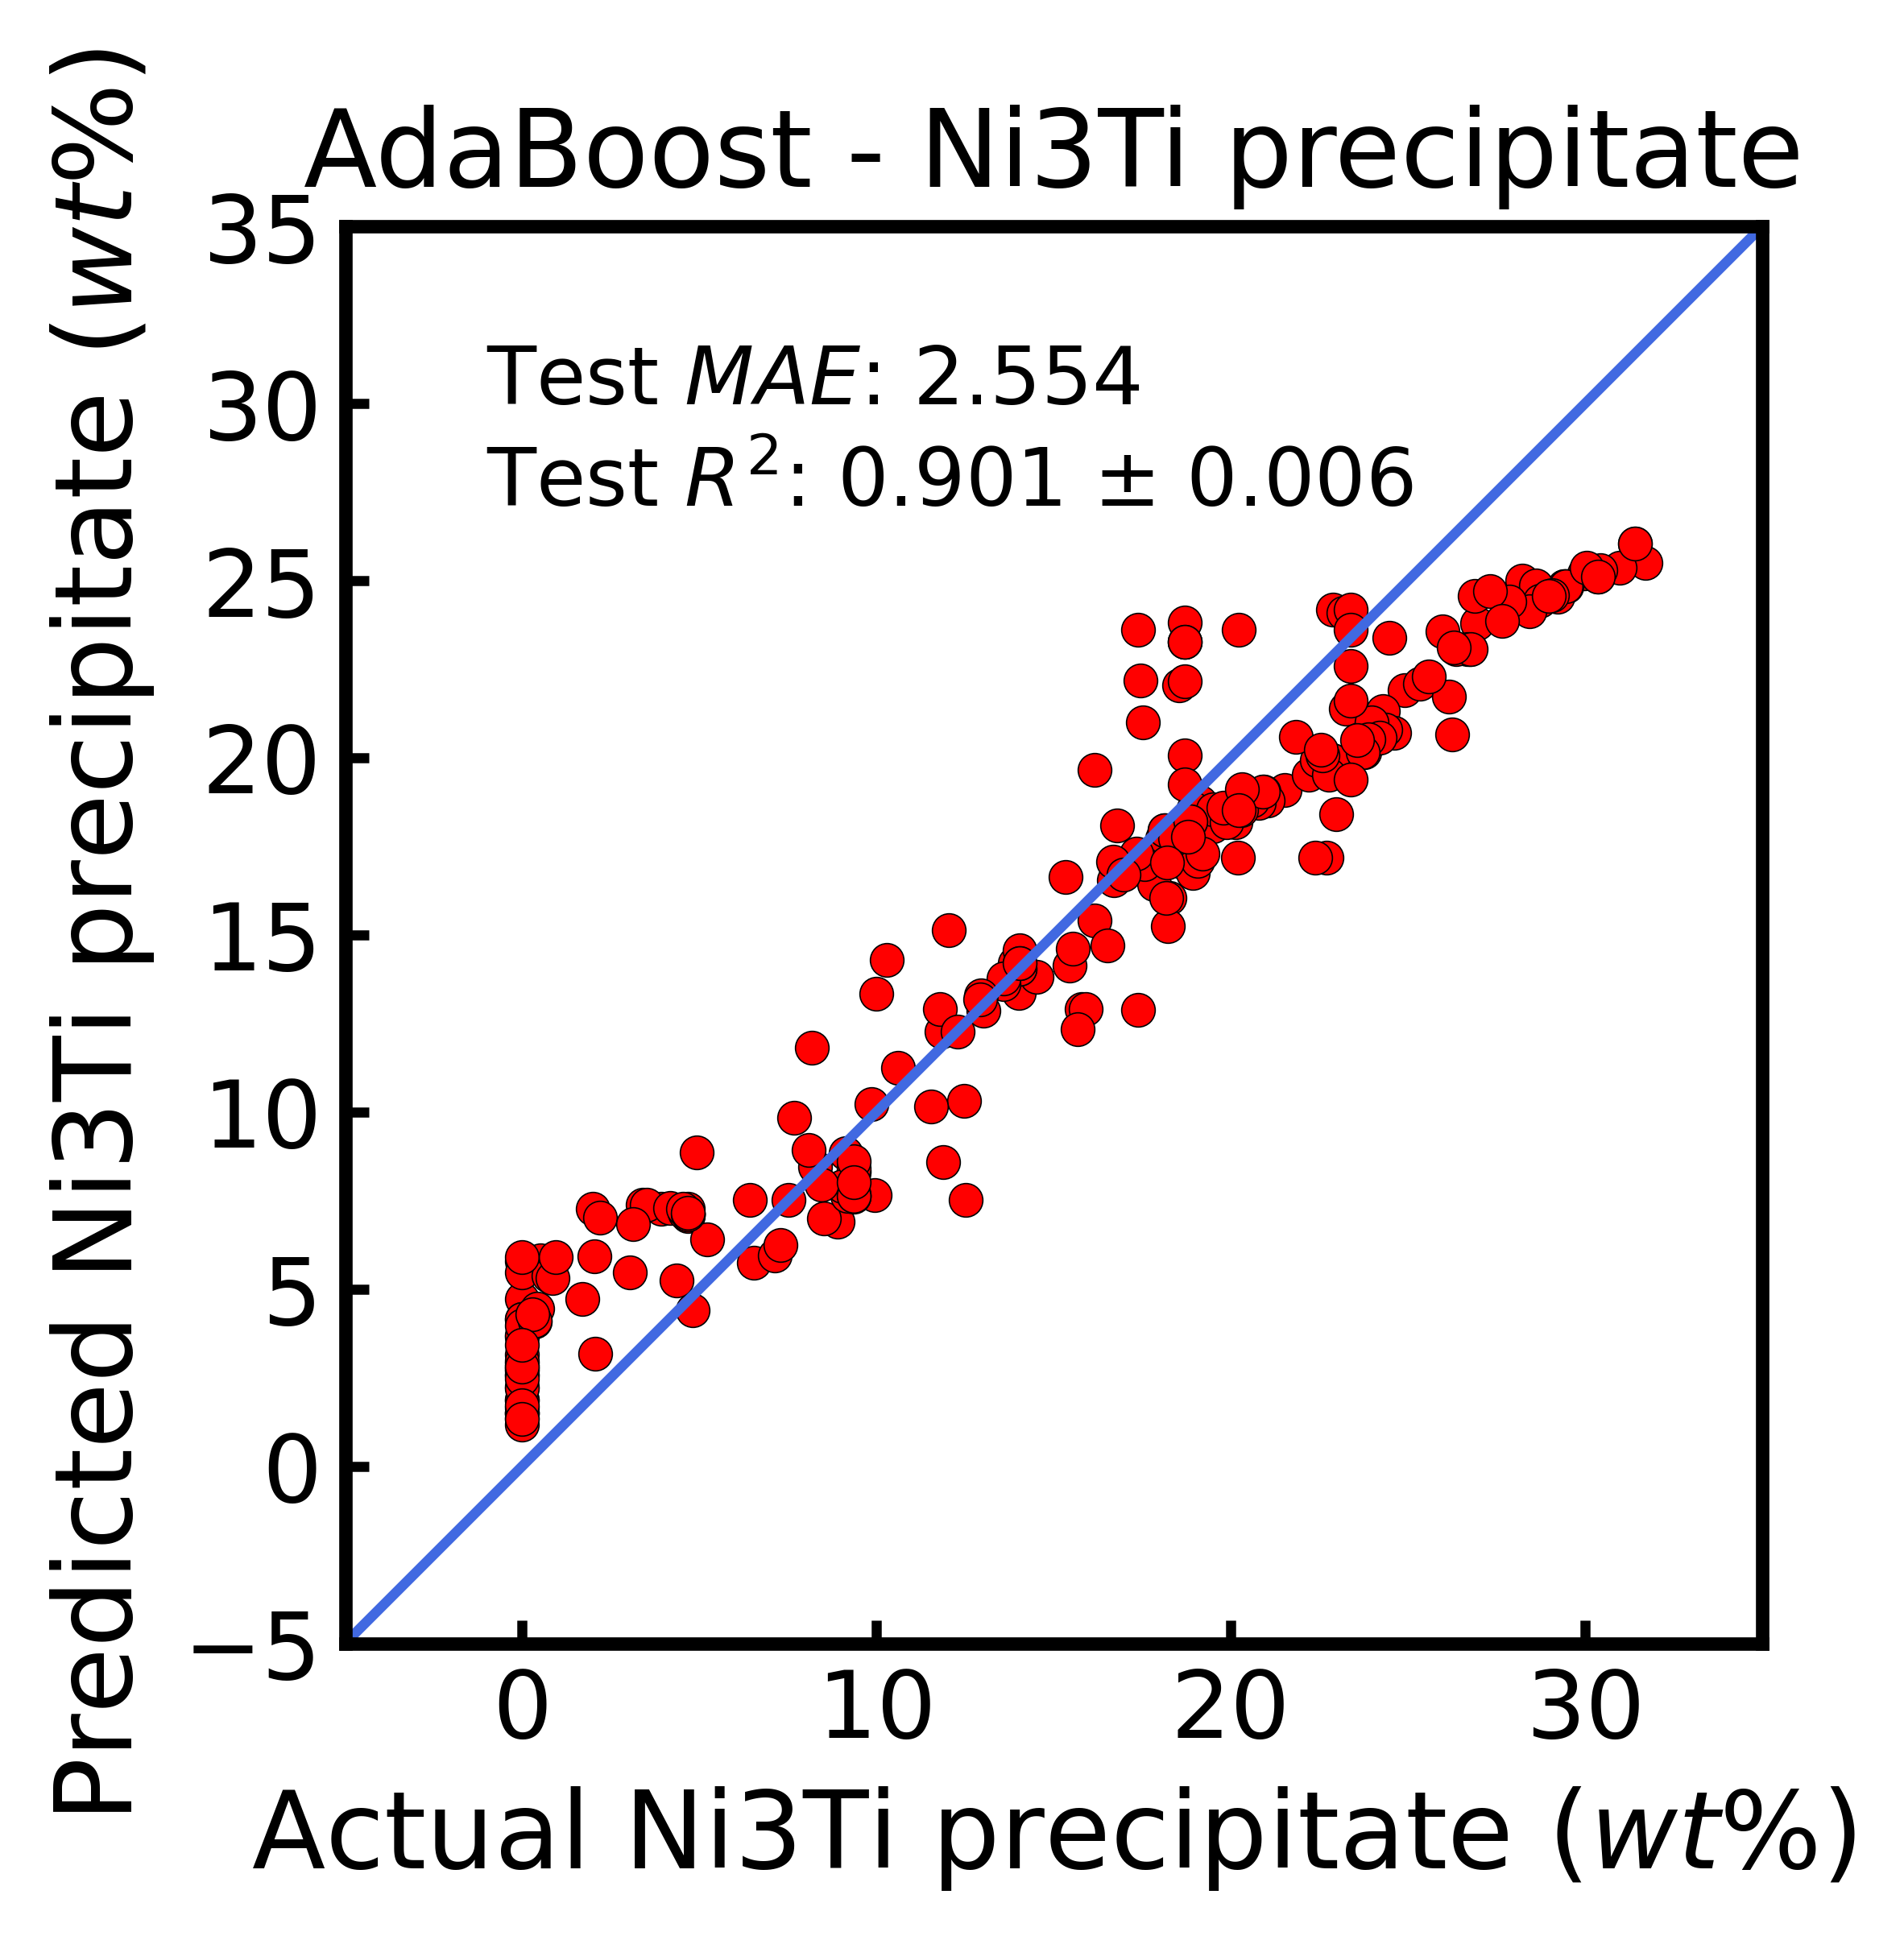

Saving figure Ni3Ti precipitateDT_test_.png


<Figure size 432x288 with 0 Axes>

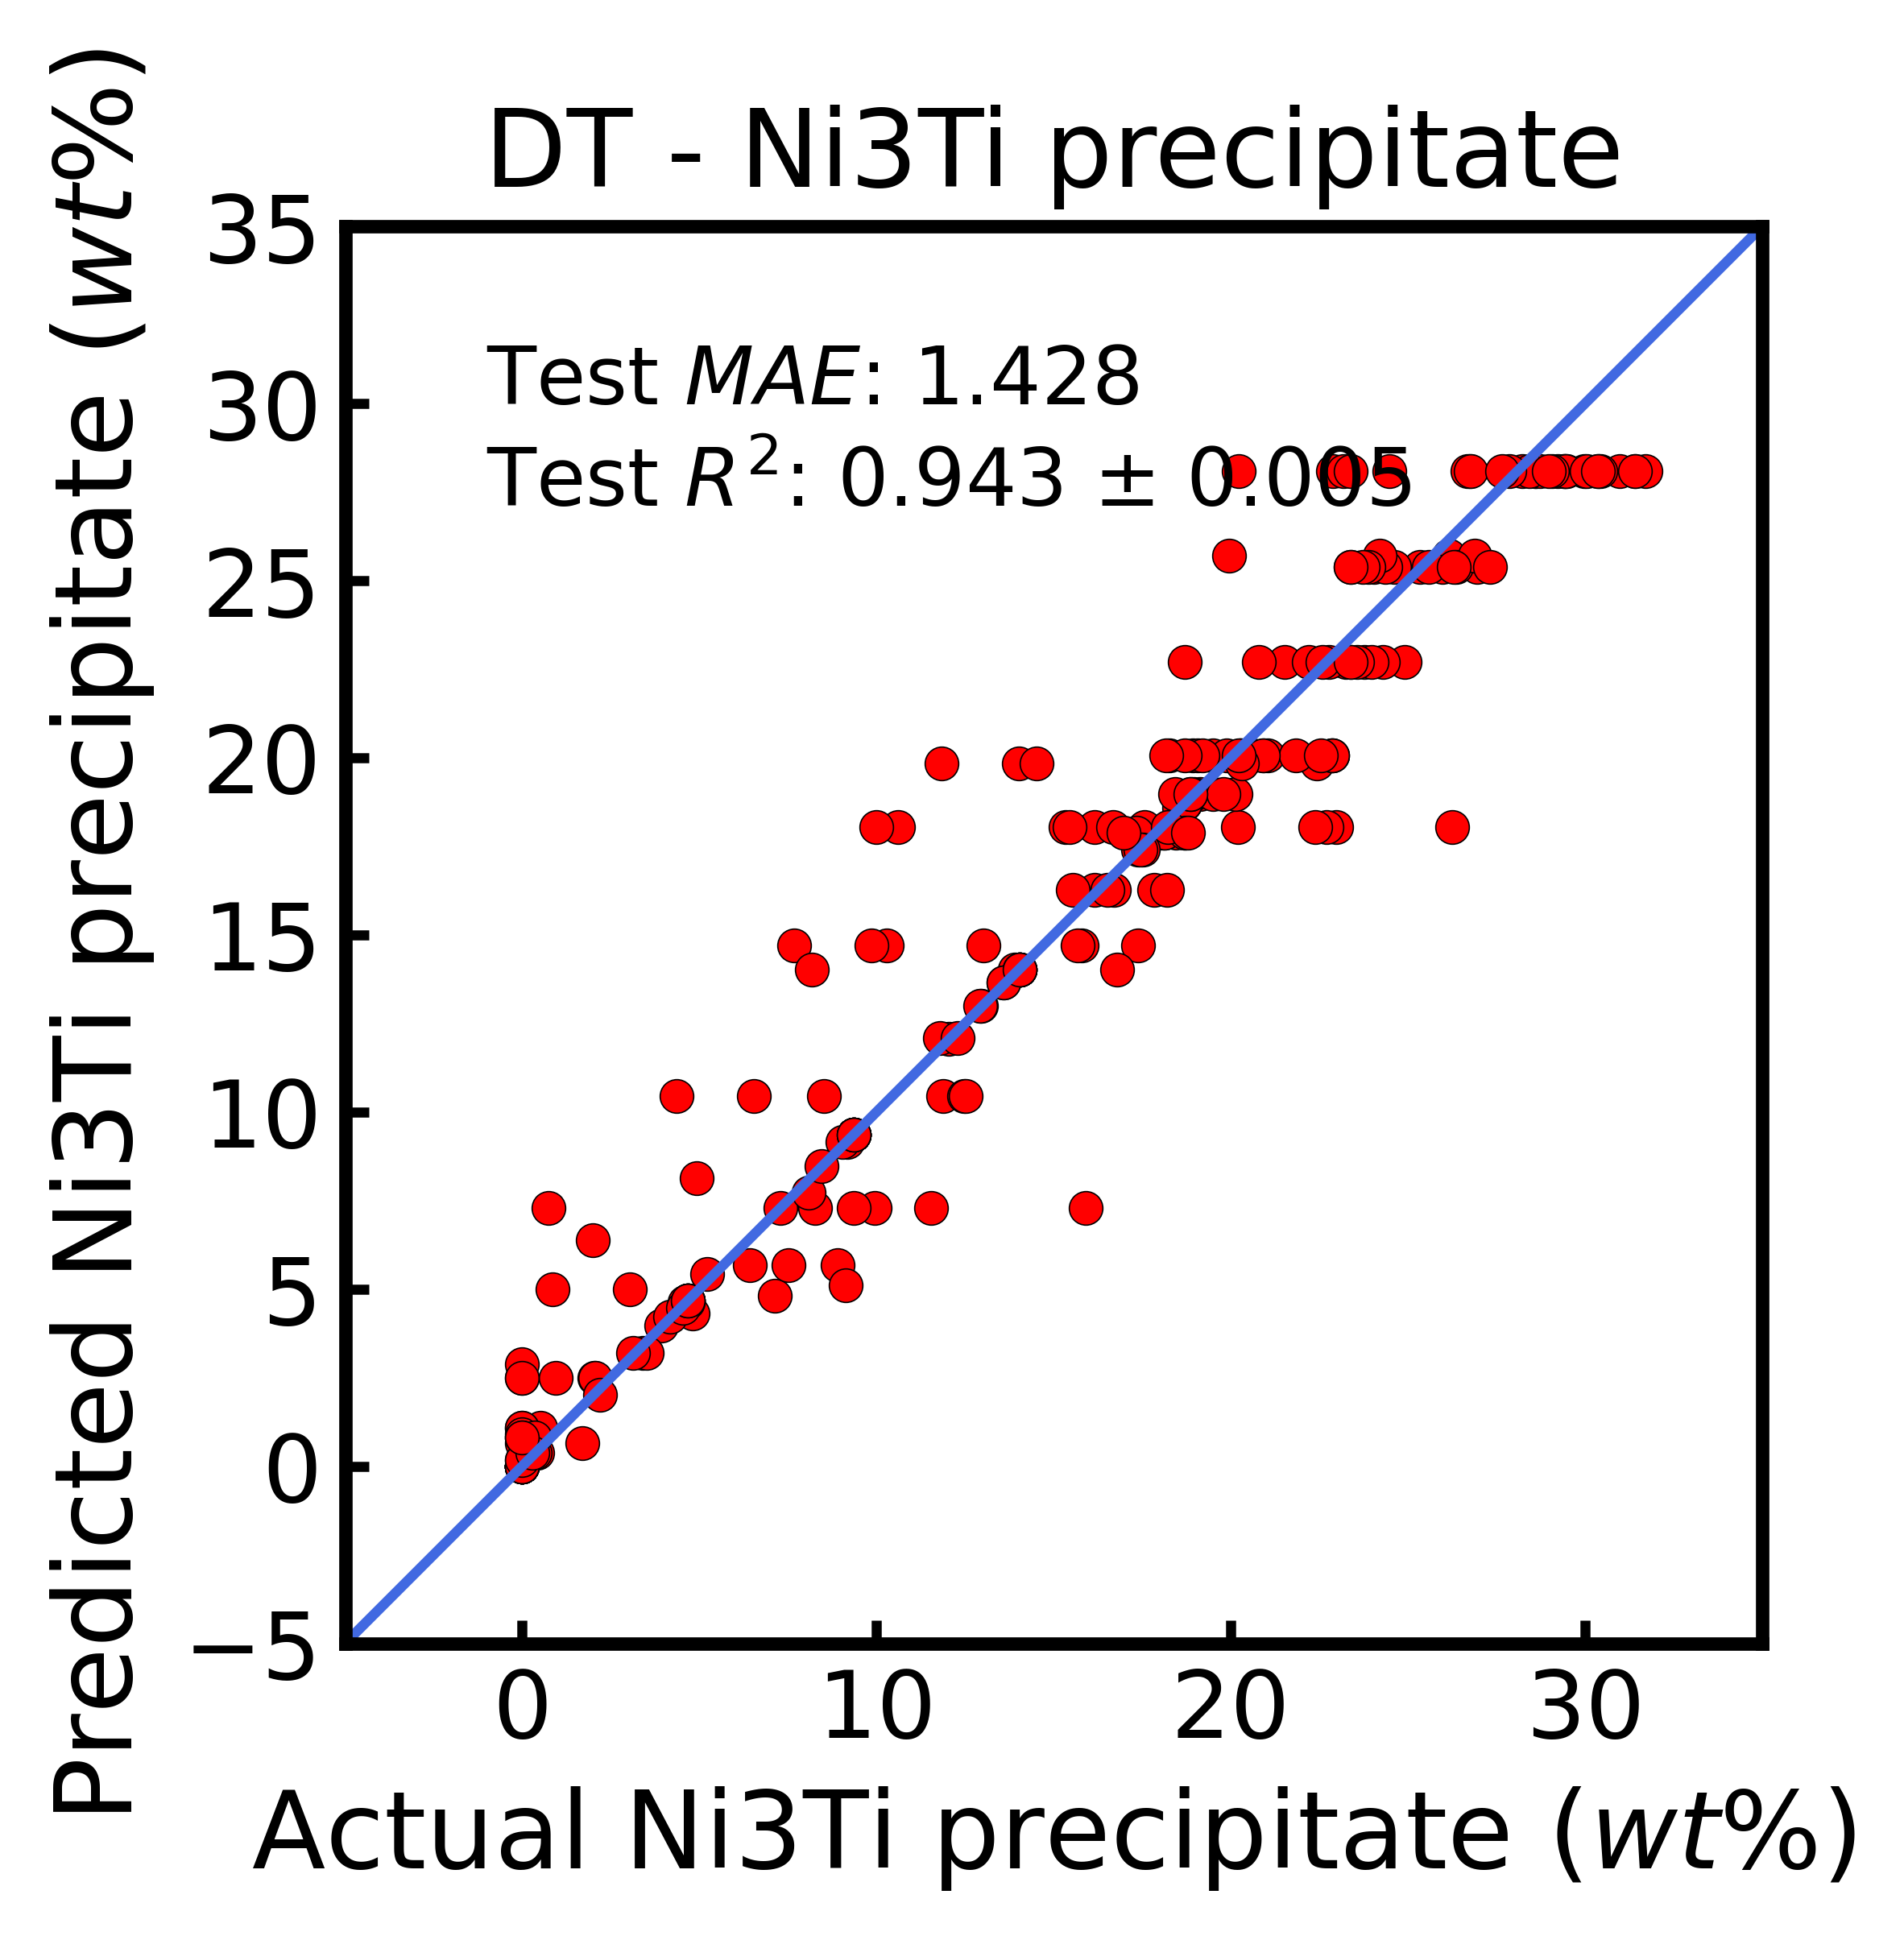

Saving figure Ni3Ti precipitateRF_test_.png


<Figure size 432x288 with 0 Axes>

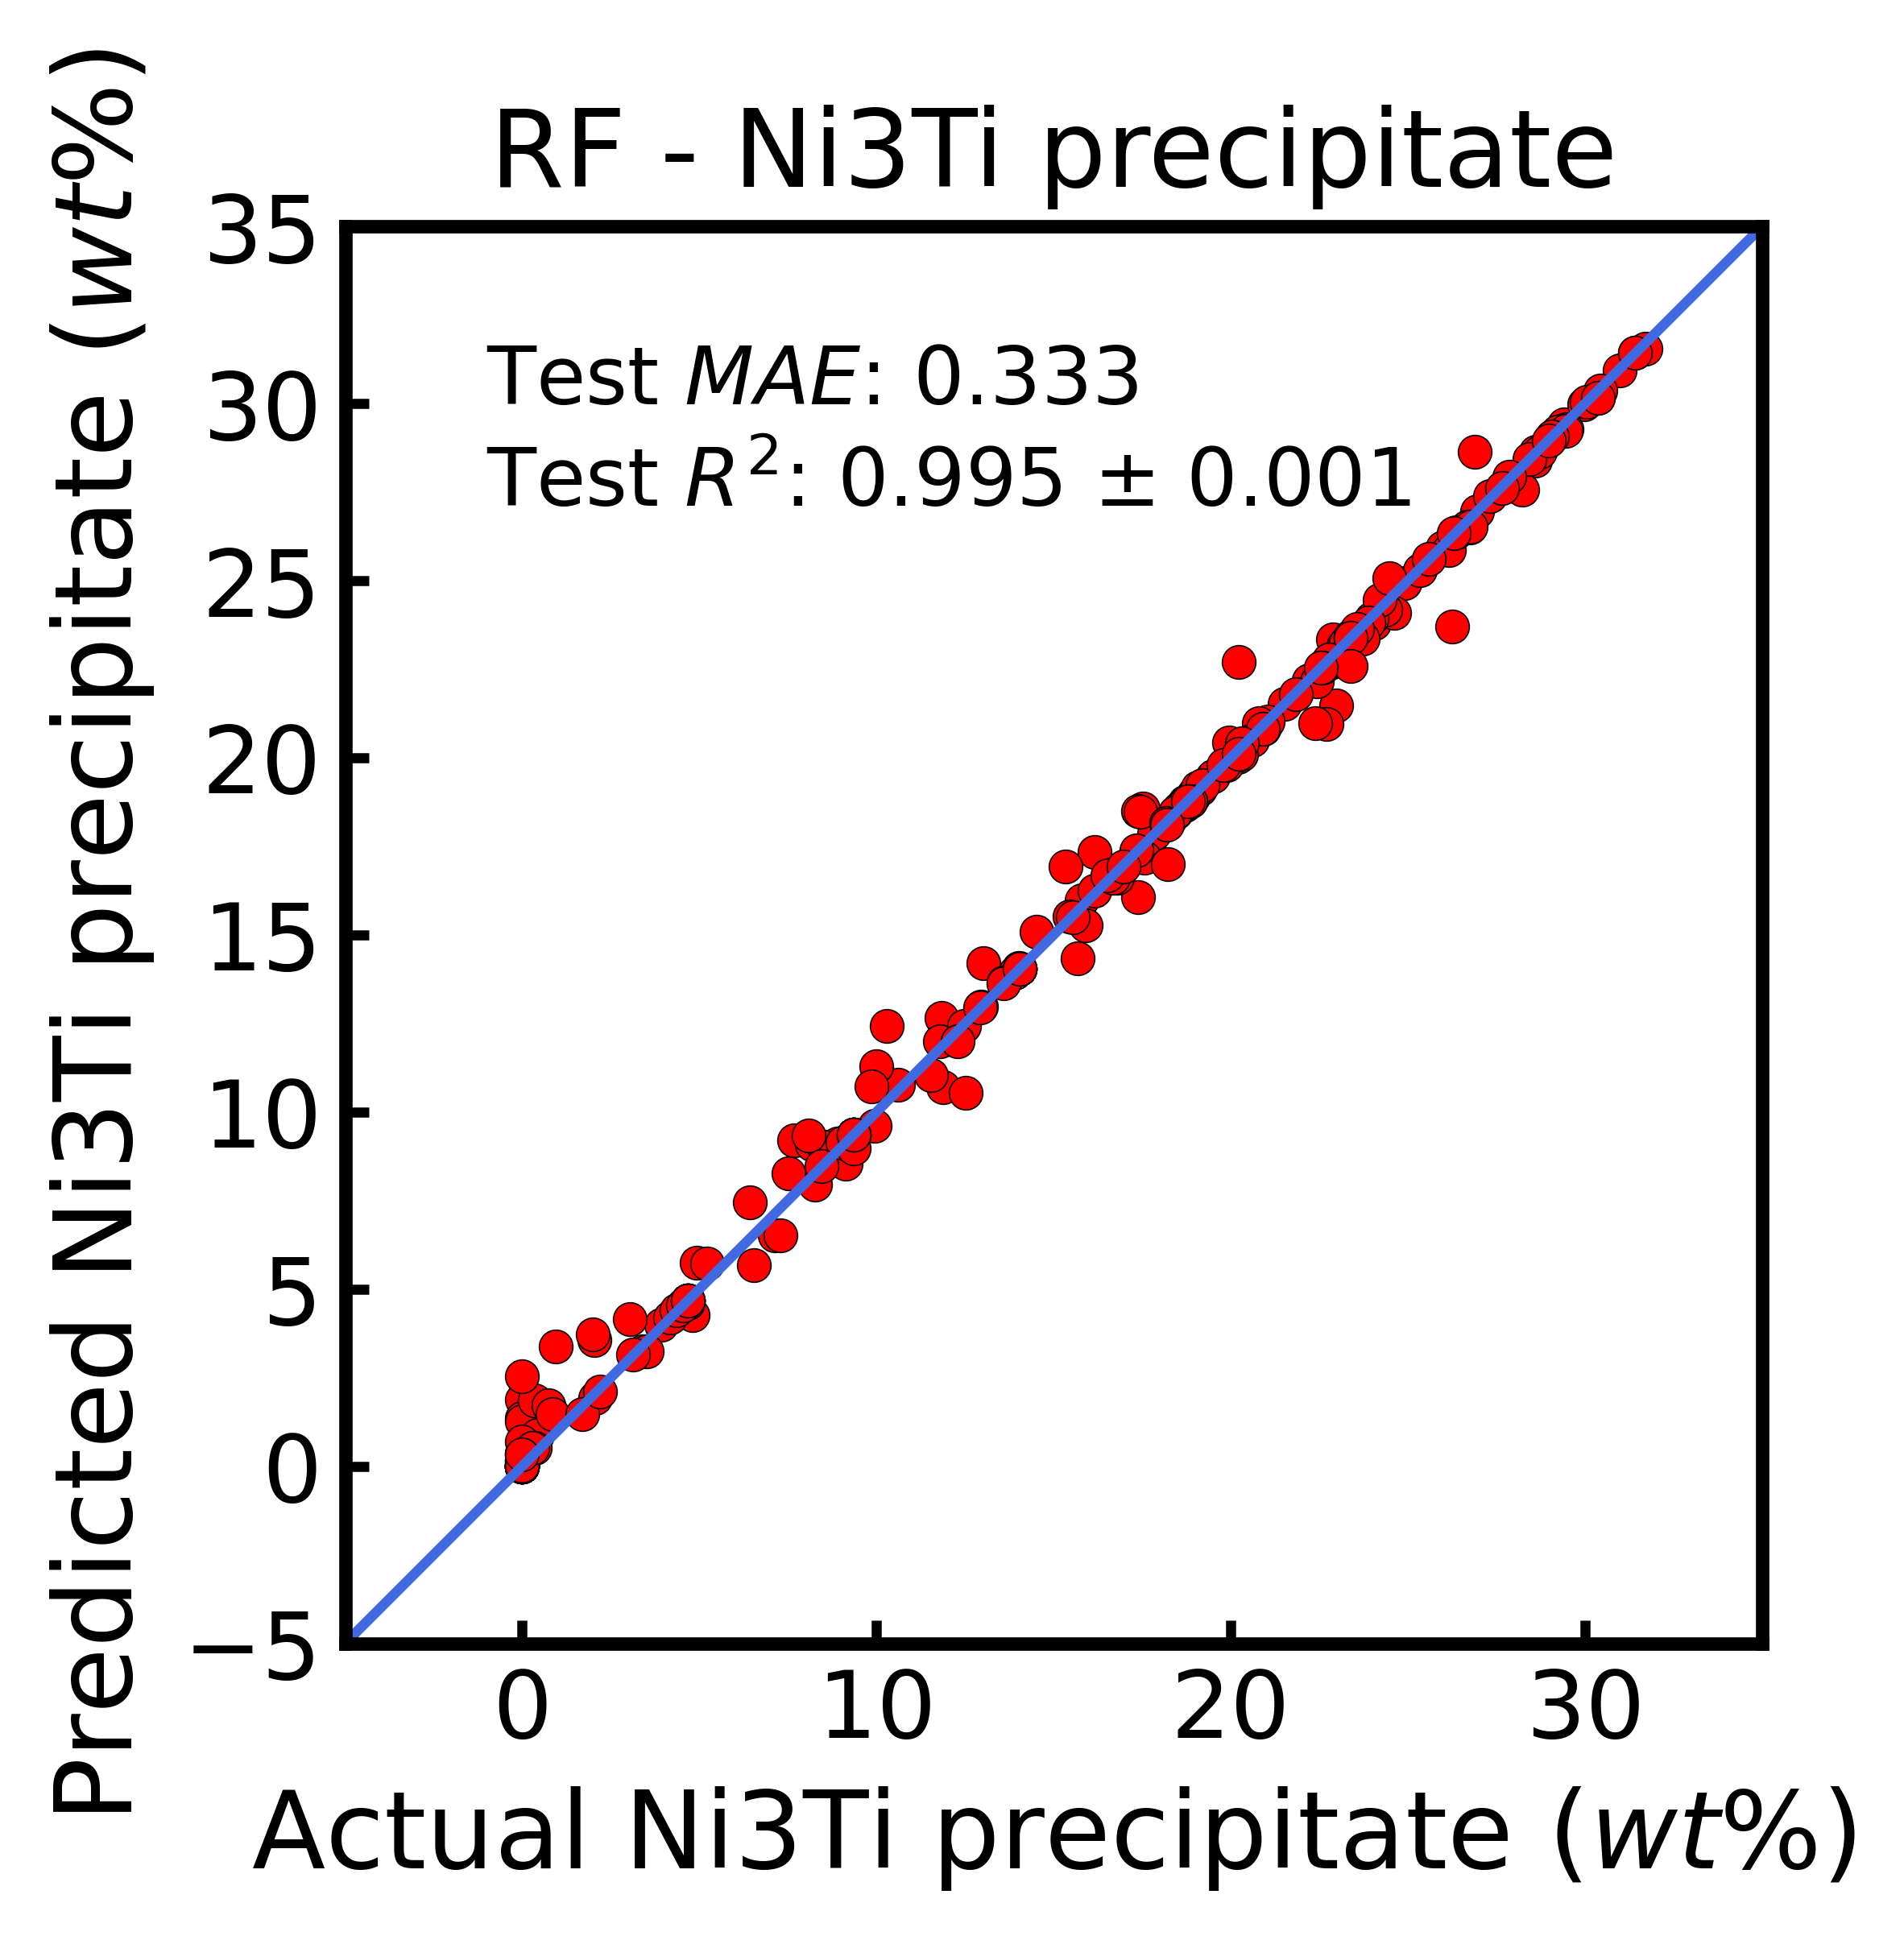

<Figure size 432x288 with 0 Axes>

In [176]:
# Iterate over implemented models
for modeltoggle in ['KNN', 'AdaBoost', 'DT', 'RF']: #'SVR'
    X_train = X_Ni3Ti_train_transformed
    y_train = Y_Ni3Ti_train
    title = "Ni3Ti precipitate"
    
    if modeltoggle == 'RF':
        model = metamodel_Ni3Ti_RF
    elif modeltoggle == 'KNN':
        model = metamodel_Ni3Ti_KNN
    elif modeltoggle == 'AdaBoost':
        model = metamodel_Ni3Ti_AdaBoost
    elif modeltoggle == 'DT':
        model = metamodel_Ni3Ti_DT
        
    # Perform cross validation for each model
    kf = KFold(n_splits=5)
    trains = []
    tests = []
    train_maes = []
    test_maes = []
    # Perform cross validation for each model
    for train, test in kf.split(X_train):

        # Shuffle data points before prediction
        X_shuffle, y_shuffle = shuffle(X_train, y_train, random_state=0)

        X_cv_train = X_shuffle[train]
        X_cv_test = X_shuffle[test]
        y_cv_train = y_shuffle[train]
        y_cv_test = y_shuffle[test]

        model.fit(X_cv_train, y_cv_train)

        # Calculate MAE and R^2

        y_predtrain = model.predict(X_cv_train)
        y_predtest = model.predict(X_cv_test)
        # R^2 score:
        trains.append(model.score(X_cv_train, y_cv_train))
        tests.append(model.score(X_cv_test, y_cv_test))
        
        # MAE score:
        mae_test = metrics.mean_absolute_error(y_cv_test, y_predtest)
        mae_train = metrics.mean_absolute_error(y_cv_train, y_predtrain)
        train_maes.append(mae_train)
        test_maes.append(mae_test)

    # Aggregate information
    trains = np.array(trains)
    tests = np.array(tests)
    train_maes = np.array(train_maes)
    test_maes = np.array(test_maes)
    
    r2_mean = tests.mean()
    r2_std = tests.std()
    r2_train_mean = trains.mean()
    r2_train_std =  trains.std()

    mae_mean_train = train_maes.mean()
    mae_mean_test = test_maes.mean()
    mae_mean_train_std = train_maes.std()
    mae_mean_test_std = test_maes.std()

    Ni3Ti_train_accuracy.append(r2_train_mean)
    Ni3Ti_train_accuracy_std.append(r2_train_std)
    Ni3Ti_test_accuracy_std.append(r2_std)
    Ni3Ti_test_accuracy.append(r2_mean)

    Ni3Ti_train_mae.append(mae_mean_train)
    Ni3Ti_train_mae_std.append(mae_mean_train_std)
    Ni3Ti_test_mae.append(mae_mean_test)
    Ni3Ti_test_mae_std.append(mae_mean_test_std)
    
    ####### ----------------------------- R^2 plots-----------------------#######
    fig = plt.figure(figsize = (4,4), dpi = 600)
    widths = 2
    ax = gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(widths)

        tick_width = 1.5
    plt.tick_params(direction = 'in', width = tick_width)
    plt.plot(y_cv_test, y_predtest, '.',color='red', ms = 10, mec='k', mew = 0.2) ##8B0000
    plt.xlim([-5, 35])
    plt.ylim([-5, 35])
    plt.plot(np.arange(-4*np.std(y_cv_train)+np.mean(y_cv_train), 4*np.std(y_cv_train)+np.mean(y_cv_train)), 
             np.arange(-4*np.std(y_cv_train)+np.mean(y_cv_train),4*np.std(y_cv_train)+np.mean(y_cv_train)), 'royalblue')
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    
    plt.title(modeltoggle + " - "+ str(title), fontsize = 16)
    plt.xlabel("Actual Ni3Ti precipitate $(wt\%)$", fontsize = 16)
    plt.ylabel("Predicted Ni3Ti precipitate $(wt\%)$", fontsize = 16)
    s_cv =  'Test $R^2$: {:.3f} ± {:.3f}'.format(r2_mean, r2_std)
    plt.text(-1, 1.3*np.std(y_cv_train)+np.mean(y_cv_train), s_cv, fontsize=12)
    s =  'Test $MAE$: {:.3f}'.format(mae_mean_test)
    plt.text(-1, 1.6*np.std(y_cv_train)+np.mean(y_cv_train), s, fontsize=12)
    
    plt.gca().set_aspect('equal')
    # frame_tick()
    save_fig(title+modeltoggle + "_test_"+".png")
    plt.show()
    plt.clf()

### metamodel_Laves

In [177]:
# fit_models = []
Laves_train_accuracy = []
Laves_train_accuracy_std = []
Laves_test_accuracy = []
Laves_test_accuracy_std = []
Laves_train_mae=[]
Laves_train_mae_std=[]
Laves_test_mae=[]
Laves_test_mae_std=[]

Saving figure Laves phaseKNN_test_.png


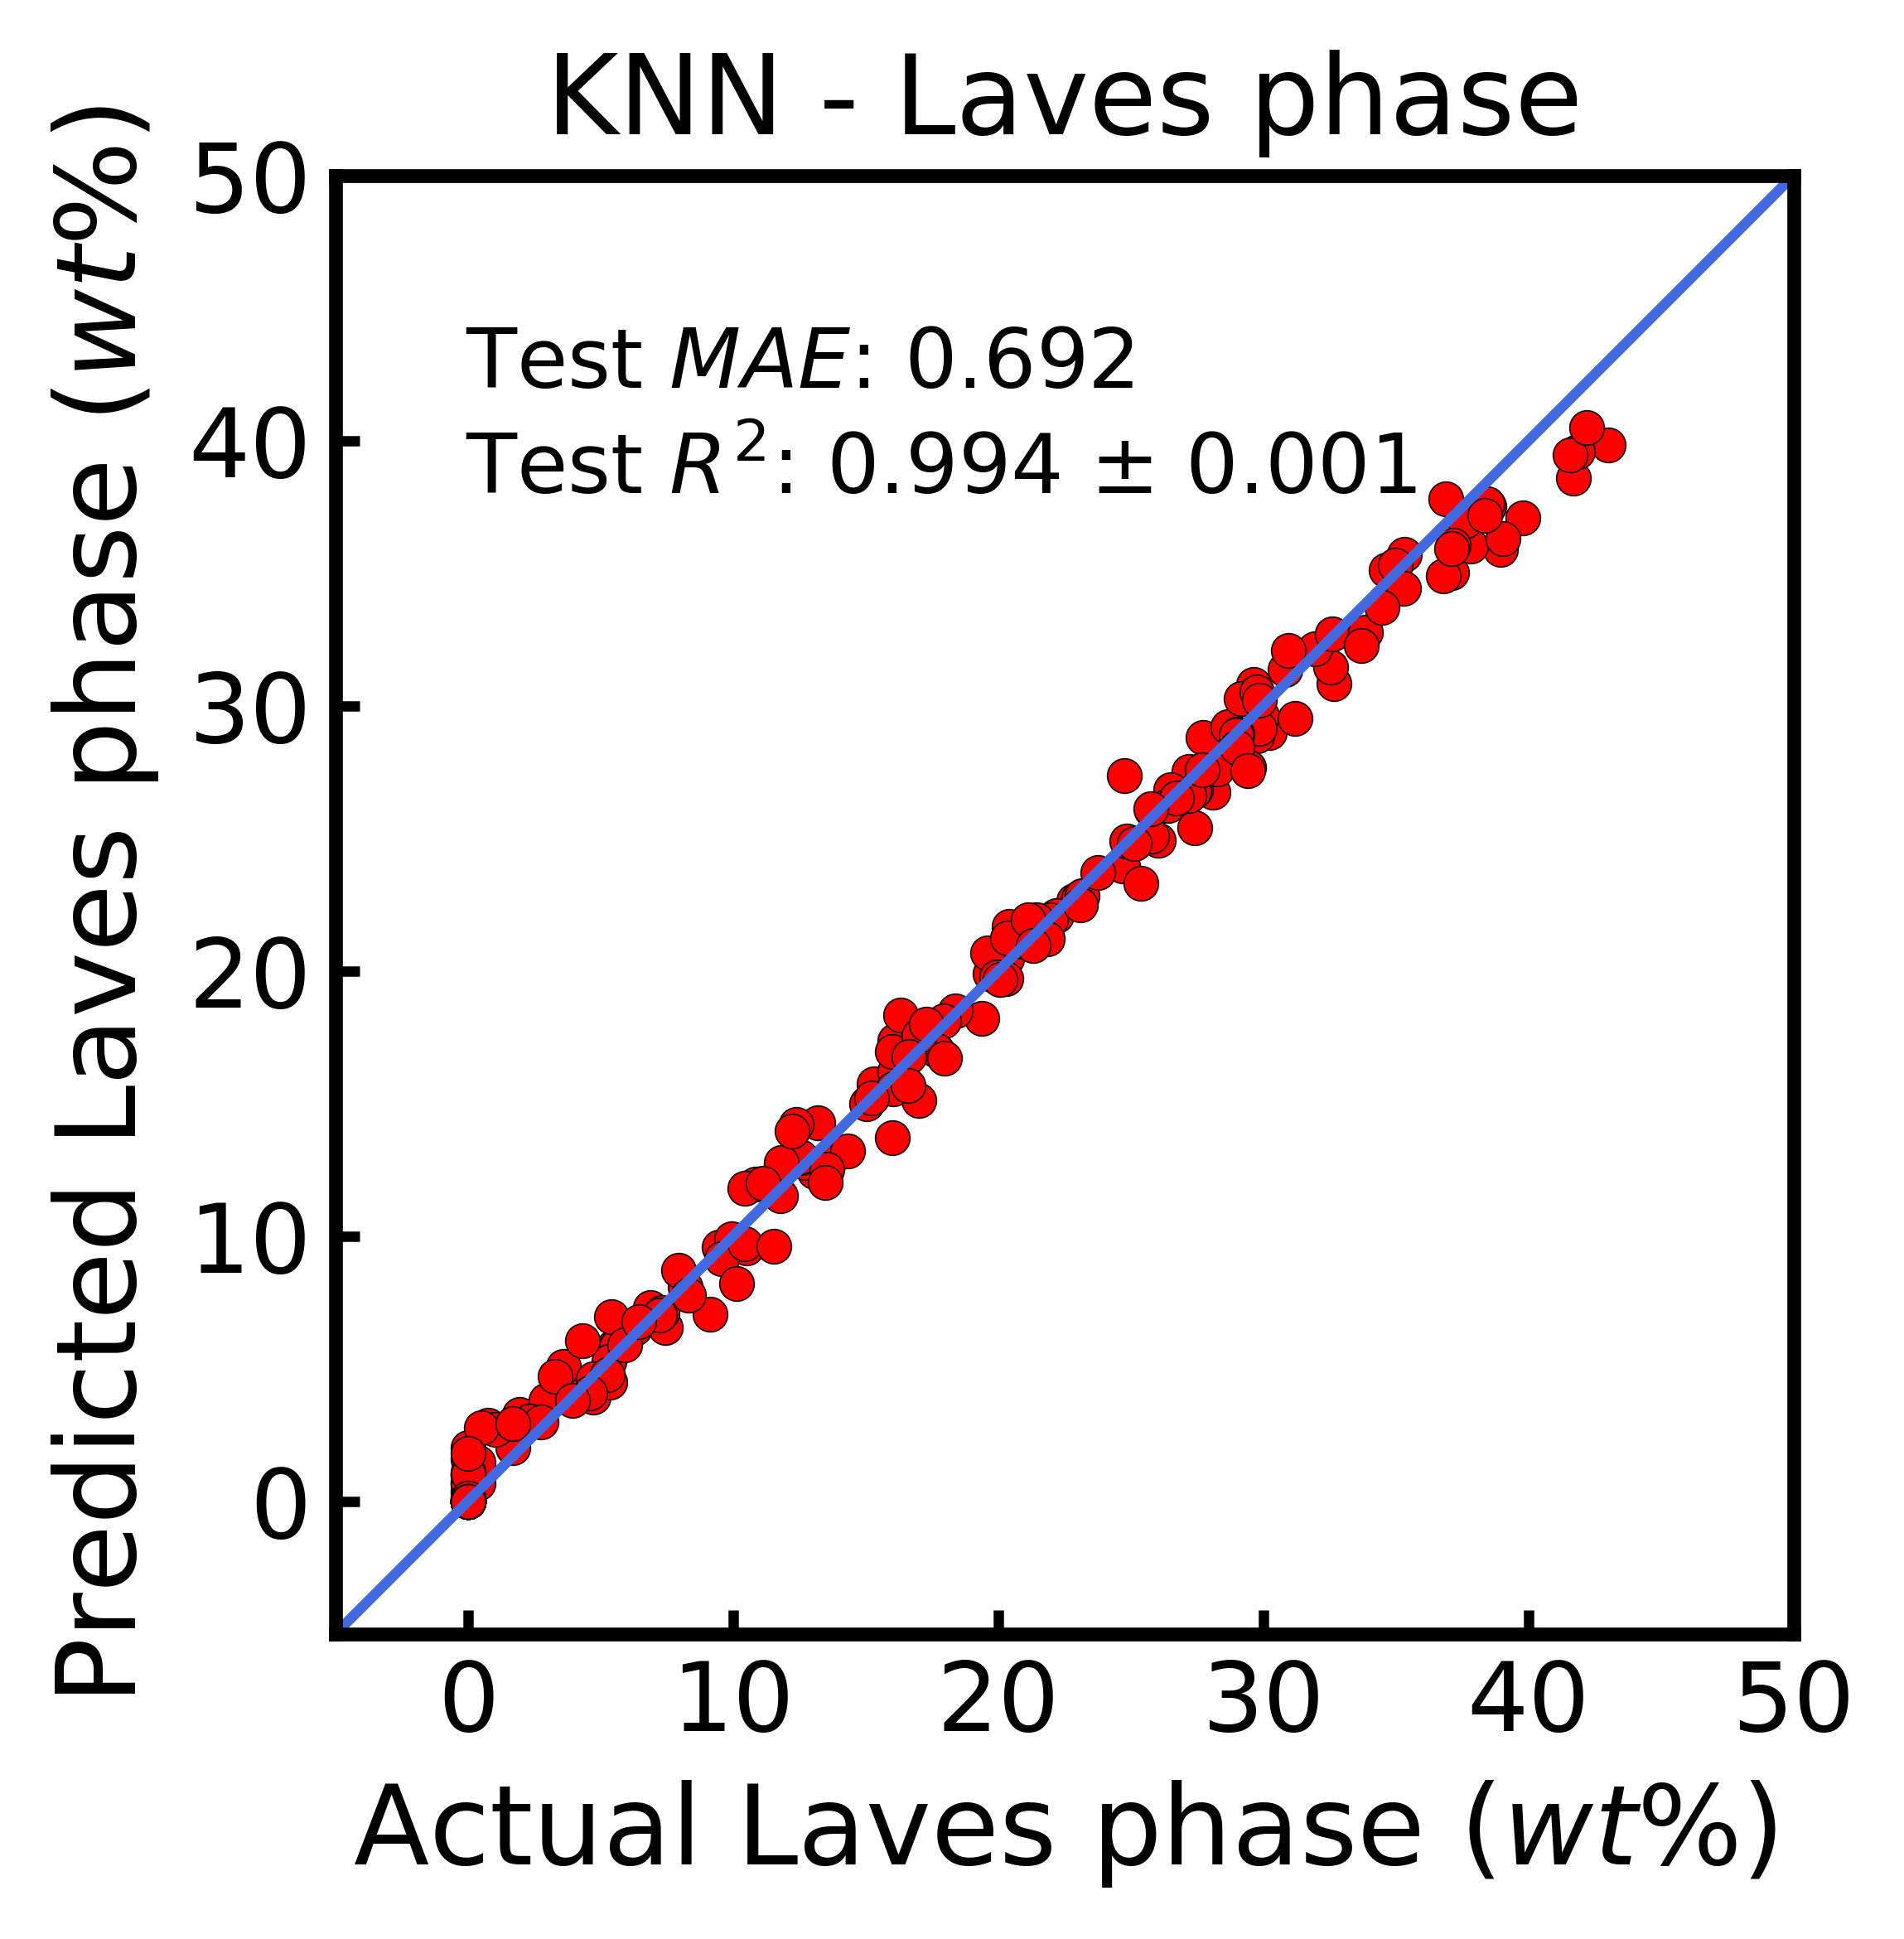

Saving figure Laves phaseAdaBoost_test_.png


<Figure size 432x288 with 0 Axes>

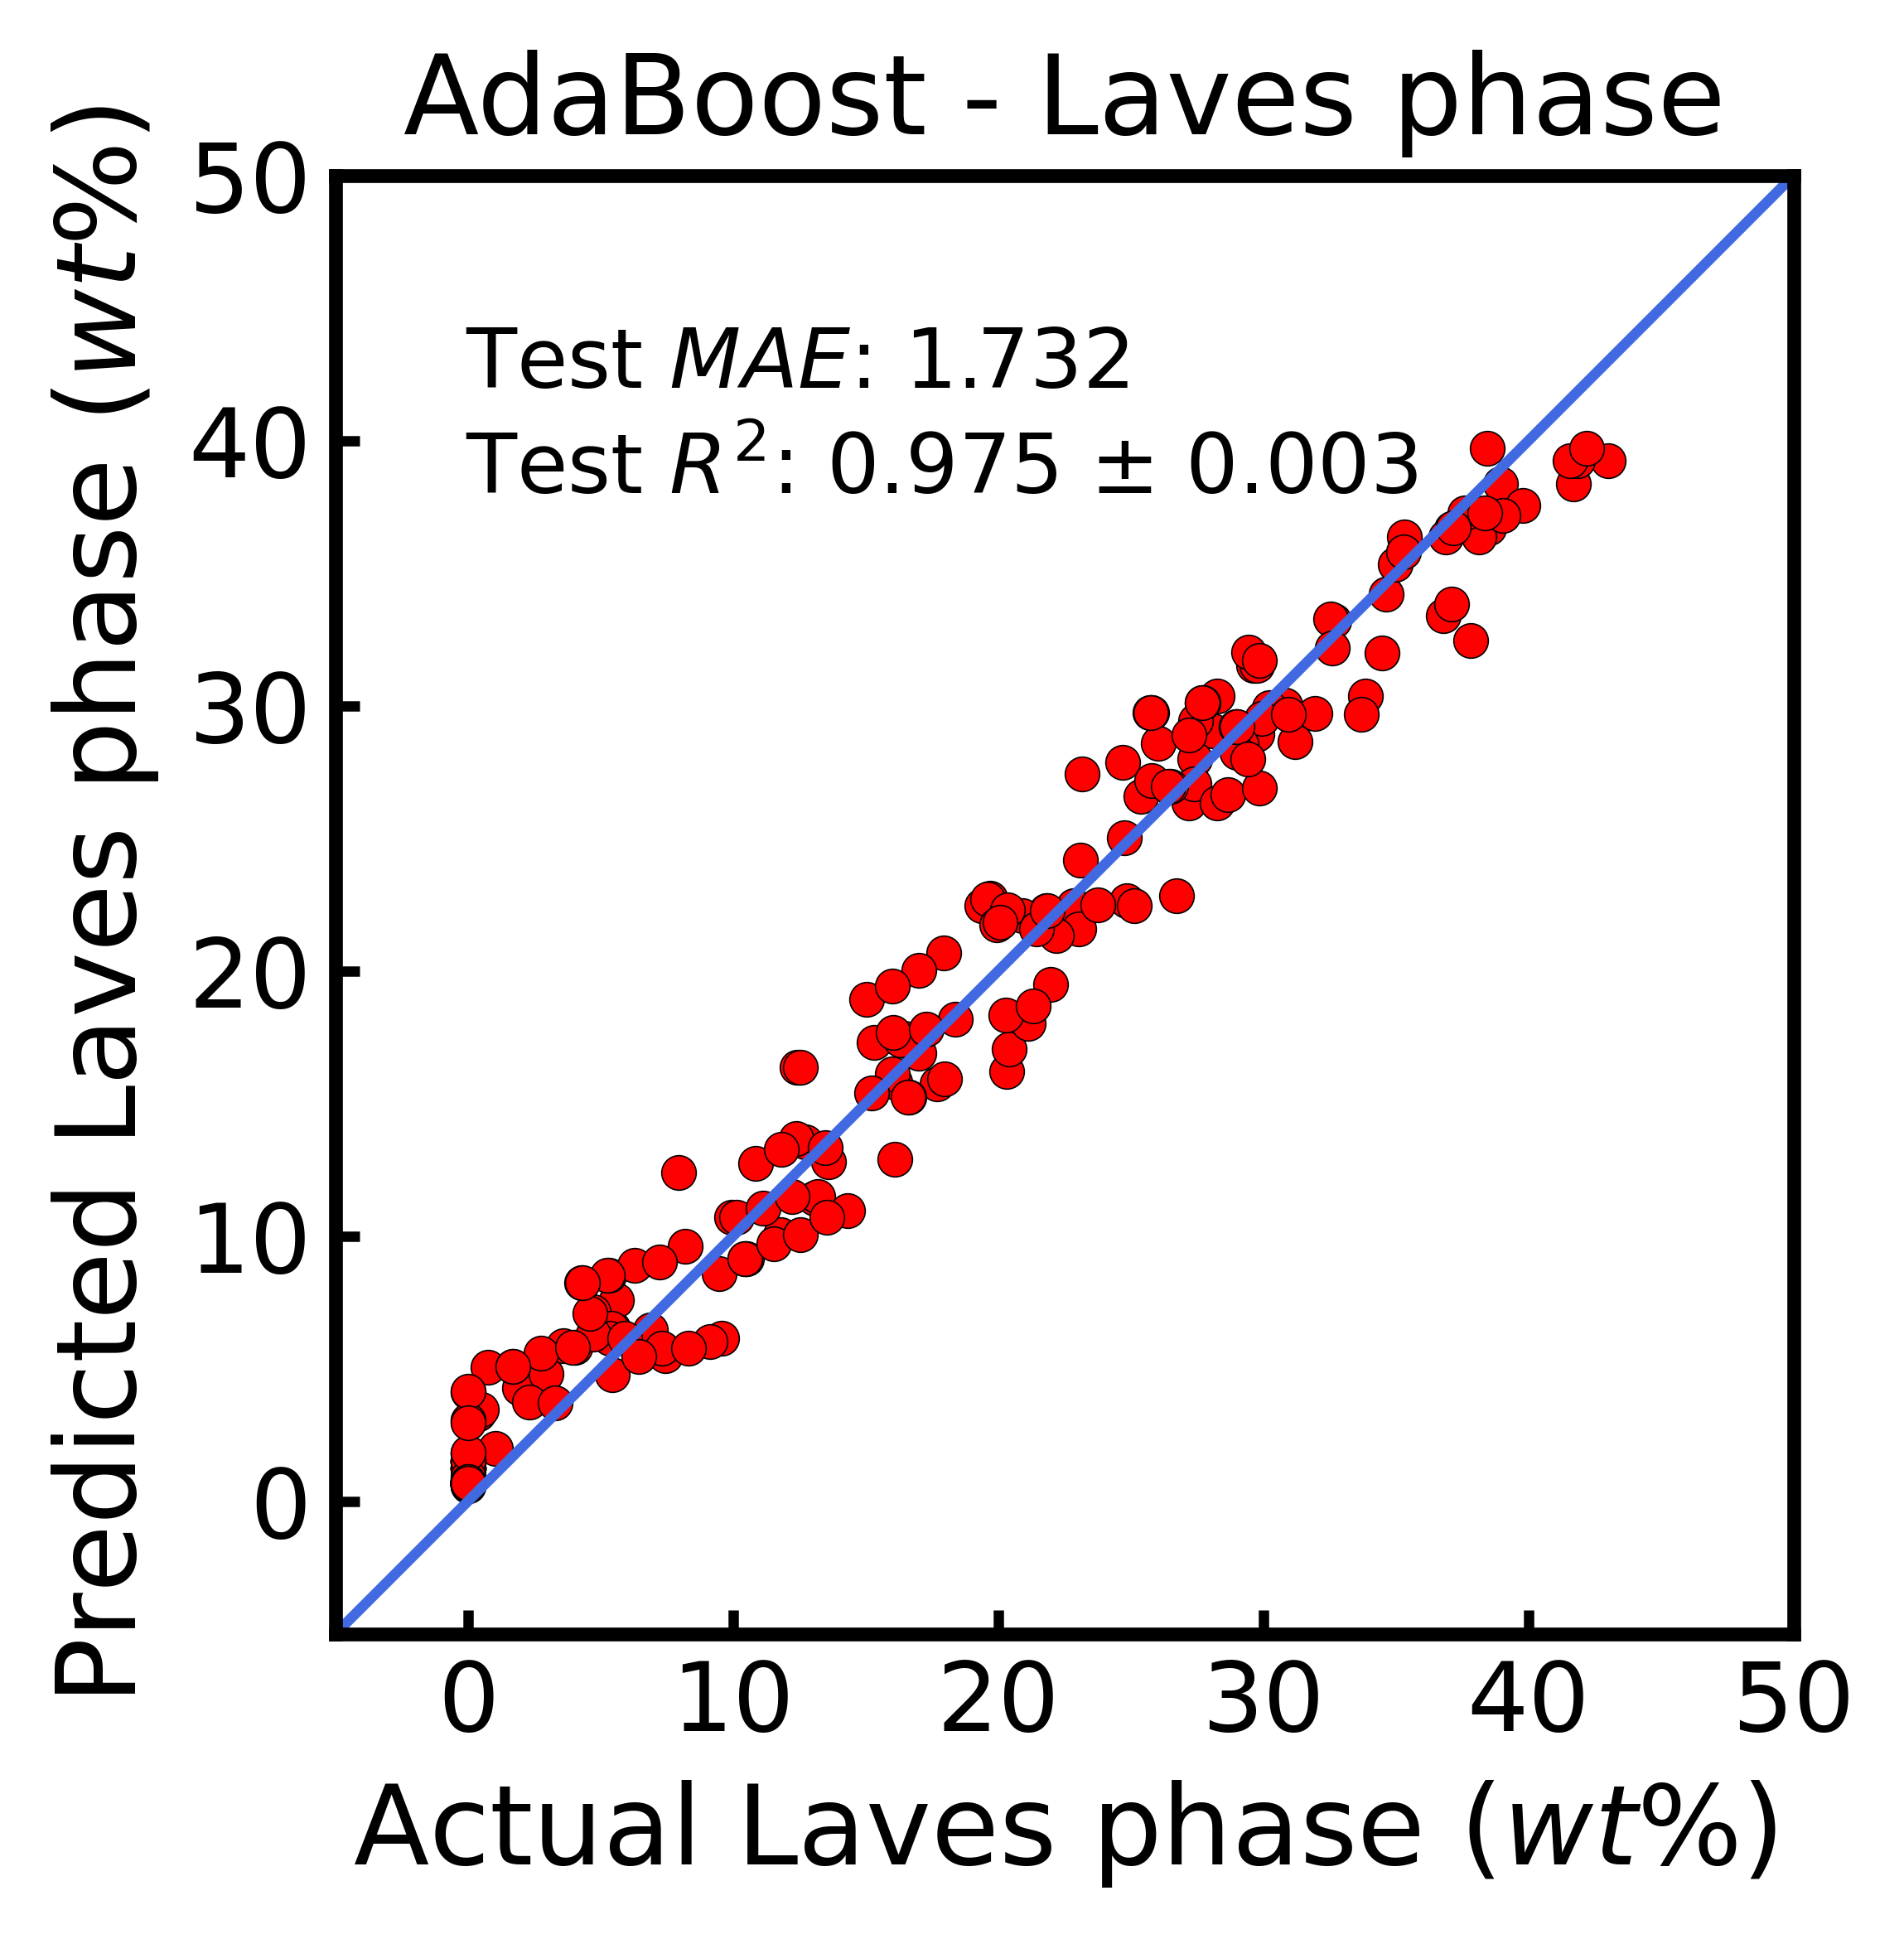

Saving figure Laves phaseDT_test_.png


<Figure size 432x288 with 0 Axes>

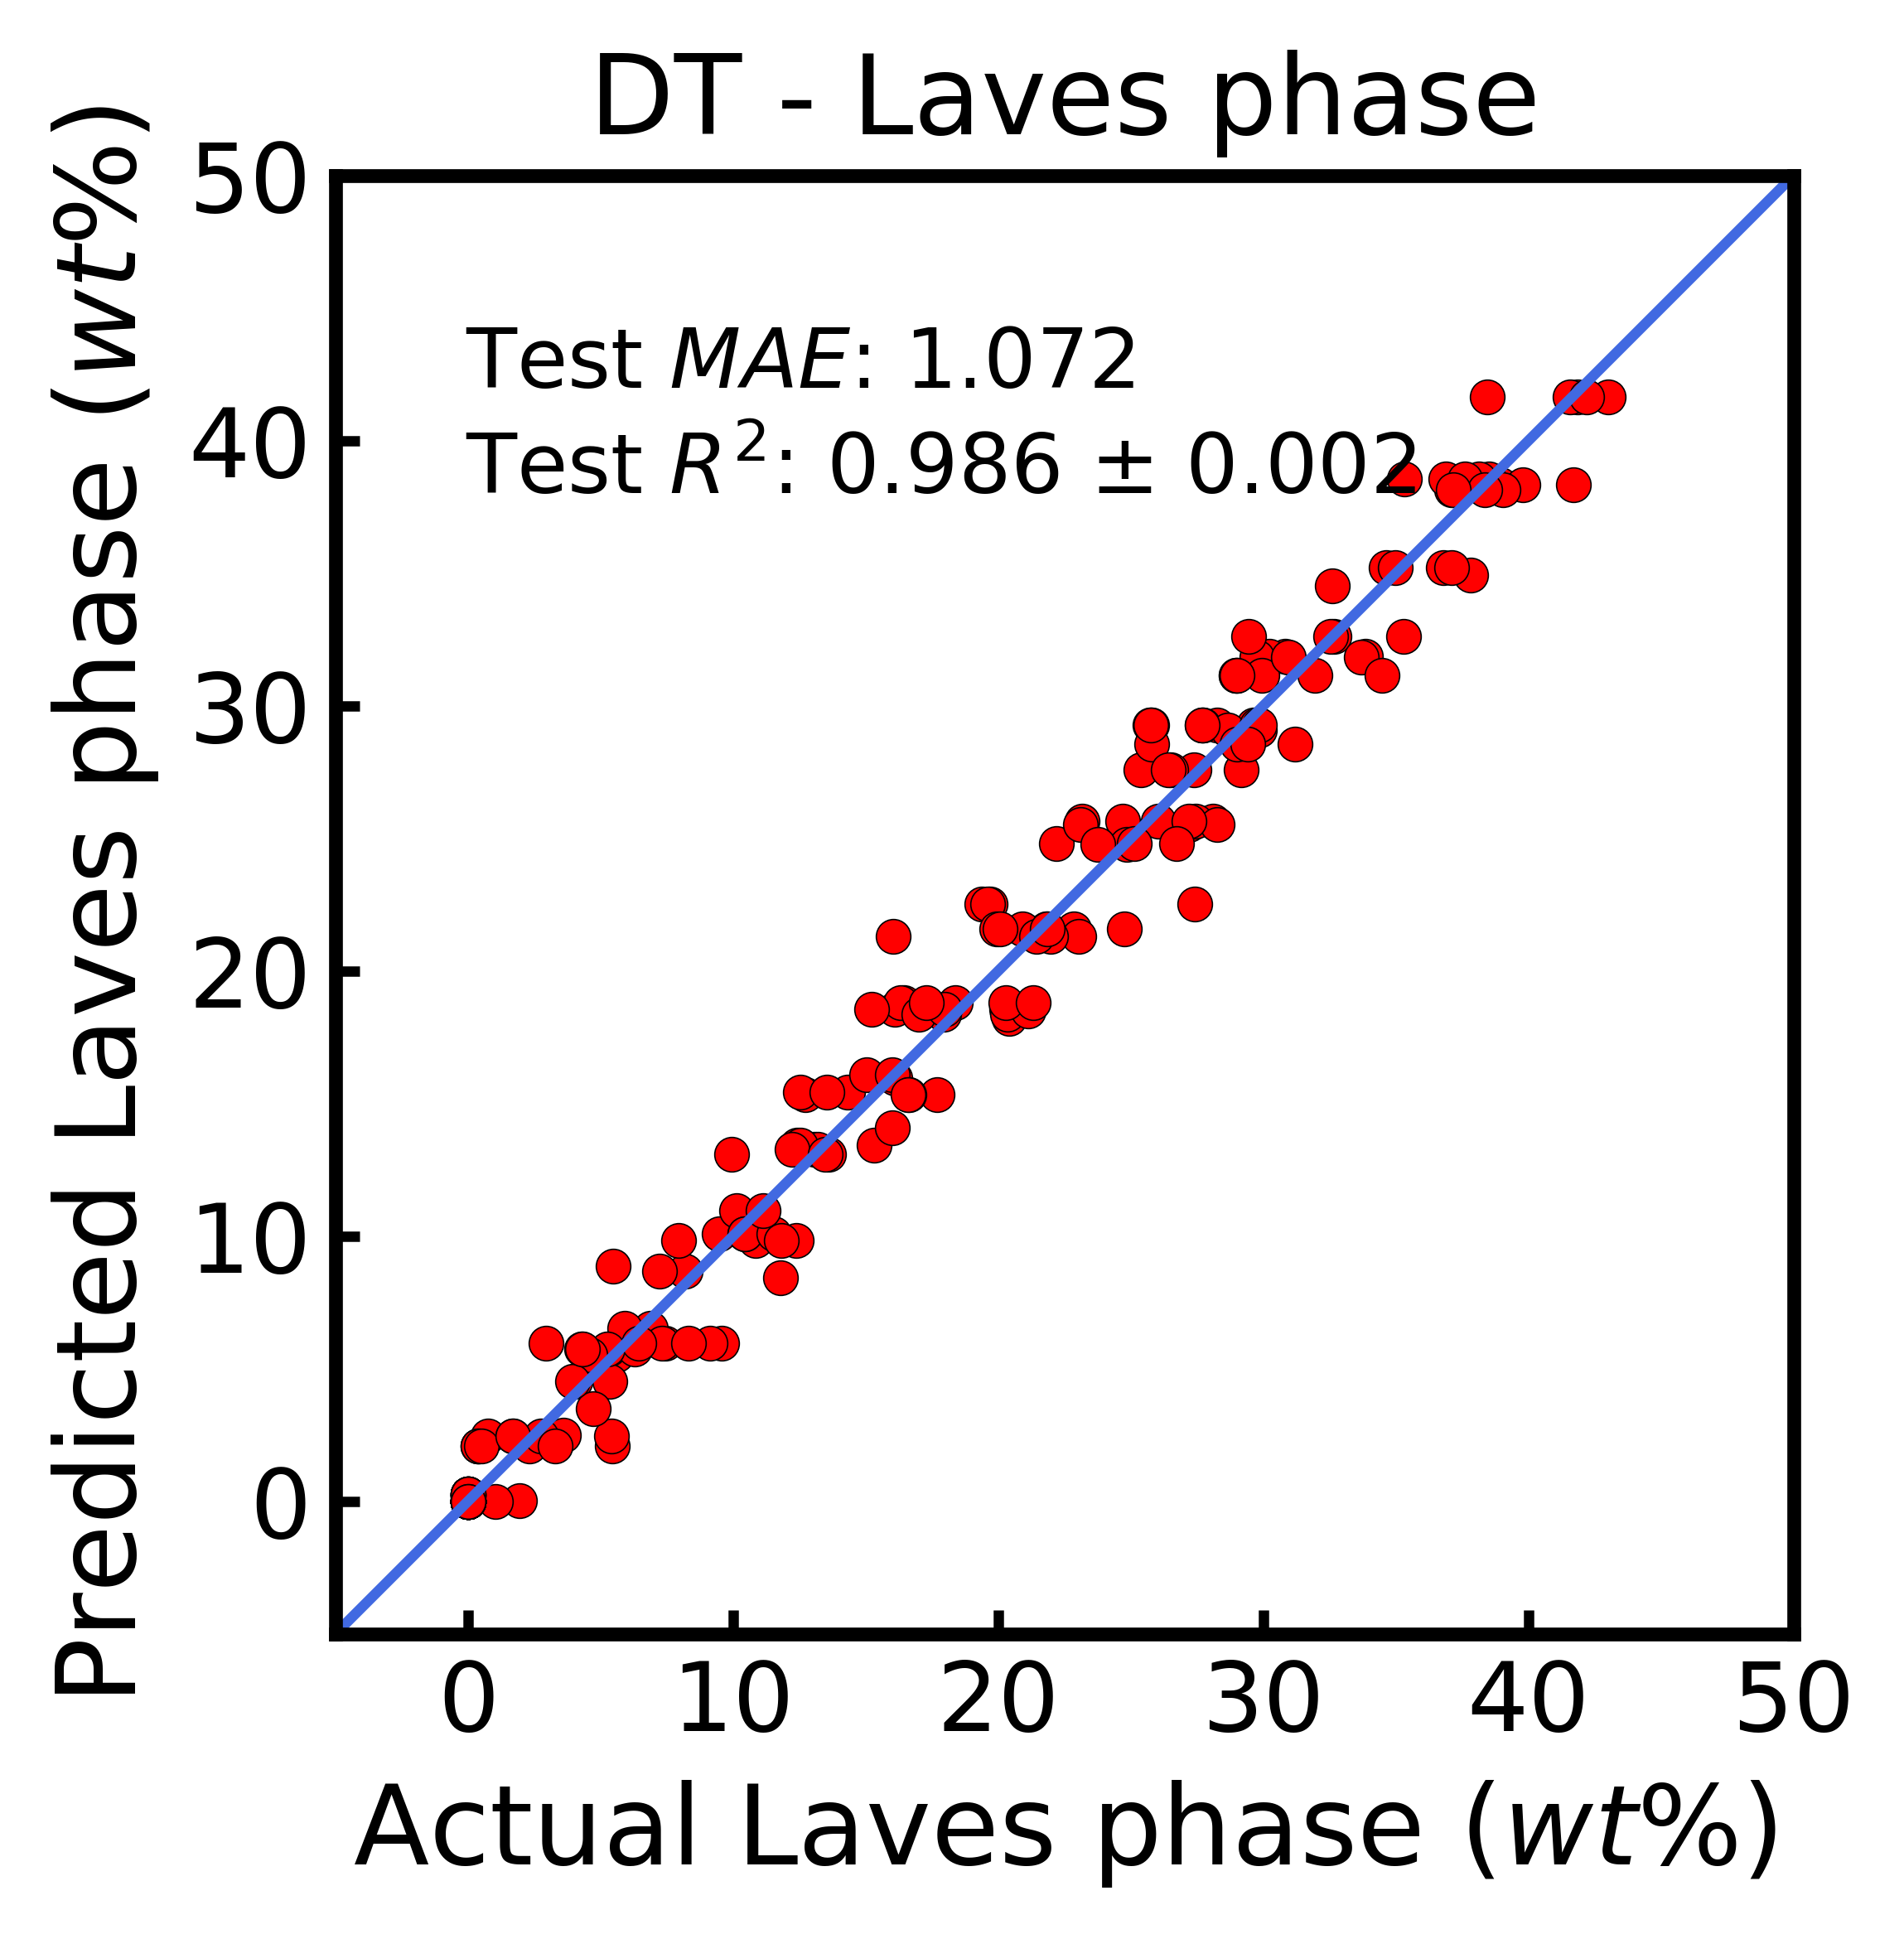

Saving figure Laves phaseRF_test_.png


<Figure size 432x288 with 0 Axes>

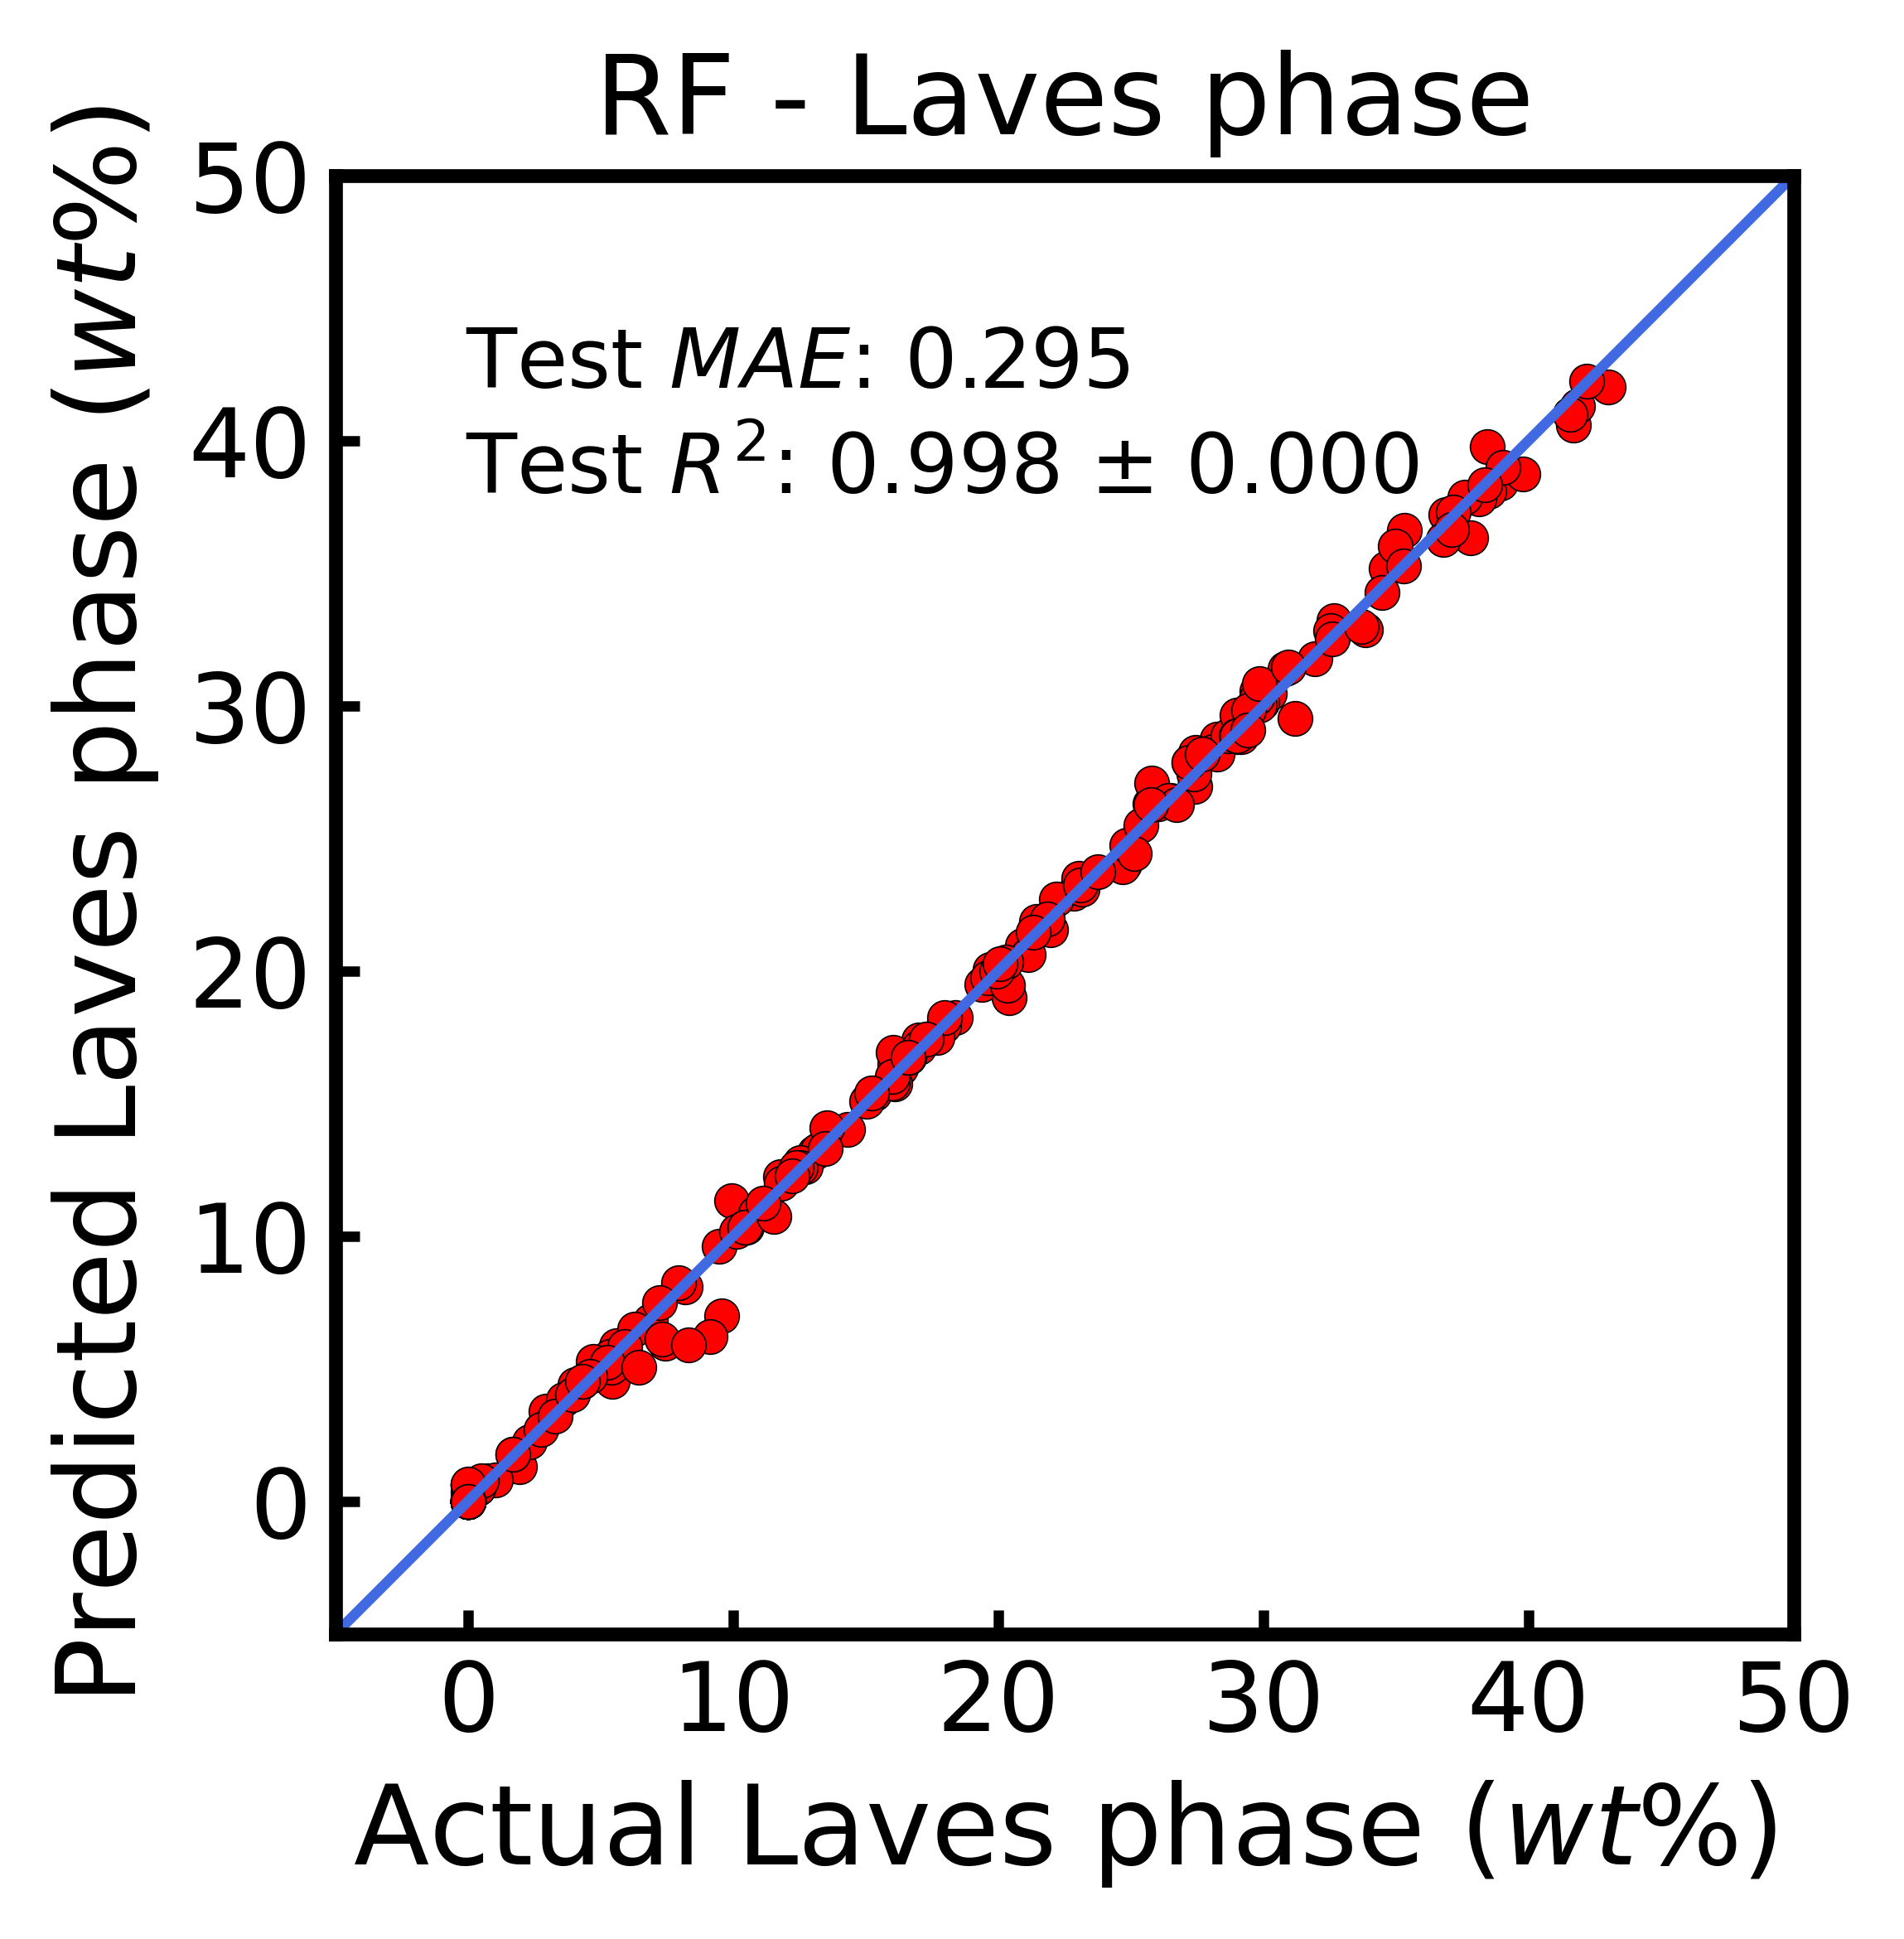

<Figure size 432x288 with 0 Axes>

In [178]:
# Iterate over implemented models
for modeltoggle in ['KNN', 'AdaBoost', 'DT', 'RF']: #'SVR'
    X_train = X_Laves_train_transformed
    y_train = Y_Laves_train
    
    title = "Laves phase"
    
    if modeltoggle == 'RF':
        model = metamodel_Laves_RF
    elif modeltoggle == 'KNN':
        model = metamodel_Laves_KNN
    elif modeltoggle == 'AdaBoost':
        model = metamodel_Laves_AdaBoost
    elif modeltoggle == 'DT':
        model = metamodel_Laves_DT
        
    # Perform cross validation for each model
    kf = KFold(n_splits=5)
    trains = []
    tests = []
    train_maes = []
    test_maes = []
    # Perform cross validation for each model
    for train, test in kf.split(X_train):

        # Shuffle data points before prediction
        X_shuffle, y_shuffle = shuffle(X_train, y_train, random_state=0)

        X_cv_train = X_shuffle[train]
        X_cv_test = X_shuffle[test]
        y_cv_train = y_shuffle[train]
        y_cv_test = y_shuffle[test]

        model.fit(X_cv_train, y_cv_train)

        # Calculate MAE and R^2

        y_predtrain = model.predict(X_cv_train)
        y_predtest = model.predict(X_cv_test)
        # R^2 score:
        trains.append(model.score(X_cv_train, y_cv_train))
        tests.append(model.score(X_cv_test, y_cv_test))
        
        # MAE score:
        mae_test = metrics.mean_absolute_error(y_cv_test, y_predtest)
        mae_train = metrics.mean_absolute_error(y_cv_train, y_predtrain)
        train_maes.append(mae_train)
        test_maes.append(mae_test)

    # Aggregate information
    trains = np.array(trains)
    tests = np.array(tests)
    train_maes = np.array(train_maes)
    test_maes = np.array(test_maes)
    
    r2_mean = tests.mean()
    r2_std = tests.std()
    r2_train_mean = trains.mean()
    r2_train_std =  trains.std()

    mae_mean_train = train_maes.mean()
    mae_mean_test = test_maes.mean()
    mae_mean_train_std = train_maes.std()
    mae_mean_test_std = test_maes.std()

    Laves_train_accuracy.append(r2_train_mean)
    Laves_train_accuracy_std.append(r2_train_std)
    Laves_test_accuracy_std.append(r2_std)
    Laves_test_accuracy.append(r2_mean)

    Laves_train_mae.append(mae_mean_train)
    Laves_train_mae_std.append(mae_mean_train_std)
    Laves_test_mae.append(mae_mean_test)
    Laves_test_mae_std.append(mae_mean_test_std)
    
    ####### ----------------------------- R^2 plots-----------------------#######
    fig = plt.figure(figsize = (4,4), dpi = 600)
    widths = 2
    ax = gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(widths)

        tick_width = 1.5
    plt.tick_params(direction = 'in', width = tick_width)
    plt.plot(y_cv_test, y_predtest, '.',color='red', ms = 10, mec='k', mew = 0.2)
    plt.plot(np.arange(-3*np.std(y_cv_train)+np.mean(y_cv_train), 3*np.std(y_cv_train)+np.mean(y_cv_train)), 
             np.arange(-3*np.std(y_cv_train)+np.mean(y_cv_train),3*np.std(y_cv_train)+np.mean(y_cv_train)), 'royalblue')
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xlim([-5, 50])
    plt.ylim([-5, 50])
    
    plt.title(modeltoggle + " - "+ str(title), fontsize = 16)
    plt.xlabel("Actual Laves phase $(wt\%)$", fontsize = 16)
    plt.ylabel("Predicted Laves phase $(wt\%)$", fontsize = 16)
    s_cv =  'Test $R^2$: {:.3f} ± {:.3f}'.format(r2_mean, r2_std)
    plt.text(-0.1, 1.8*np.std(y_cv_train)+np.mean(y_cv_train), s_cv, fontsize=12)
    s =  'Test $MAE$: {:.3f}'.format(mae_mean_test)
    plt.text(-0.1, 2.1*np.std(y_cv_train)+np.mean(y_cv_train), s, fontsize=12)
    
    plt.gca().set_aspect('equal')
    # frame_tick()
    save_fig(title+modeltoggle + "_test_"+".png")
    plt.show()
    plt.clf()

### metamodel_FCC

In [179]:
# fit_models = []
FCC_train_accuracy = []
FCC_train_accuracy_std = []
FCC_test_accuracy = []
FCC_test_accuracy_std = []
FCC_train_mae=[]
FCC_train_mae_std=[]
FCC_test_mae=[]
FCC_test_mae_std=[]

Saving figure FCC phaseKNNtest.png


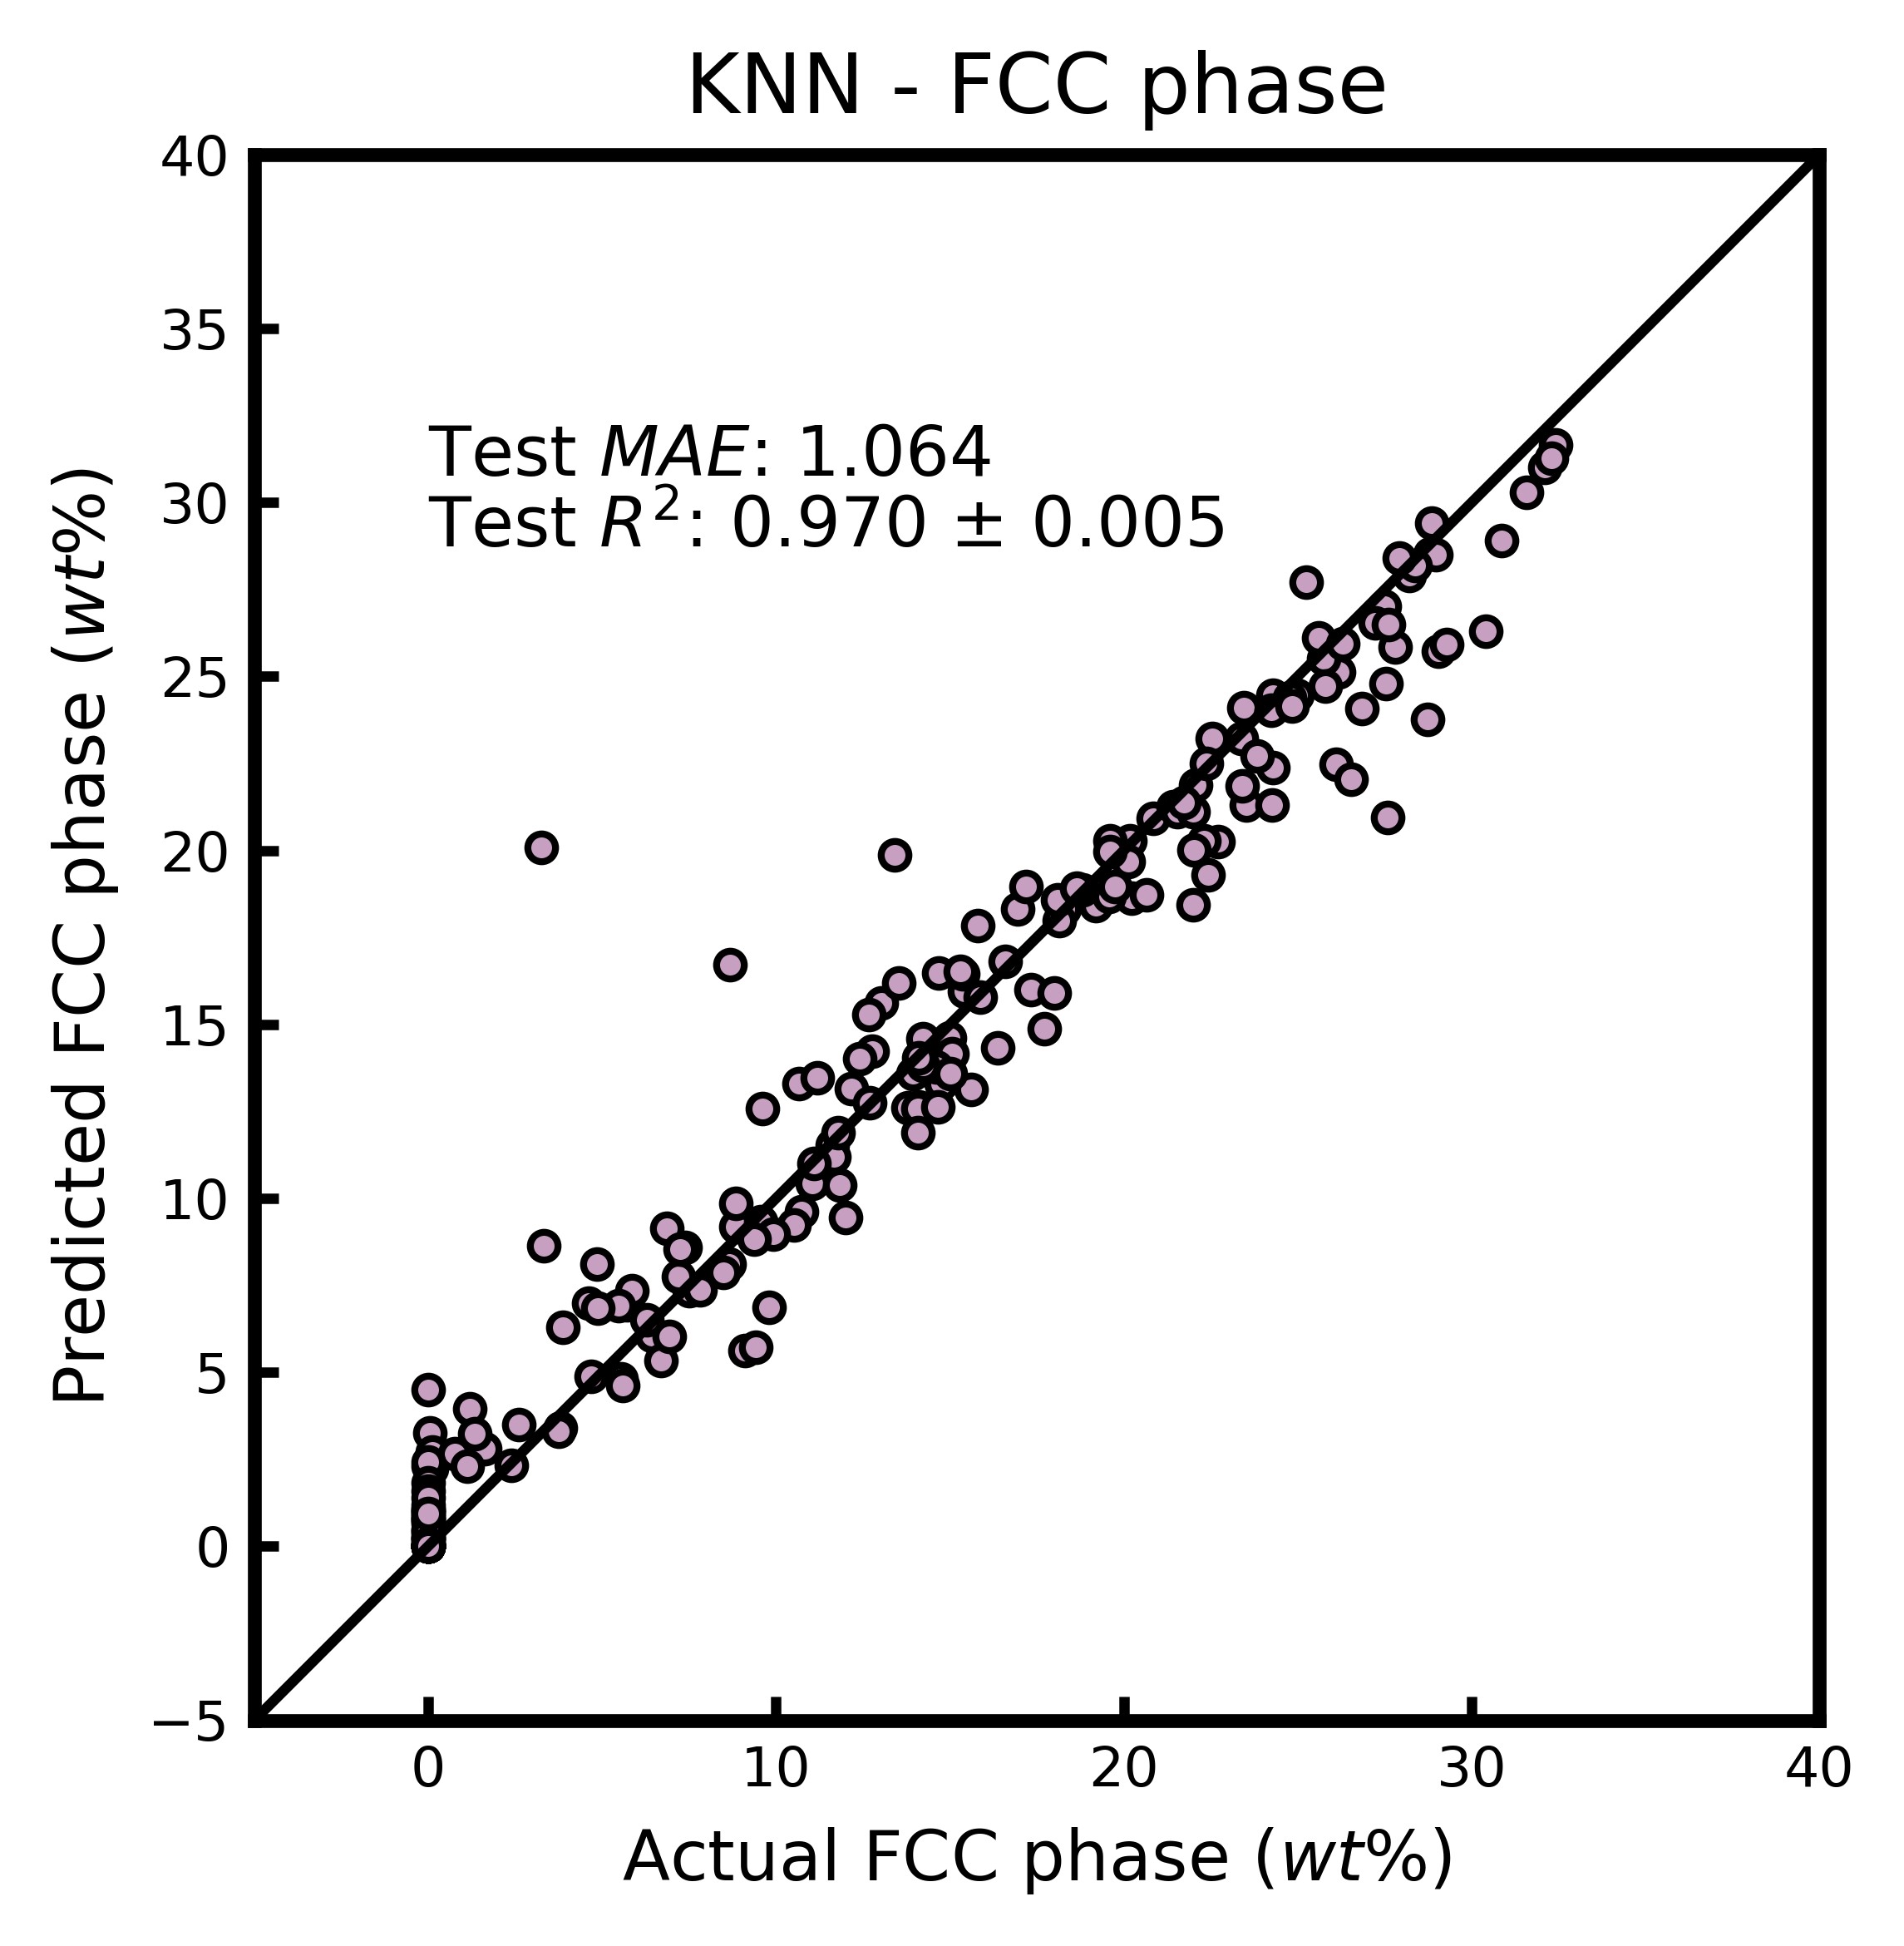

Saving figure FCC phaseAdaBoosttest.png


<Figure size 432x288 with 0 Axes>

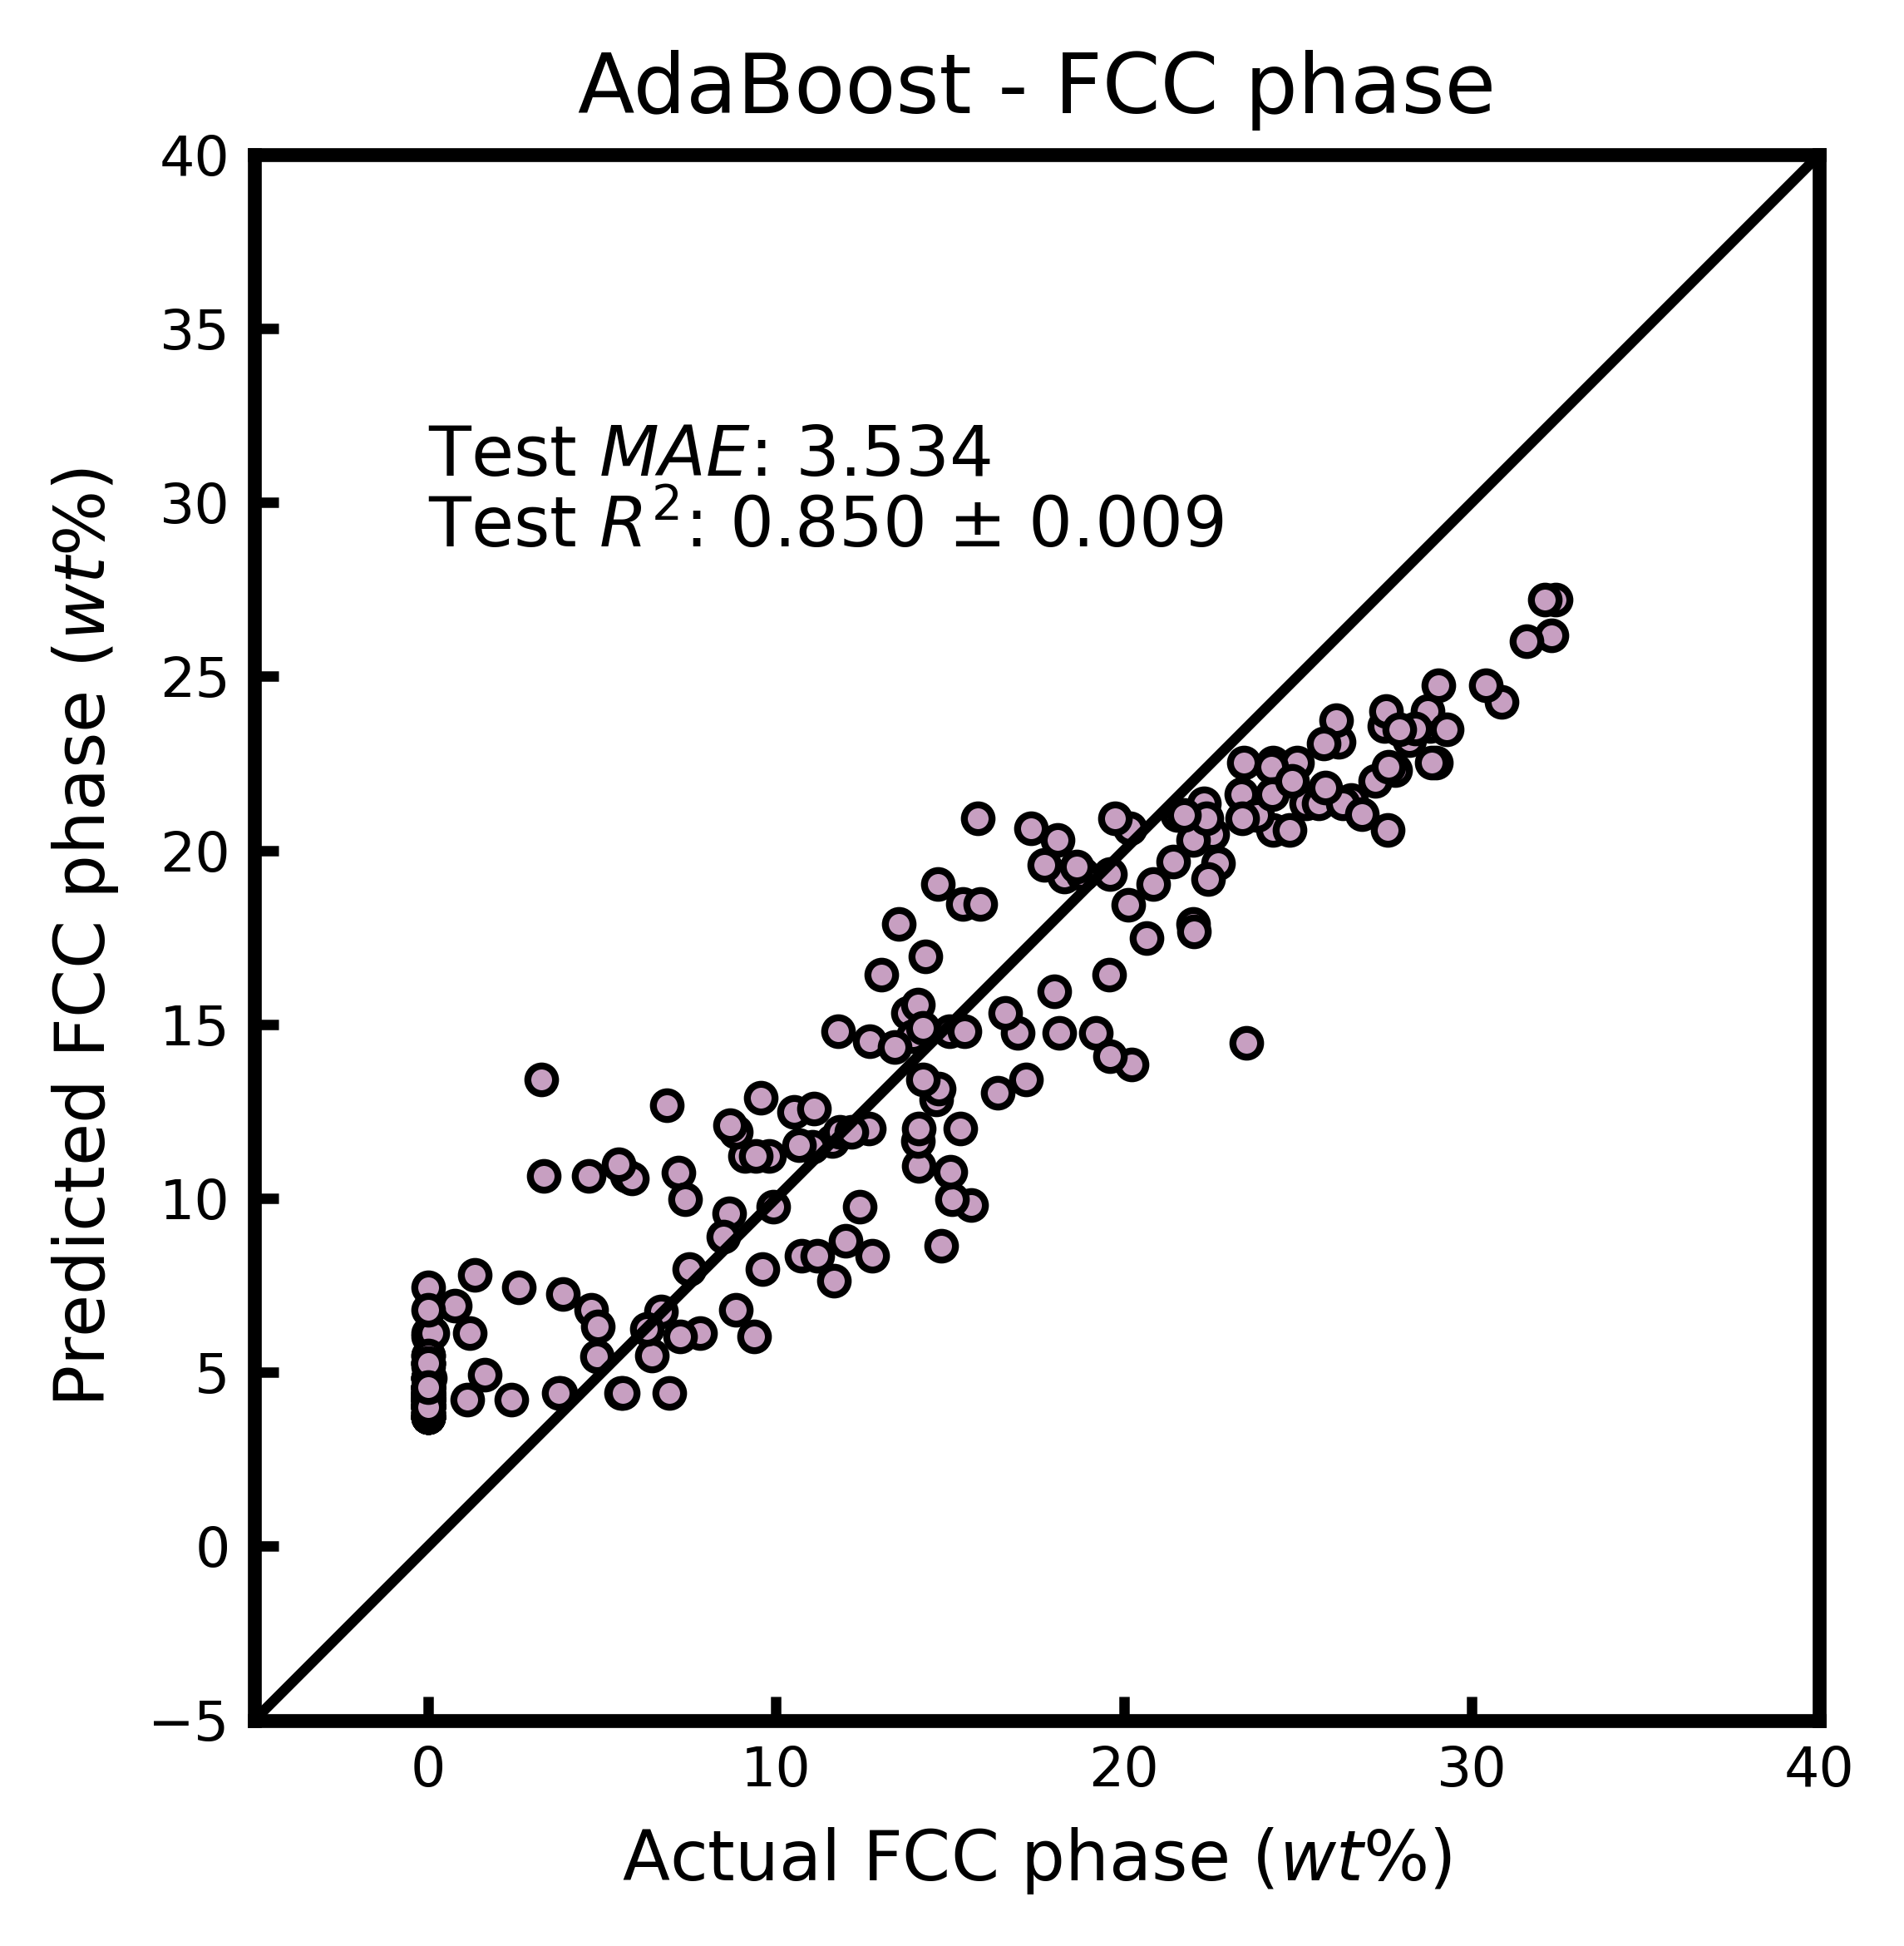

Saving figure FCC phaseDTtest.png


<Figure size 432x288 with 0 Axes>

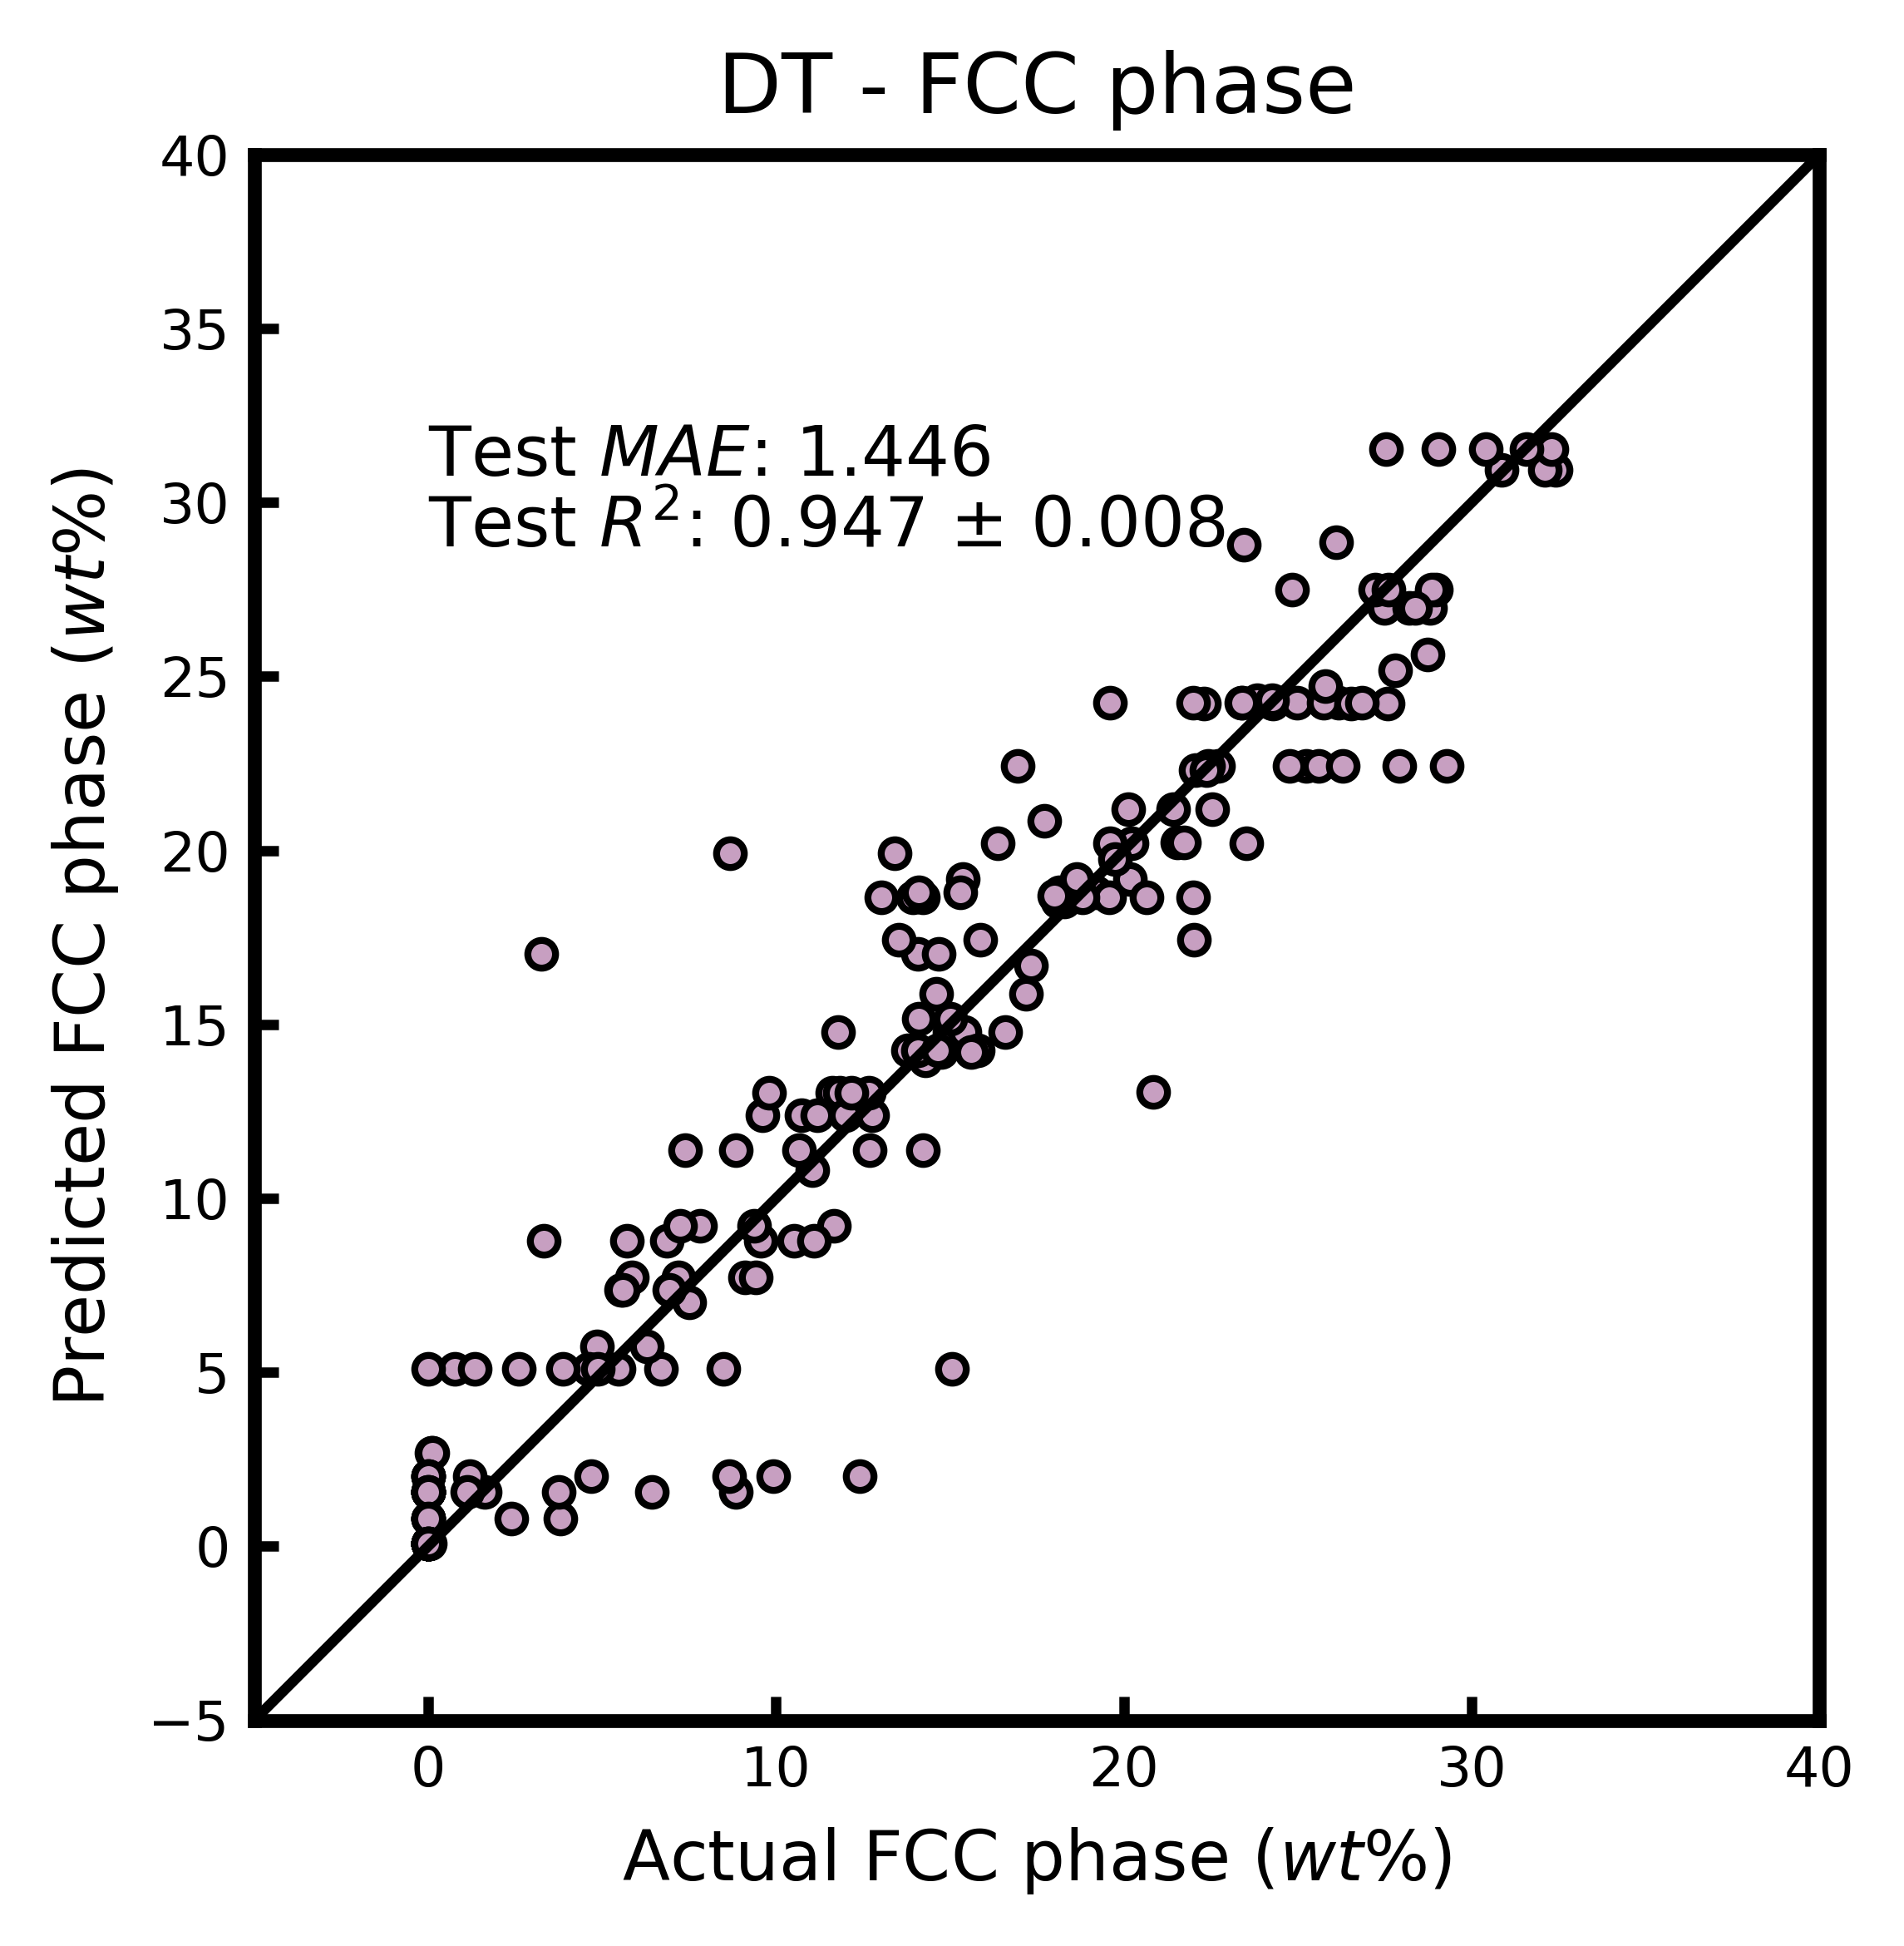

Saving figure FCC phaseRFtest.png


<Figure size 432x288 with 0 Axes>

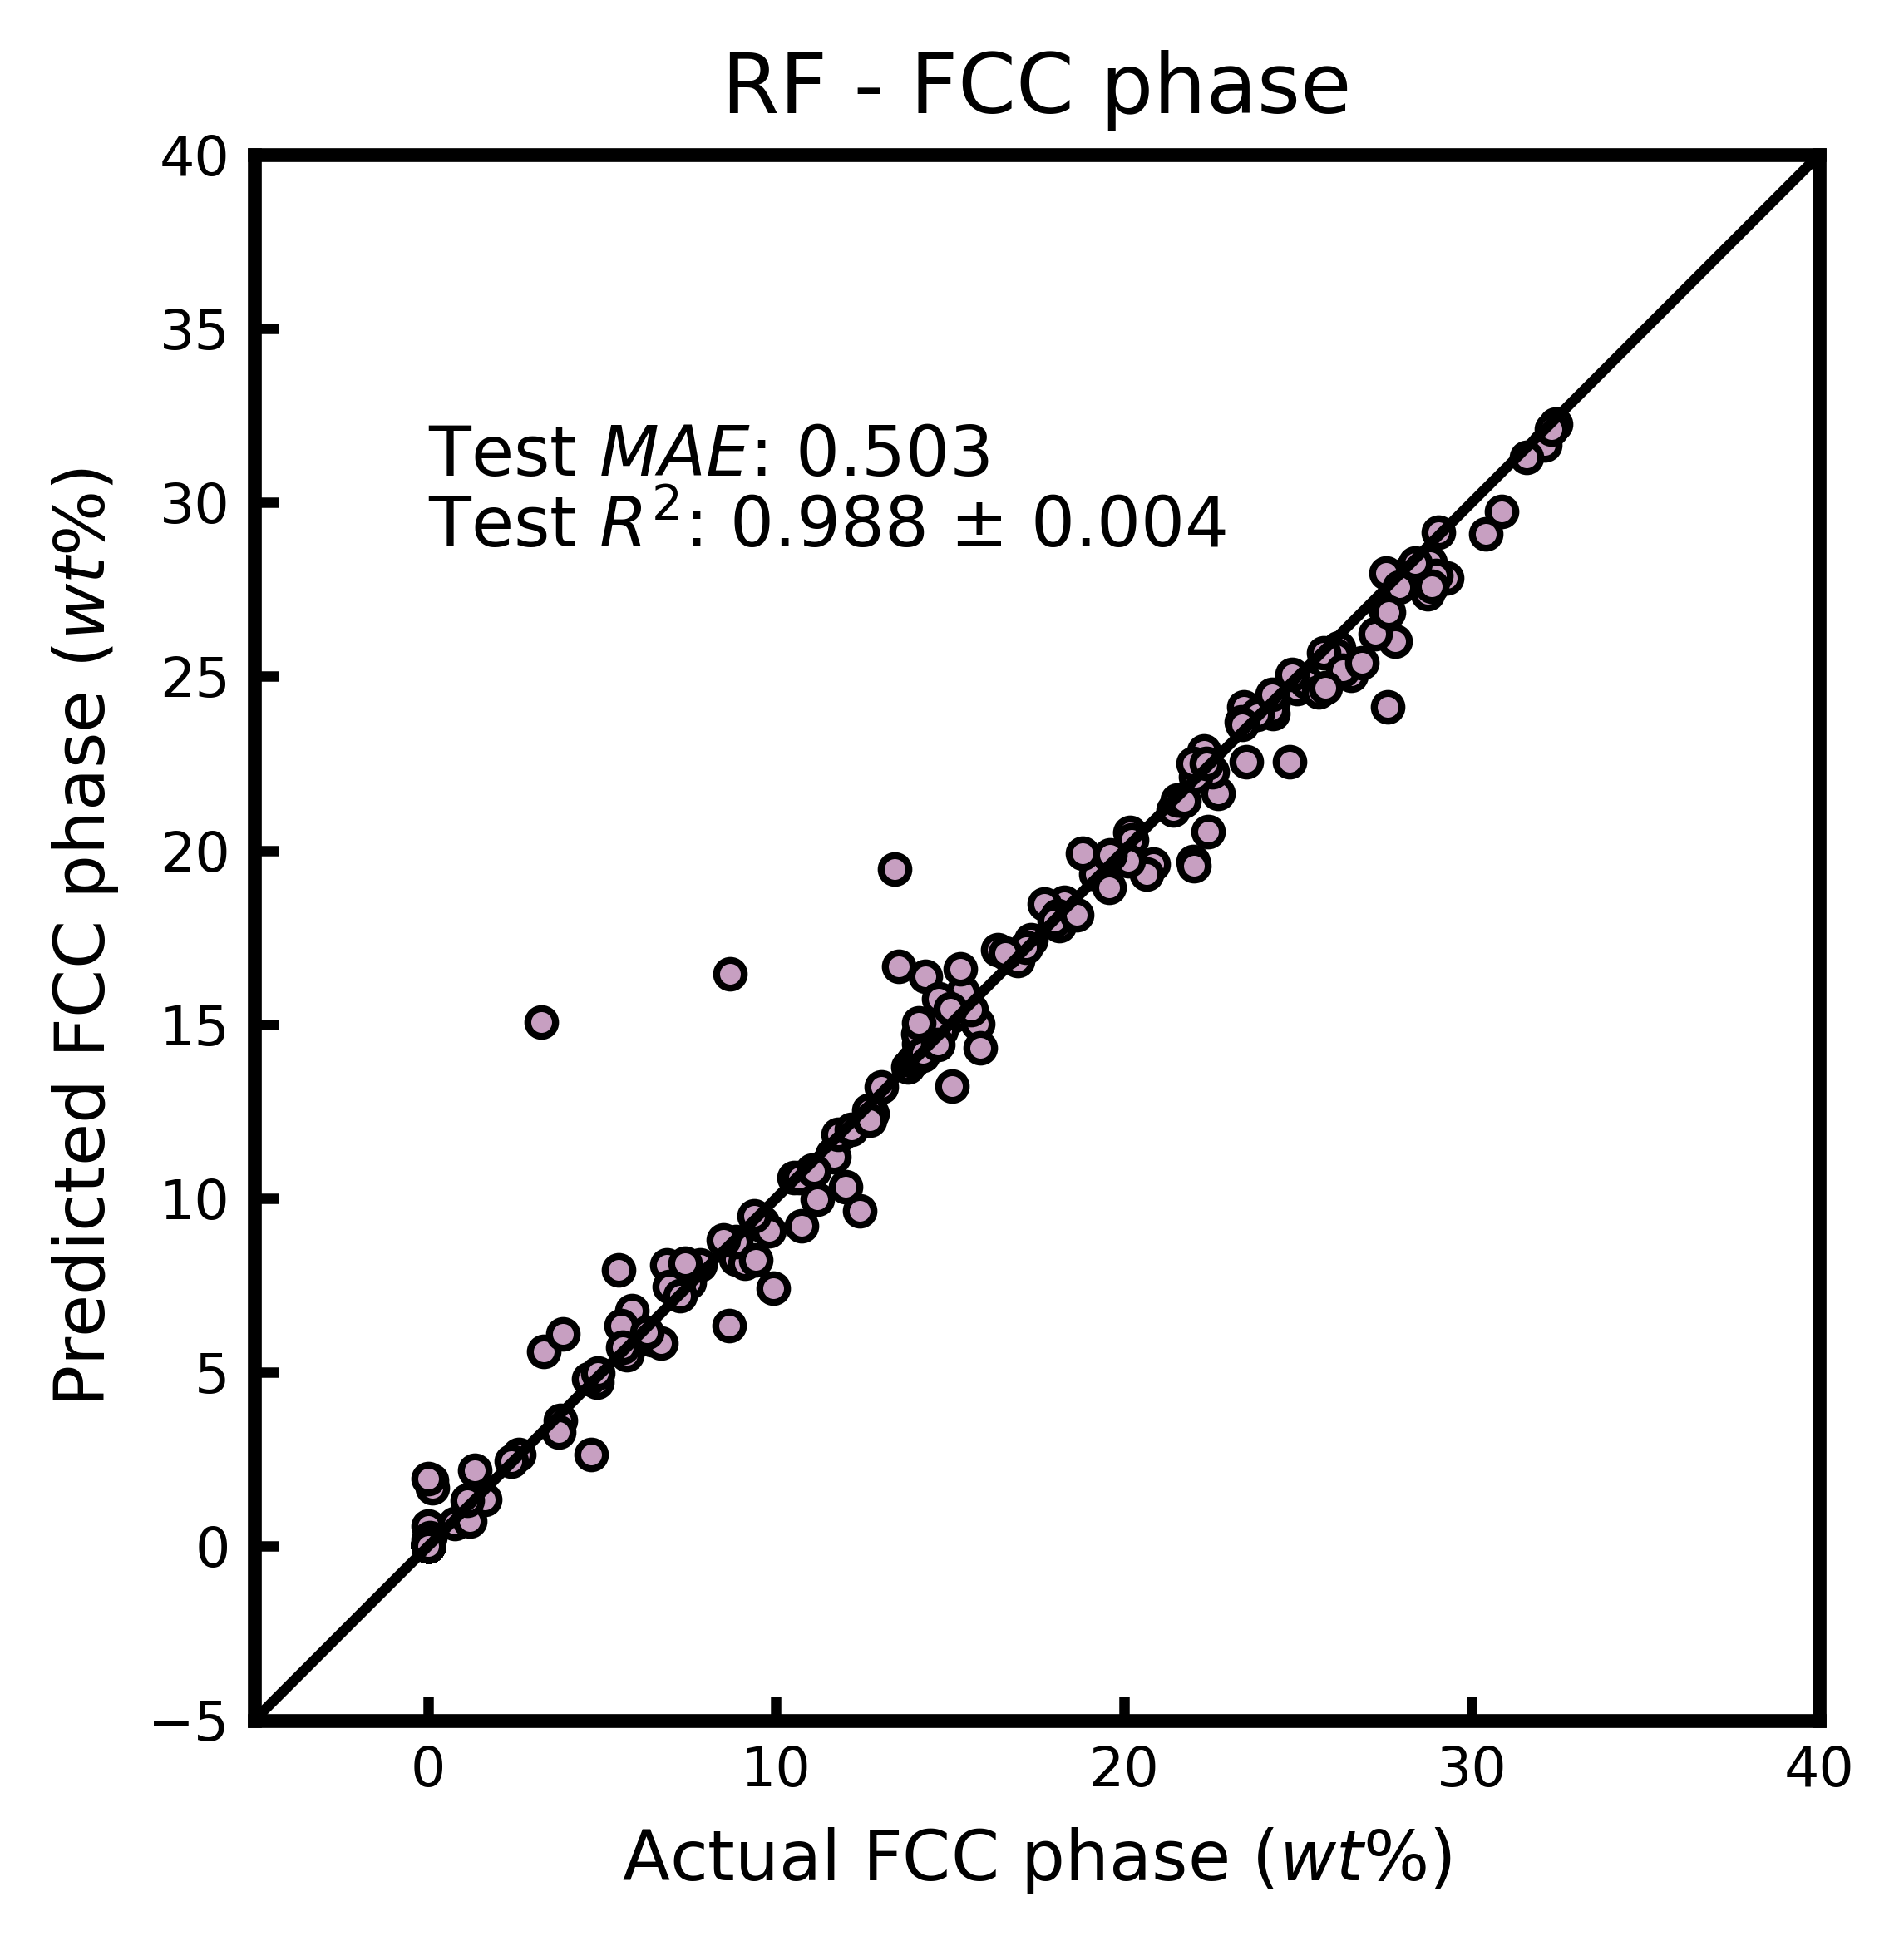

<Figure size 432x288 with 0 Axes>

In [180]:
# Iterate over implemented models
for modeltoggle in ['KNN', 'AdaBoost', 'DT', 'RF']: #'SVR'
    title = "FCC phase"
    X_train = X_FCC_train_transformed
    y_train = Y_FCC_train
    
    if modeltoggle == 'RF':
        model = metamodel_FCC_RF
    elif modeltoggle == 'KNN':
        model = metamodel_FCC_KNN
    elif modeltoggle == 'AdaBoost':
        model = metamodel_FCC_AdaBoost
    elif modeltoggle == 'DT':
        model = metamodel_FCC_DT
        
    # Perform cross validation for each model
    kf = KFold(n_splits=5)
    trains = []
    tests = []
    train_maes = []
    test_maes = []
    # Perform cross validation for each model
    for train, test in kf.split(X_train):

        # Shuffle data points before prediction
        X_shuffle, y_shuffle = shuffle(X_train, y_train, random_state=0)

        X_cv_train = X_shuffle[train]
        X_cv_test = X_shuffle[test]
        y_cv_train = y_shuffle[train]
        y_cv_test = y_shuffle[test]

        model.fit(X_cv_train, y_cv_train)

        # Calculate MAE and R^2

        y_predtrain = model.predict(X_cv_train)
        y_predtest = model.predict(X_cv_test)
        # R^2 score:
        trains.append(model.score(X_cv_train, y_cv_train))
        tests.append(model.score(X_cv_test, y_cv_test))
        
        # MAE score:
        mae_test = metrics.mean_absolute_error(y_cv_test, y_predtest)
        mae_train = metrics.mean_absolute_error(y_cv_train, y_predtrain)
        train_maes.append(mae_train)
        test_maes.append(mae_test)

    # Aggregate information
    trains = np.array(trains)
    tests = np.array(tests)
    train_maes = np.array(train_maes)
    test_maes = np.array(test_maes)
    
    r2_mean = tests.mean()
    r2_std = tests.std()
    r2_train_mean = trains.mean()
    r2_train_std =  trains.std()

    mae_mean_train = train_maes.mean()
    mae_mean_test = test_maes.mean()
    mae_mean_train_std = train_maes.std()
    mae_mean_test_std = test_maes.std()

    FCC_train_accuracy.append(r2_train_mean)
    FCC_train_accuracy_std.append(r2_train_std)
    FCC_test_accuracy_std.append(r2_std)
    FCC_test_accuracy.append(r2_mean)

    FCC_train_mae.append(mae_mean_train)
    FCC_train_mae_std.append(mae_mean_train_std)
    FCC_test_mae.append(mae_mean_test)
    FCC_test_mae_std.append(mae_mean_test_std)
    
    ####### ----------------------------- R^2 plots-----------------------#######
    fig = plt.figure(figsize = (4,4), dpi = 600)
    widths = 2
    ax = gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(widths)

        tick_width = 1.5
    plt.tick_params(direction = 'in', width = tick_width)
    plt.plot(y_cv_test, y_predtest, '.',color='#C79FC1', ms = 8, mec='black', mew = 1)
    plt.plot(np.arange(-4*np.std(y_cv_train)+np.mean(y_cv_train), 4*np.std(y_cv_train)+np.mean(y_cv_train)), 
             np.arange(-4*np.std(y_cv_train)+np.mean(y_cv_train),4*np.std(y_cv_train)+np.mean(y_cv_train)), 'k-')
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
    plt.xlim([-5, 40])
    plt.ylim([-5, 40])
    
    plt.title(modeltoggle + " - "+ str(title))
    plt.xlabel("Actual FCC phase $(wt\%)$")
    plt.ylabel("Predicted FCC phase $(wt\%)$")
    s_cv =  'Test $R^2$: {:.3f} ± {:.3f}'.format(r2_mean, r2_std)
    # plt.text(50, 2*np.std(y_cv_train)+np.mean(y_cv_train), s_cv, fontsize=8)
    plt.text(0, 1.8*np.std(y_cv_train)+np.mean(y_cv_train), s_cv, fontsize=10)
    s =  'Test $MAE$: {:.3f}'.format(mae_mean_test)
    plt.text(0, 2*np.std(y_cv_train)+np.mean(y_cv_train), s, fontsize=10)
    
    plt.gca().set_aspect('equal')
    # frame_tick()
    save_fig(title+modeltoggle + "test"+".png")
    plt.show()
    plt.clf()

### metamodel_T_Ni3Ti

In [181]:
# fit_models = []
T_Ni3Ti_train_accuracy = []
T_Ni3Ti_train_accuracy_std = []
T_Ni3Ti_test_accuracy = []
T_Ni3Ti_test_accuracy_std = []
T_Ni3Ti_train_mae=[]
T_Ni3Ti_train_mae_std=[]
T_Ni3Ti_test_mae=[]
T_Ni3Ti_test_mae_std=[]

Saving figure Ni3Ti formation temperatureKNNtest.png


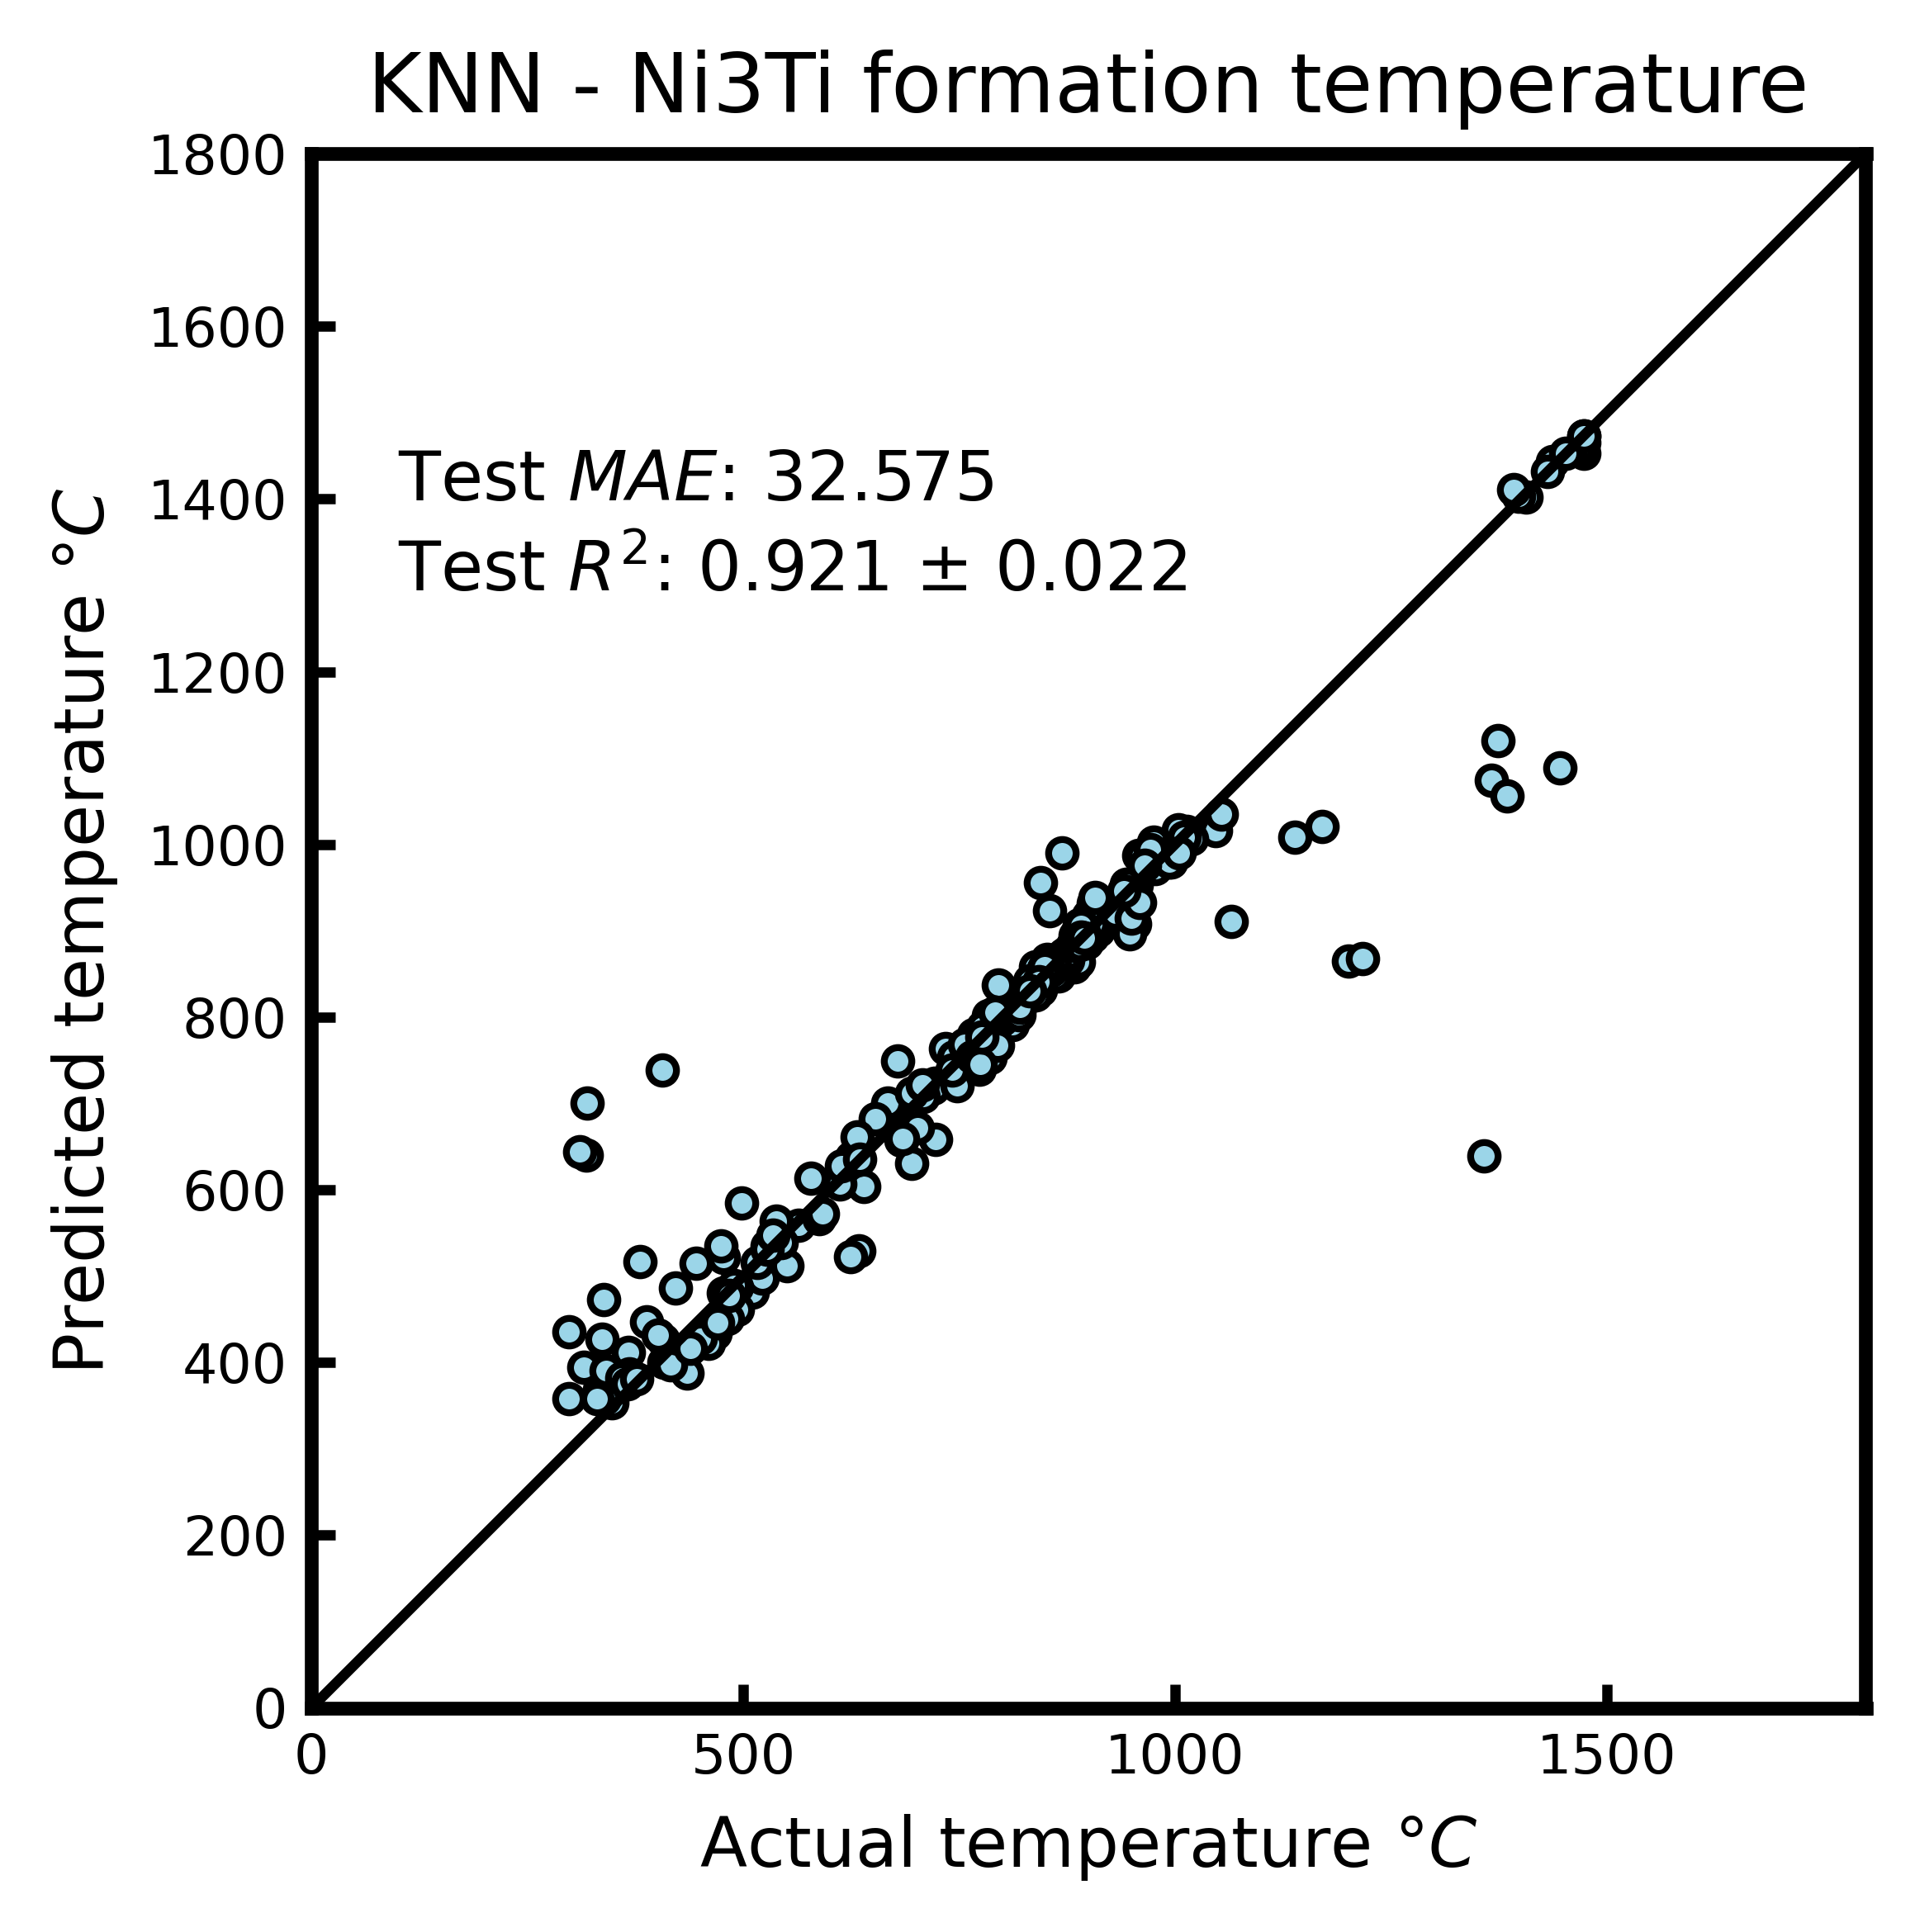

Saving figure Ni3Ti formation temperatureAdaBoosttest.png


<Figure size 432x288 with 0 Axes>

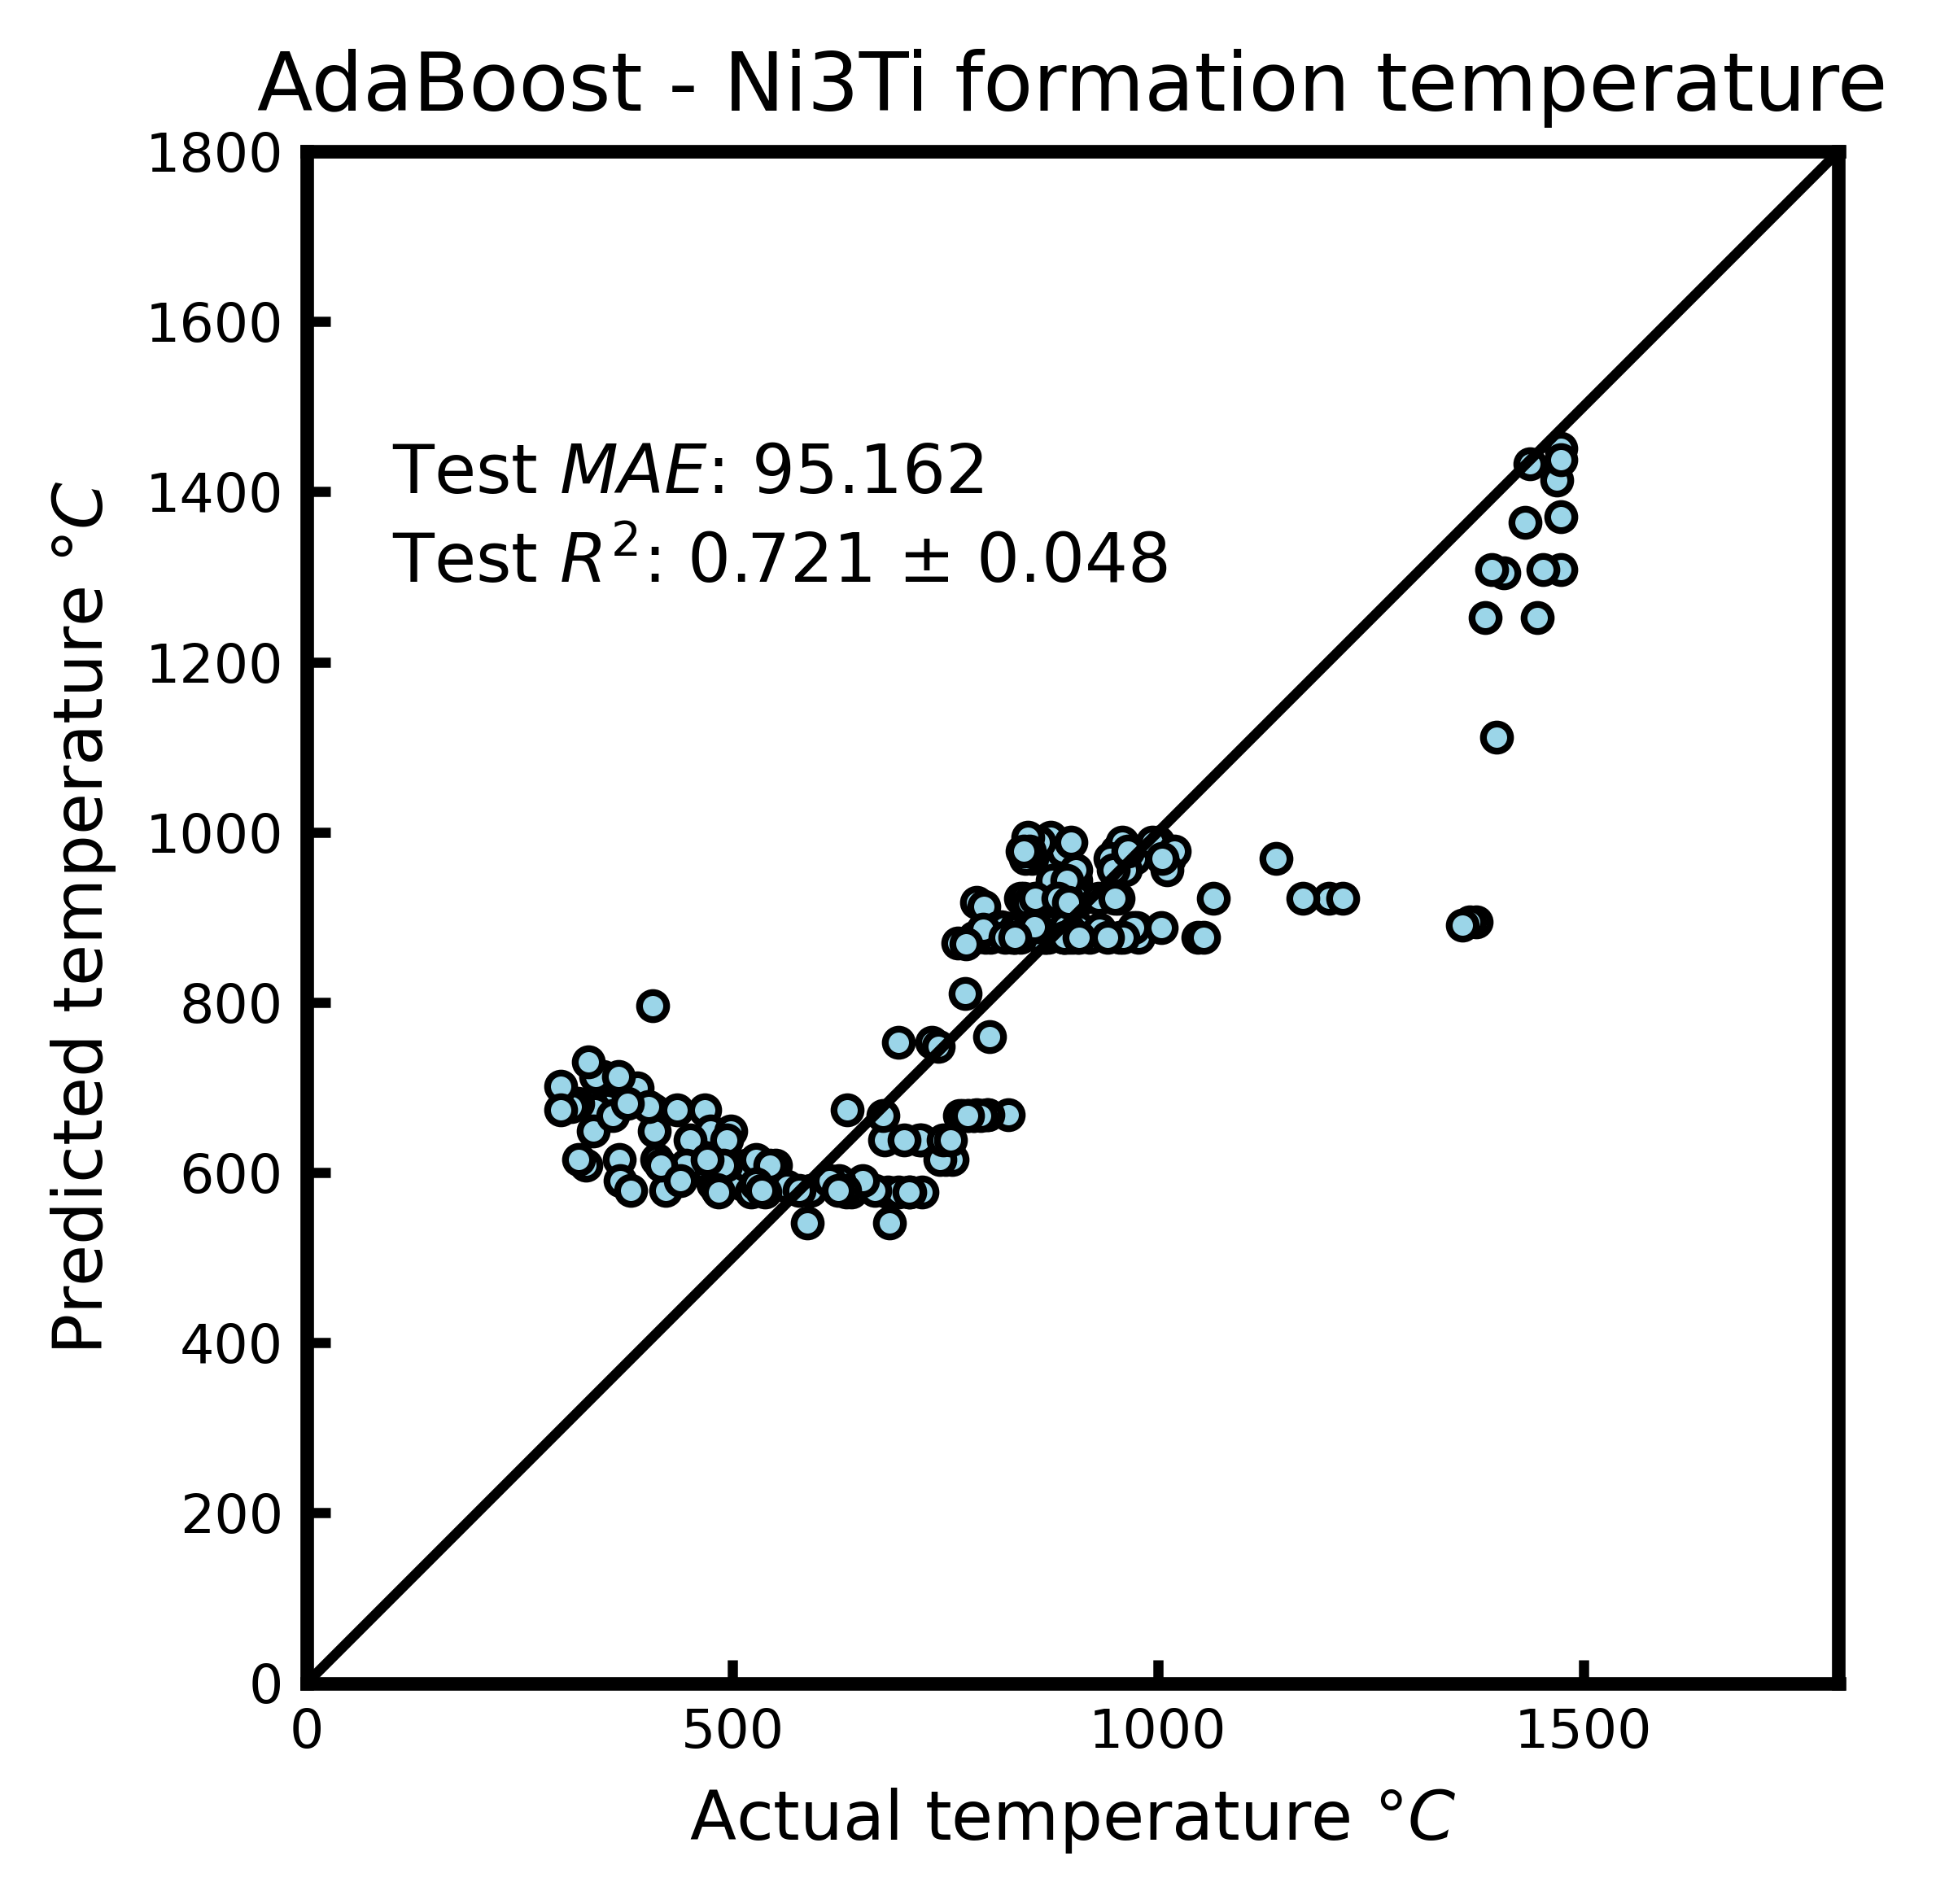

Saving figure Ni3Ti formation temperatureDTtest.png


<Figure size 432x288 with 0 Axes>

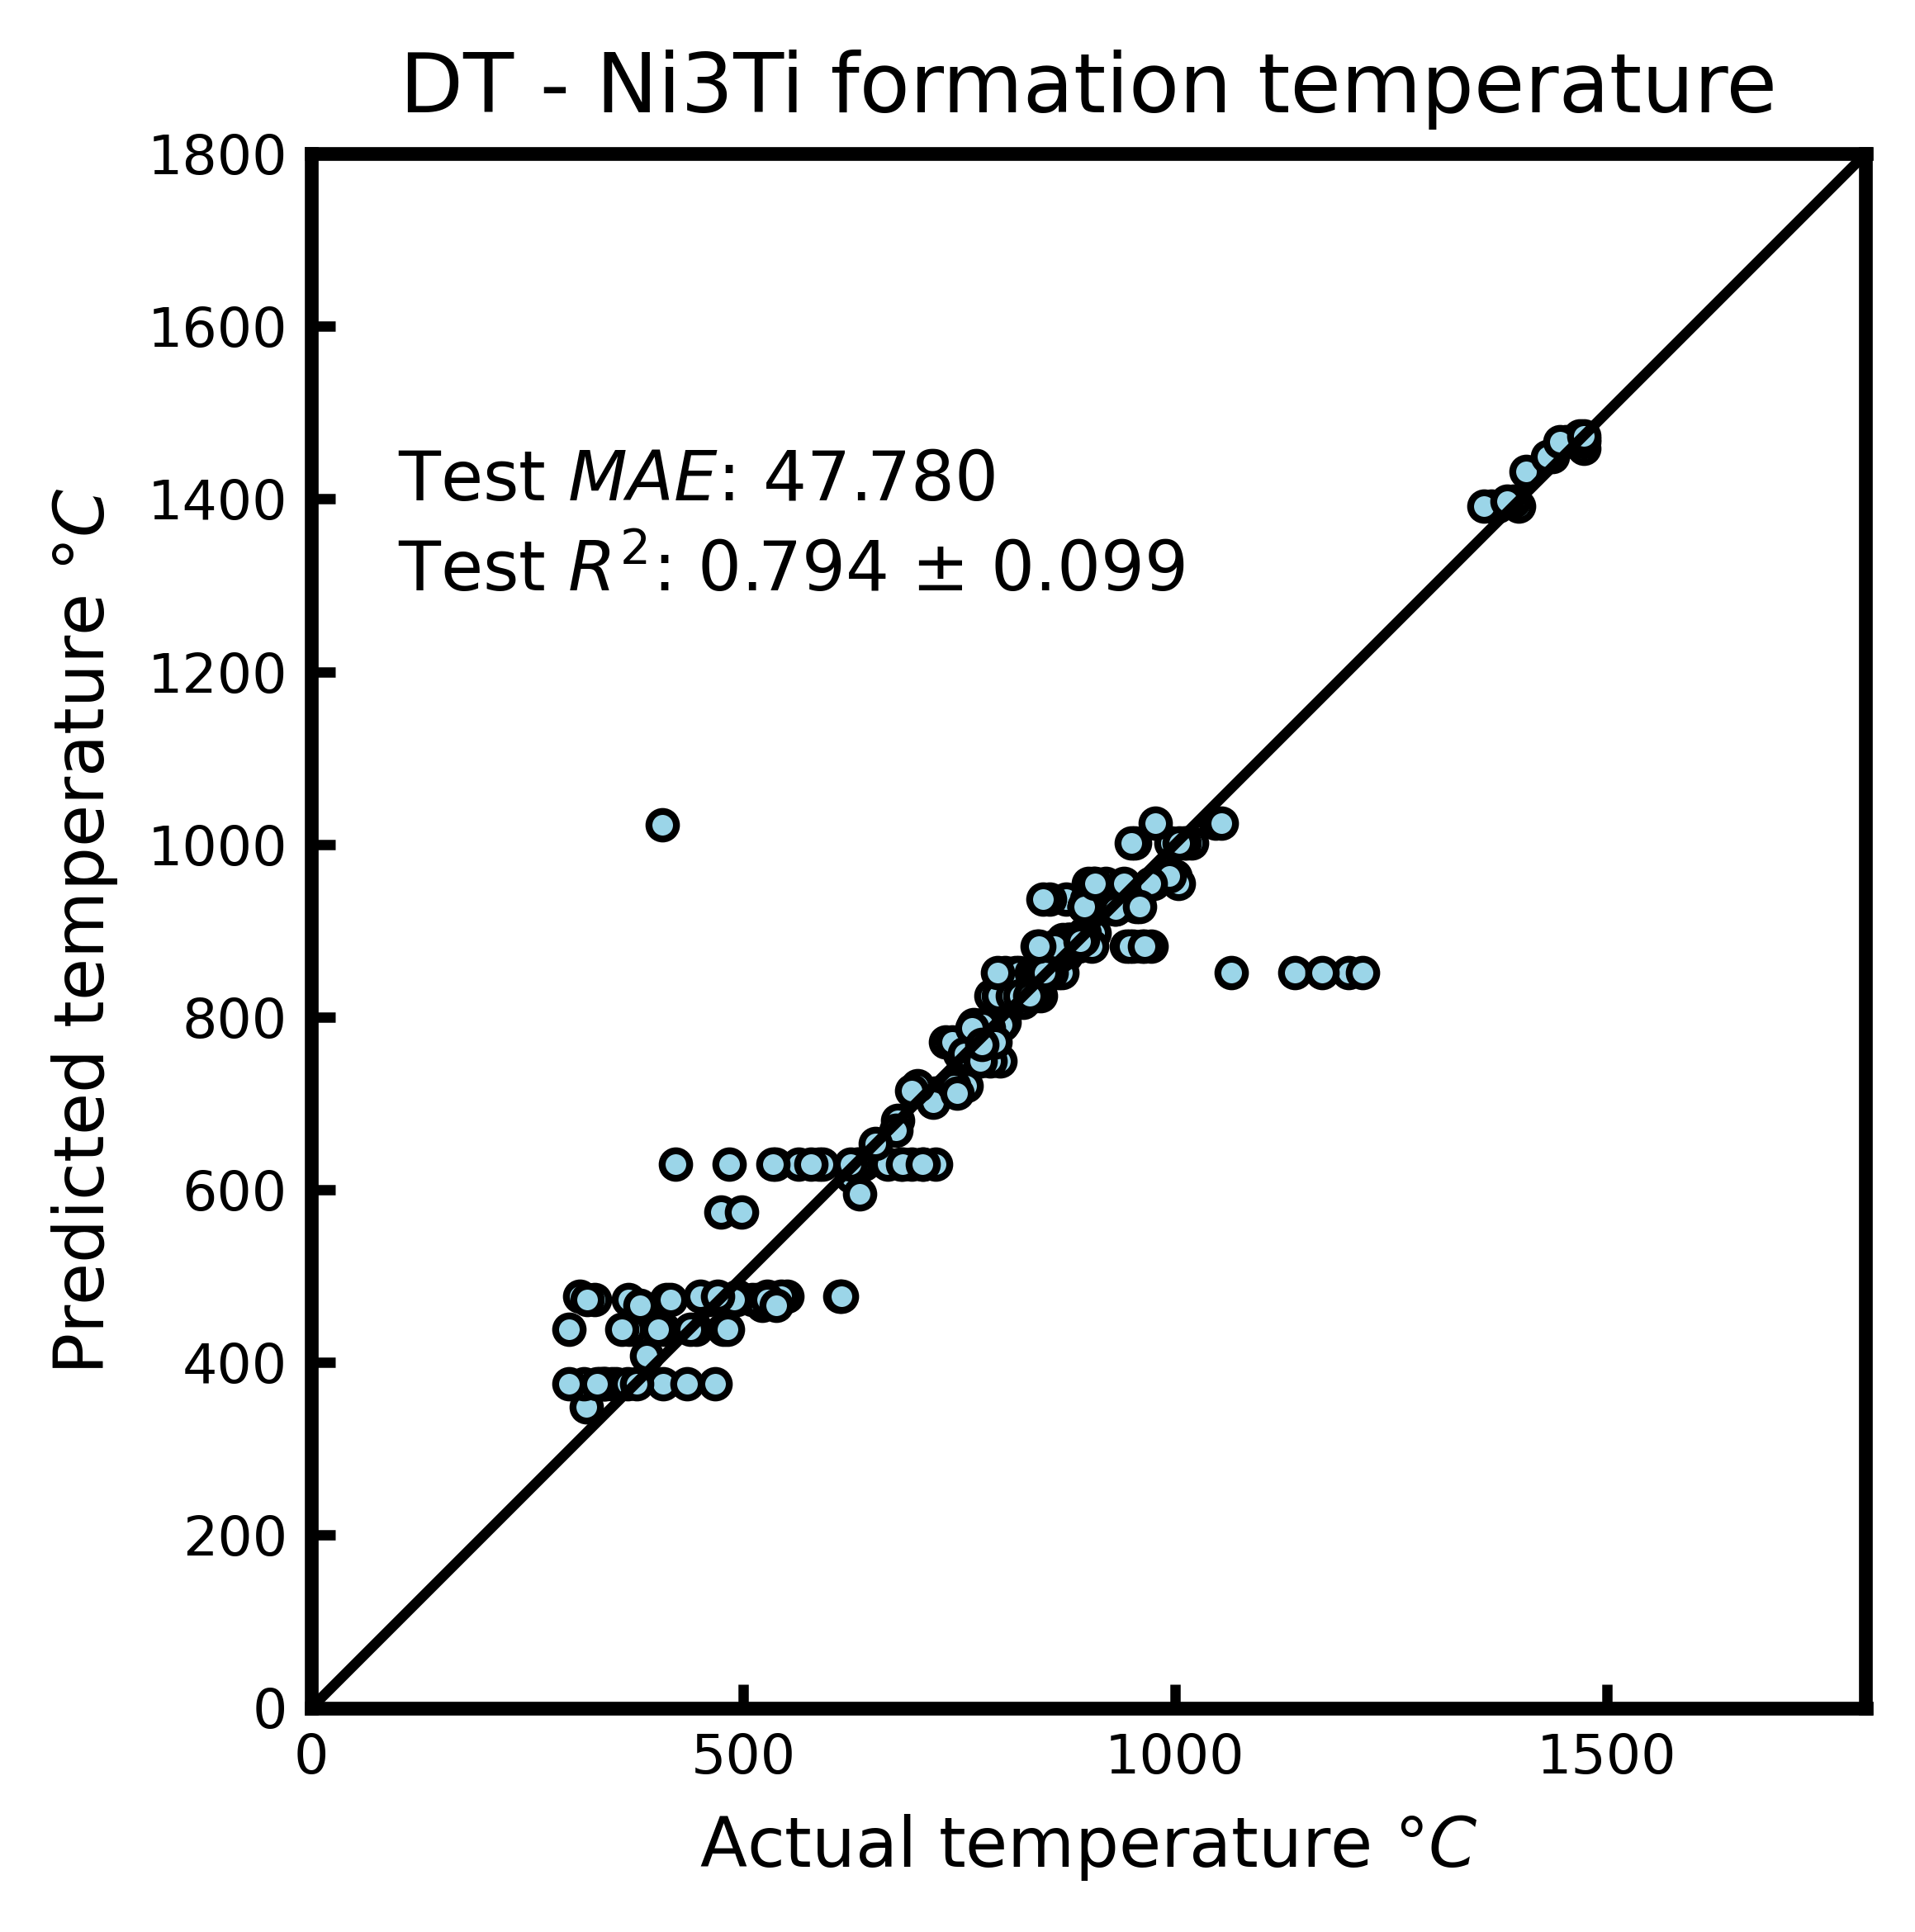

Saving figure Ni3Ti formation temperatureRFtest.png


<Figure size 432x288 with 0 Axes>

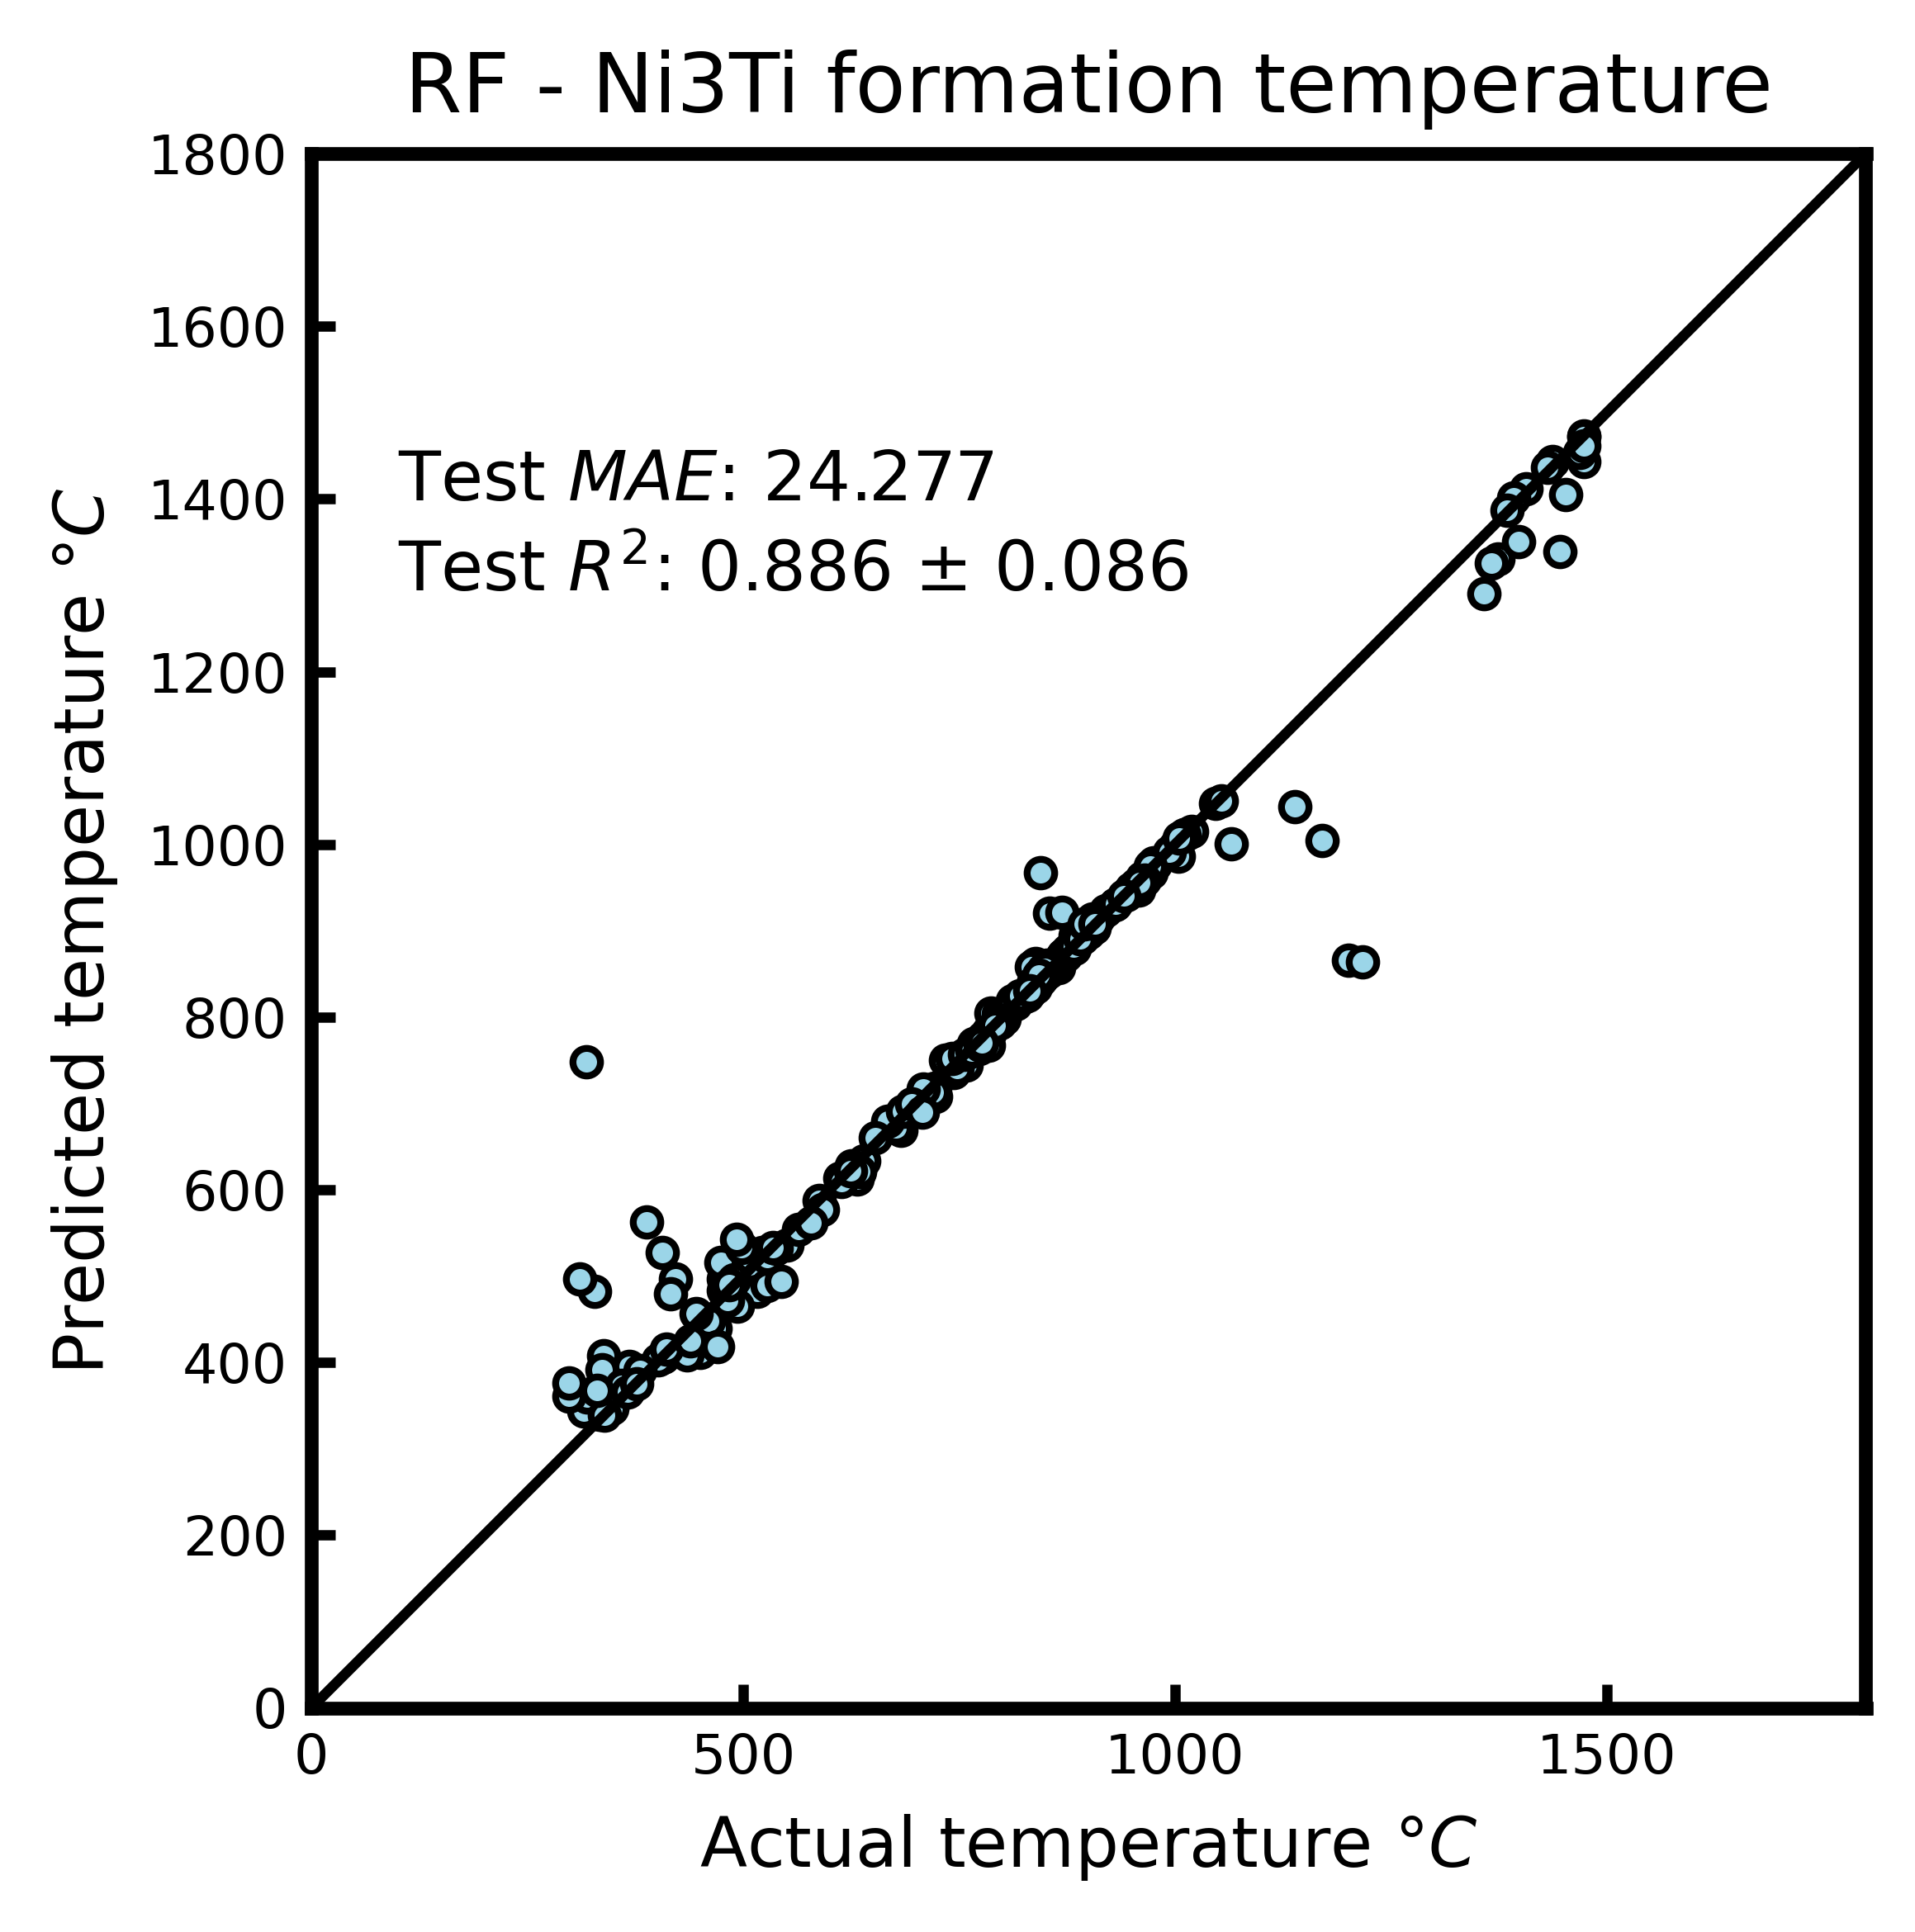

<Figure size 432x288 with 0 Axes>

In [182]:
# Iterate over implemented models
for modeltoggle in ['KNN', 'AdaBoost', 'DT', 'RF']: #'SVR'
    title = "Ni3Ti formation temperature"
    X_train = X_T_Ni3Ti_train_transformed
    y_train = Y_T_Ni3Ti_train
    
    if modeltoggle == 'RF':
        model = metamodel_T_Ni3Ti_RF
    elif modeltoggle == 'KNN':
        model = metamodel_T_Ni3Ti_KNN
    elif modeltoggle == 'AdaBoost':
        model = metamodel_T_Ni3Ti_AdaBoost
    elif modeltoggle == 'DT':
        model = metamodel_T_Ni3Ti_DT
        
    # Perform cross validation for each model
    kf = KFold(n_splits=5)
    trains = []
    tests = []
    train_maes = []
    test_maes = []
    # Perform cross validation for each model
    for train, test in kf.split(X_train):

        # Shuffle data points before prediction
        X_shuffle, y_shuffle = shuffle(X_train, y_train, random_state=0)

        X_cv_train = X_shuffle[train]
        X_cv_test = X_shuffle[test]
        y_cv_train = y_shuffle[train]
        y_cv_test = y_shuffle[test]

        model.fit(X_cv_train, y_cv_train)

        # Calculate MAE and R^2

        y_predtrain = model.predict(X_cv_train)
        y_predtest = model.predict(X_cv_test)
        # R^2 score:
        trains.append(model.score(X_cv_train, y_cv_train))
        tests.append(model.score(X_cv_test, y_cv_test))
        
        # MAE score:
        mae_test = metrics.mean_absolute_error(y_cv_test, y_predtest)
        mae_train = metrics.mean_absolute_error(y_cv_train, y_predtrain)
        train_maes.append(mae_train)
        test_maes.append(mae_test)

    # Aggregate information
    trains = np.array(trains)
    tests = np.array(tests)
    train_maes = np.array(train_maes)
    test_maes = np.array(test_maes)
    
    r2_mean = tests.mean()
    r2_std = tests.std()
    r2_train_mean = trains.mean()
    r2_train_std =  trains.std()

    mae_mean_train = train_maes.mean()
    mae_mean_test = test_maes.mean()
    mae_mean_train_std = train_maes.std()
    mae_mean_test_std = test_maes.std()

    T_Ni3Ti_train_accuracy.append(r2_train_mean)
    T_Ni3Ti_train_accuracy_std.append(r2_train_std)
    T_Ni3Ti_test_accuracy_std.append(r2_std)
    T_Ni3Ti_test_accuracy.append(r2_mean)

    T_Ni3Ti_train_mae.append(mae_mean_train)
    T_Ni3Ti_train_mae_std.append(mae_mean_train_std)
    T_Ni3Ti_test_mae.append(mae_mean_test)
    T_Ni3Ti_test_mae_std.append(mae_mean_test_std)
    
    ####### ----------------------------- R^2 plots-----------------------#######
    fig = plt.figure(figsize = (4,4), dpi = 600)
    widths = 2
    ax = gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(widths)

        tick_width = 1.5
    plt.tick_params(direction = 'in', width = tick_width)
    plt.plot(y_cv_test, y_predtest, '.',color='#9BD5E8', ms = 8, mec='black', mew = 1)
    plt.plot(np.arange(-4*np.std(y_cv_train)+np.mean(y_cv_train), 4*np.std(y_cv_train)+np.mean(y_cv_train)), 
             np.arange(-4*np.std(y_cv_train)+np.mean(y_cv_train),4*np.std(y_cv_train)+np.mean(y_cv_train)), 'k-')
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
    plt.xlim([0, 1800])
    plt.ylim([0, 1800])
    
    plt.title(modeltoggle + " - "+ str(title))
    plt.xlabel("Actual temperature $°C$")
    plt.ylabel("Predicted temperature $°C$")
    s_cv =  'Test $R^2$: {:.3f} ± {:.3f}'.format(r2_mean, r2_std)
    plt.text(100, 1.8*np.std(y_cv_train)+np.mean(y_cv_train), s_cv, fontsize=10)
    s =  'Test $MAE$: {:.3f}'.format(mae_mean_test)
    plt.text(100, 2.2*np.std(y_cv_train)+np.mean(y_cv_train), s, fontsize=10)
    
    plt.gca().set_aspect('equal')
    # frame_tick()
    save_fig(title+modeltoggle + "test"+".png")
    plt.show()
    plt.clf()


In [183]:
T_Ni3Ti_train_accuracy

[1.0, 0.7953820966108708, 0.9252061649074781, 0.9896010523878027]

### Comparisons of the model R2 accuracy, MSE

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (16,).

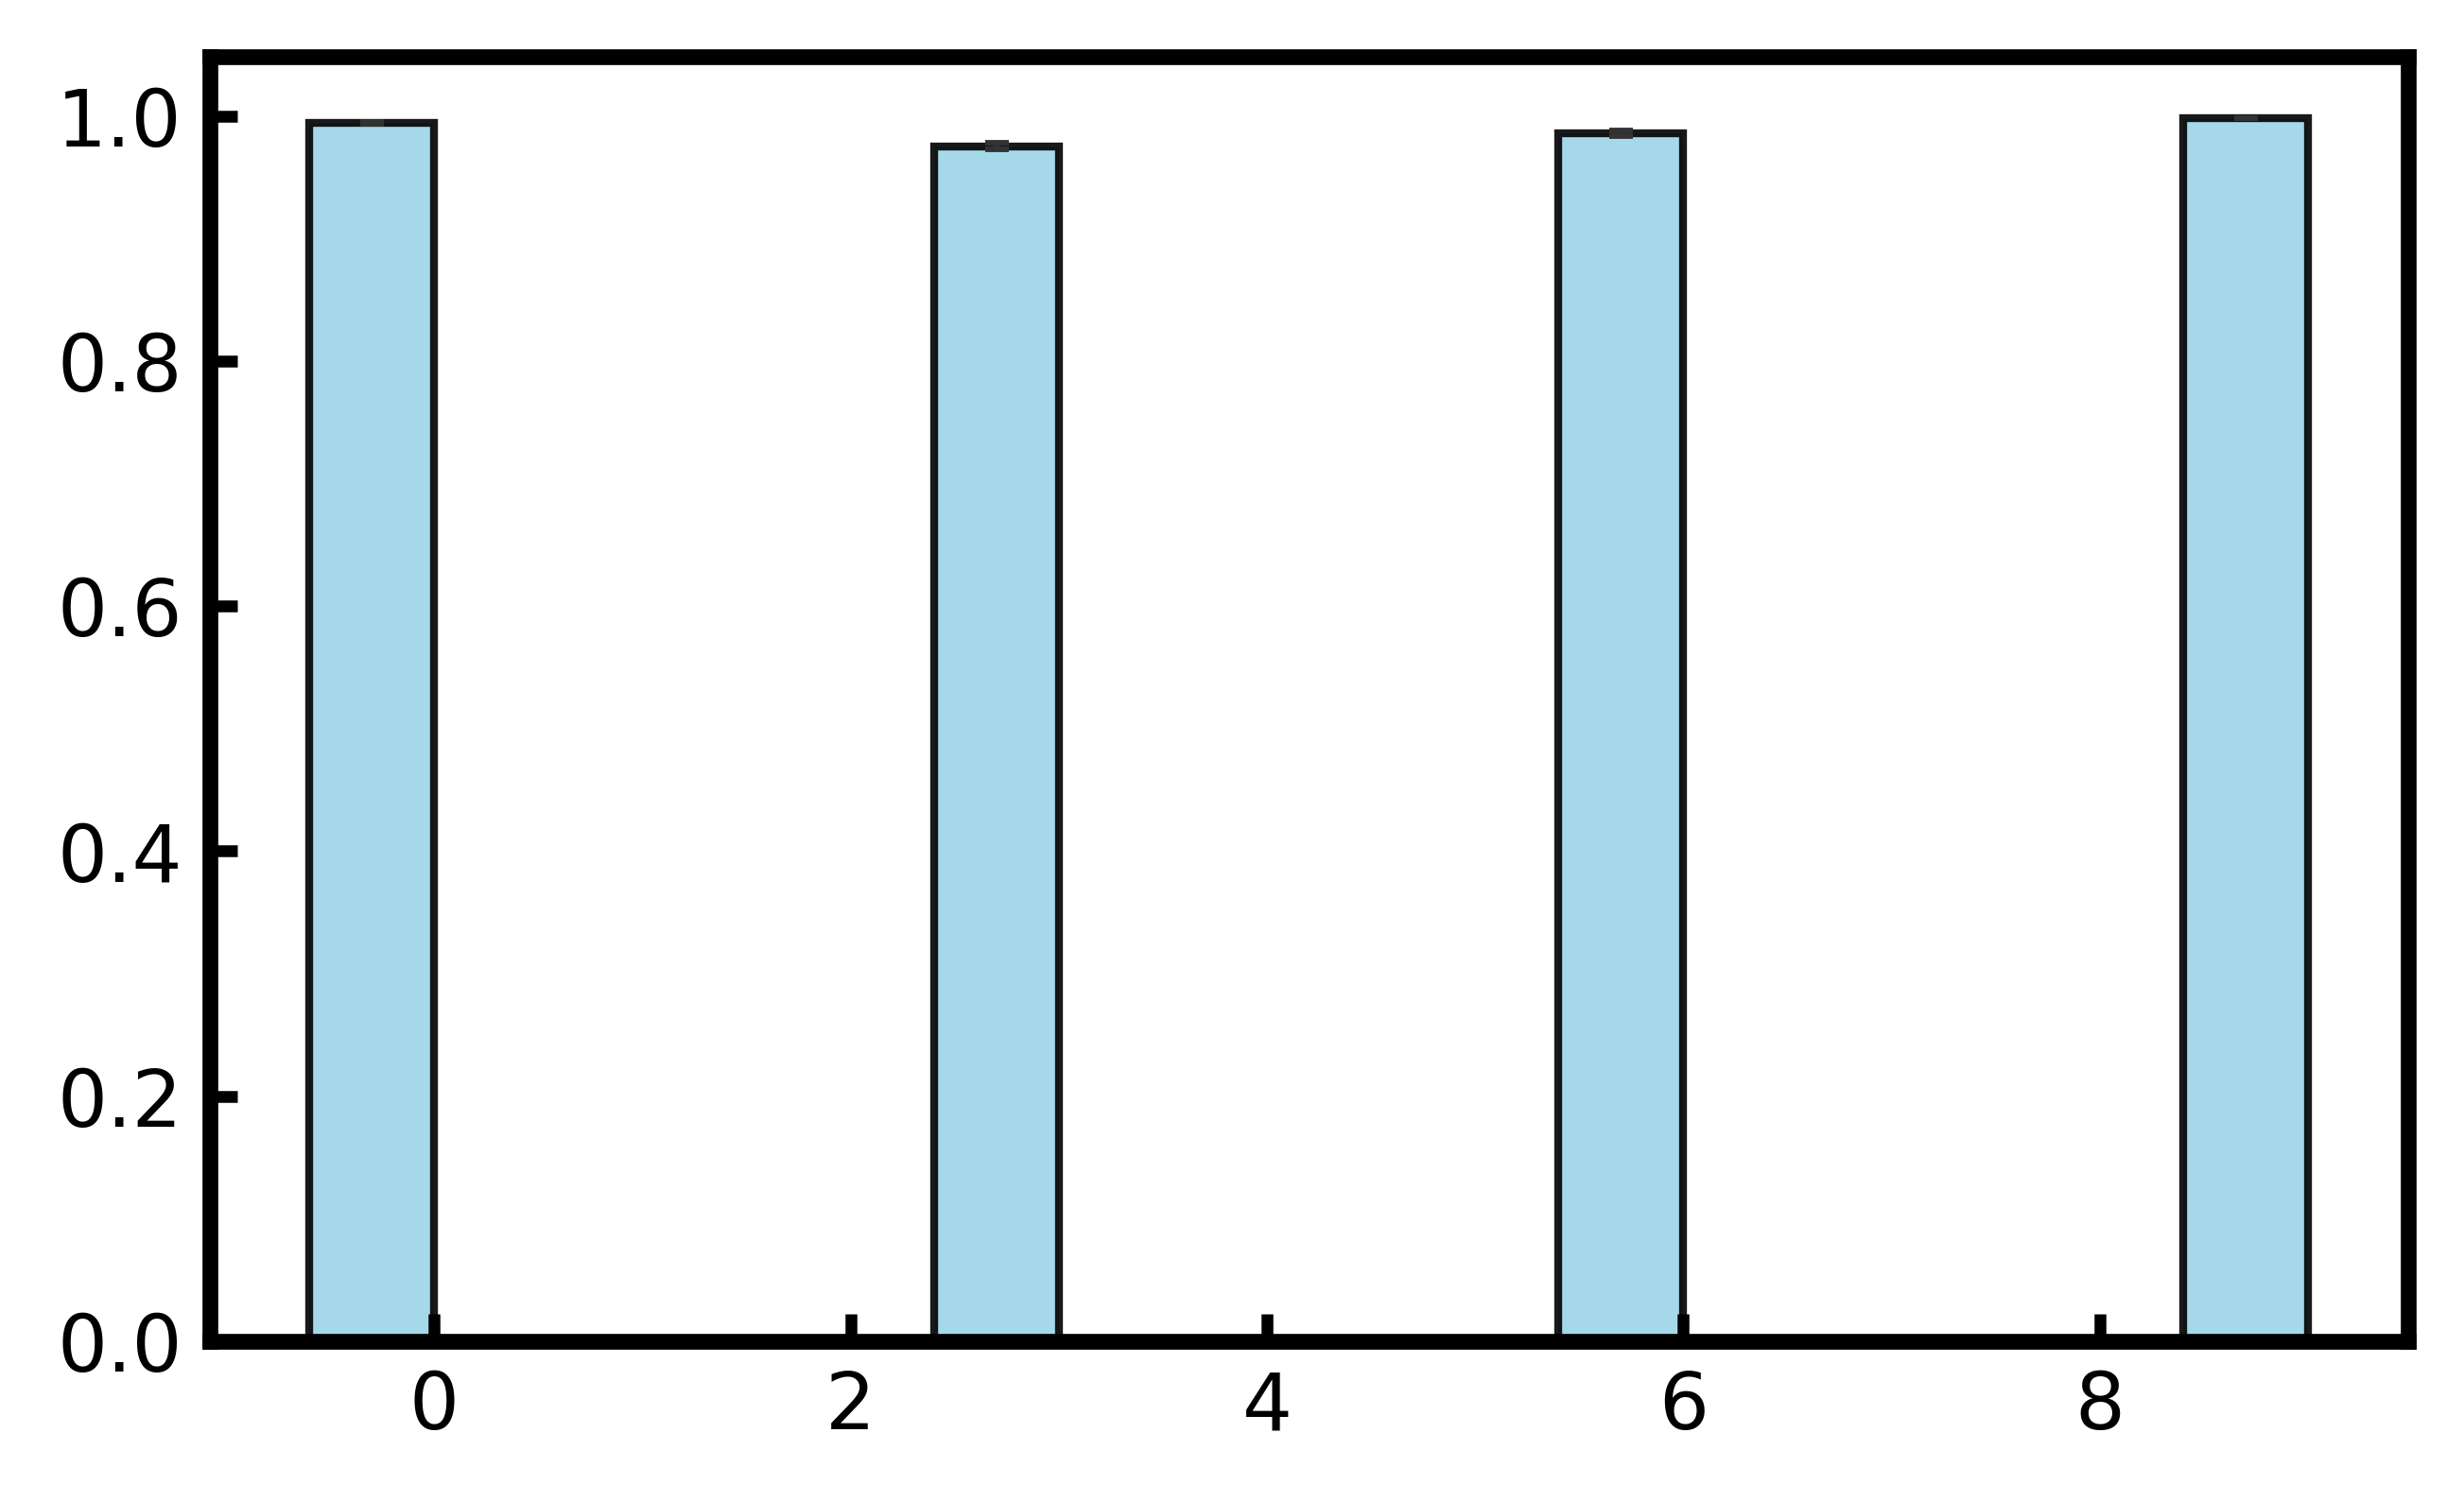

In [185]:
models = ['KNN', 'AdaBoost', 'DT', 'RF']


x = np.arange(len(models))  # the label locations
width = 0.6 # the width of the bars

fig, ax = plt.subplots(figsize = (5,3), dpi = 600)
widths = 2
ax = gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(widths)

    tick_width = 1.5
plt.tick_params(direction = 'in', width = tick_width)

# rects1 = ax.bar(3*x - 1.5*width, T_Ni3Ti_test_accuracy, width, yerr = T_Ni3Ti_test_accuracy_std , 
#                 error_kw = dict(ecolor= '0.2', lw=0.9, capsize=1.5, capthick=0.7), label='T_Ni3Ti', edgecolor ='black', color = '#9BD5E8', alpha =1 ) #F57F5C, midnightblue
# rects2 = ax.bar(3*x - 0.5*width, FCC_test_accuracy, width, yerr = FCC_test_accuracy_std , 
#                 error_kw = dict(ecolor= '0.2', lw=0.9, capsize=1.5, capthick=0.7),label='FCC', edgecolor ='black', color = '#C79FC1', alpha = 0.9) # 9BD5E8, red， #9BD5E8
rects3 = ax.bar(3*x -0.5*width, Laves_test_accuracy, width, yerr = Laves_test_accuracy_std , 
                error_kw = dict(ecolor= '0.2', lw=0.9, capsize=1.5, capthick=0.7),label='Laves phase', edgecolor ='black', color = '#9BD5E8', alpha = 0.9) # 92BEA7, steelblue
rects4 = ax.bar(3*x +0.5*width, Ni3Ti_test_accuracy, width, yerr = Ni3Ti_test_accuracy_std , 
                error_kw = dict(ecolor= '0.2', lw=0.9, capsize=1.5, capthick=0.7),label='Ni3Ti precipitate', edgecolor ='black', color = '#F57F5C', alpha = 0.9) #olive # C79FC1, DFABB9, #C79FC1

# r'$\sin (x)$'
ax.set_ylabel(r'$R^2$ score')
#ax.set_title('depth regression task, test set accuracy')
ax.set_xticks(3*x)
ax.set_xticklabels(models)
ax.set_ylim([0, 1.02])
# plt.legend(loc = 'best',  fontsize = '7', framealpha = 0.4)
plt.legend(loc = 'lower left',  fontsize = '8', framealpha = 0.4, bbox_to_anchor=(0.67, 1)) 
fig.tight_layout()
# plt.show()
save_fig("accuracy_summary_v2")

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (16,).

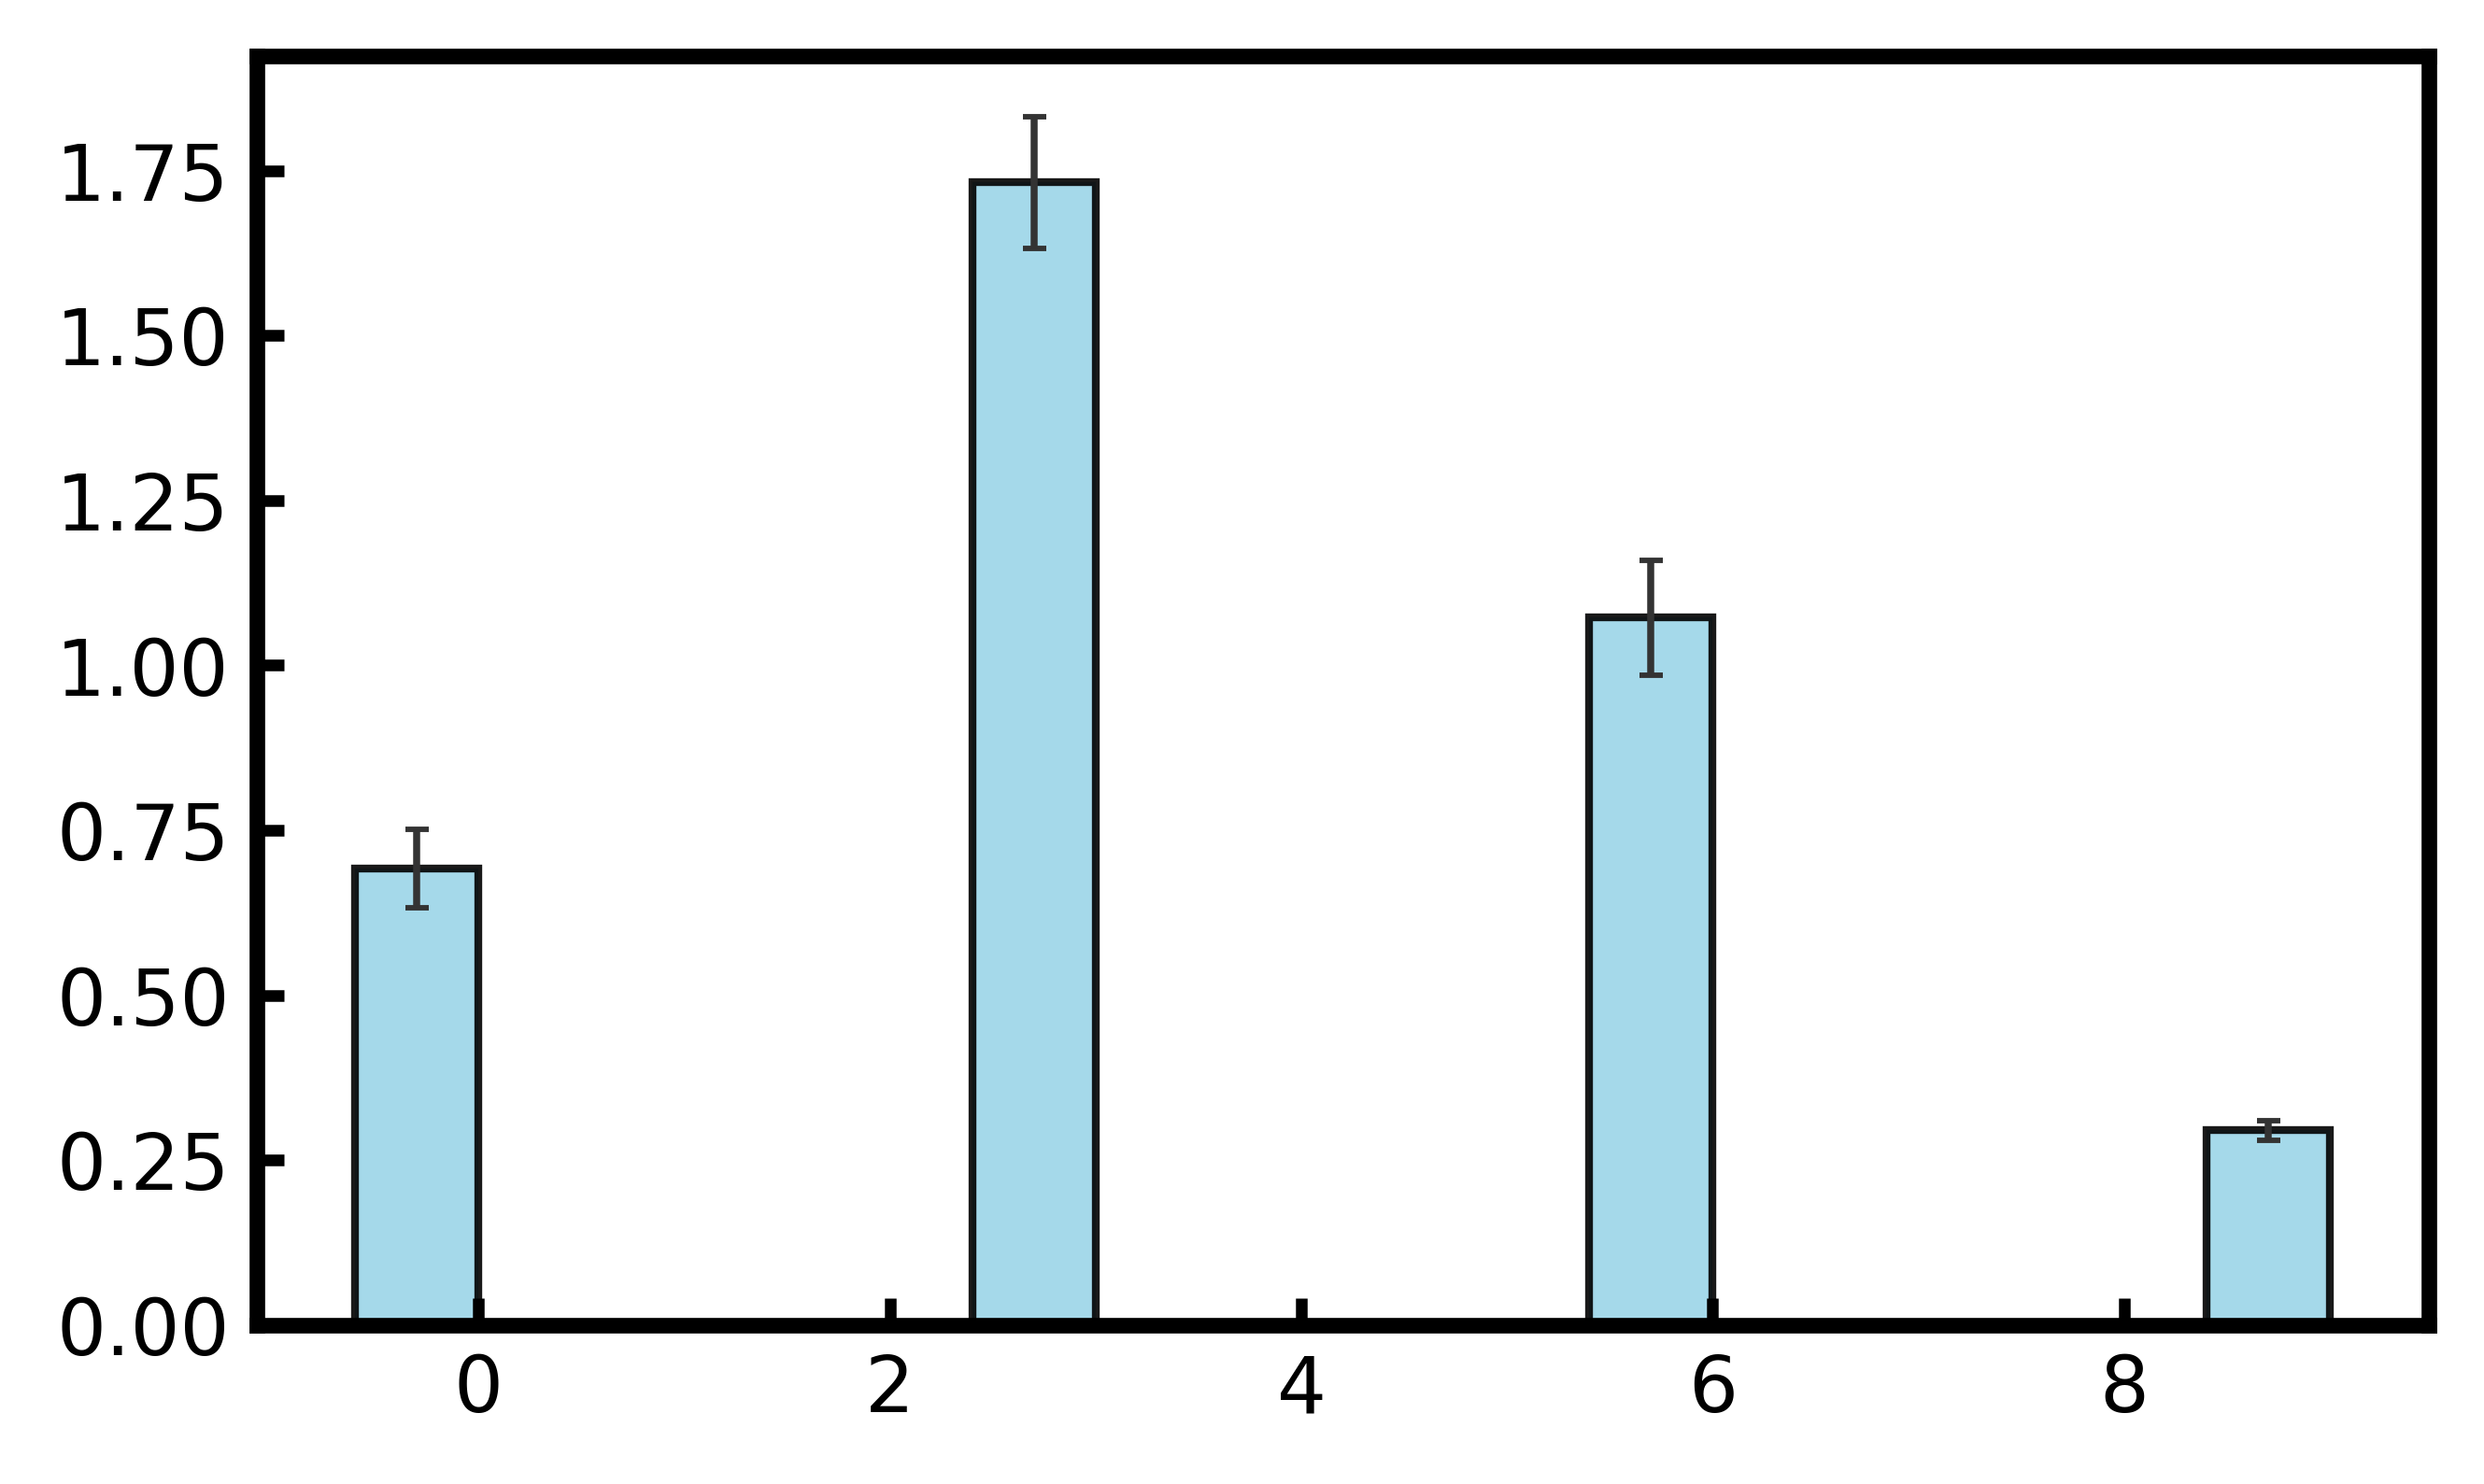

In [187]:
models = ['KNN', 'AdaBoost', 'DT', 'RF']


x = np.arange(len(models))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots(figsize = (5,3), dpi = 600)
widths = 2
ax = gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(widths)

    tick_width = 1.5
plt.tick_params(direction = 'in', width = tick_width)

# rects1 = ax.bar(3*x - 1.5*width, T_Ni3Ti_test_mae, width, yerr = T_Ni3Ti_test_mae_std , 
#                 error_kw = dict(ecolor= '0.2', lw=0.9, capsize=1.5, capthick=0.7), label='T_Ni3Ti', edgecolor ='black', color = '#9BD5E8', alpha =1 ) #F57F5C, midnightblue
# rects2 = ax.bar(3*x - 0.5*width, FCC_test_mae, width, yerr = FCC_test_mae_std , 
#                 error_kw = dict(ecolor= '0.2', lw=0.9, capsize=1.5, capthick=0.7),label='FCC', edgecolor ='black', color = '#C79FC1', alpha = 0.9) # 9BD5E8, red
rects3 = ax.bar(3*x - 0.5*width, Laves_test_mae, width, yerr = Laves_test_mae_std , 
                error_kw = dict(ecolor= '0.2', lw=0.9, capsize=1.5, capthick=0.7),label='Laves phase', edgecolor ='black', color = '#9BD5E8', alpha = 0.9) # 92BEA7, steelblue
rects4 = ax.bar(3*x + 0.5*width, Ni3Ti_test_mae, width, yerr = Ni3Ti_test_mae_std , 
                error_kw = dict(ecolor= '0.2', lw=0.9, capsize=1.5, capthick=0.7),label='Ni3Ti precipitate', edgecolor ='black', color = '#F57F5C', alpha = 0.9) #olive # C79FC1, DFABB9

# r'$\sin (x)$'
ax.set_ylabel('MAE (wt%)')
#ax.set_title('depth regression task, test set accuracy')
ax.set_xticks(3*x)
ax.set_xticklabels(models)
# ax.set_ylim([0, 1.02])
# plt.legend(loc = 'upper right',  fontsize = '8', framealpha = 0.4)
plt.legend(loc = 'lower left',  fontsize = '8', framealpha = 0.4, bbox_to_anchor=(0.68, 1)) 
fig.tight_layout()
# plt.show()
save_fig("mae_summary(characteristic)_v2")

In [186]:
Ni3Ti_test_mae_std

[0.06430801862157724,
 0.11496215876990772,
 0.0731886798326538,
 0.042044222568218374,
 0.06430801862157724,
 0.09384917797273624,
 0.07318867983265402,
 0.0447702043581569,
 0.06430801862157724,
 0.08341186782634018,
 0.07314900989631817,
 0.04594440414960049,
 0.06430801862157724,
 0.09625864562847992,
 0.07318867983265402,
 0.043344674595785136]

In [ ]:
models = ['KNN', 'AdaBoost', 'DT', 'RF']


x = np.arange(len(models))  # the label locations
width = 0.8  # the width of the bars

fig, ax = plt.subplots(figsize = (4,3), dpi = 600)
widths = 2
ax = gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(widths)

    tick_width = 1.5
plt.tick_params(direction = 'in', width = tick_width)

rects1 = ax.bar(3*x , T_Ni3Ti_test_mae, width, yerr = T_Ni3Ti_test_mae_std , 
                error_kw = dict(ecolor= '0.2', lw=0.9, capsize=1.5, capthick=0.7), label='T_Ni3Ti', edgecolor ='black', color = '#9BD5E8', alpha =1 ) #F57F5C, midnightblue
# rects2 = ax.bar(3*x - 0.5*width, FCC_test_mae, width, yerr = FCC_test_mae_std , 
#                 error_kw = dict(ecolor= '0.2', lw=0.9, capsize=1.5, capthick=0.7),label='FCC', edgecolor ='black', color = '#9BD5E8', alpha = 0.9) # 9BD5E8, red
# rects3 = ax.bar(3*x + 0.5*width, Laves_test_mae, width, yerr = Laves_test_mae_std , 
#                 error_kw = dict(ecolor= '0.2', lw=0.9, capsize=1.5, capthick=0.7),label='Laves', edgecolor ='black', color = '#92BEA7', alpha = 0.9) # 92BEA7, steelblue
# rects4 = ax.bar(3*x + 1.5*width, Ni3Ti_test_mae, width, yerr = Ni3Ti_test_mae_std , 
#                 error_kw = dict(ecolor= '0.2', lw=0.9, capsize=1.5, capthick=0.7),label='Ni3Ti', edgecolor ='black', color = '#C79FC1', alpha = 0.9) #olive # C79FC1, DFABB9

# r'$\sin (x)$'
ax.set_ylabel('MAE (°C)')
#ax.set_title('depth regression task, test set accuracy')
ax.set_xticks(3*x)
ax.set_xticklabels(models)
# ax.set_ylim([0, 1.02])
plt.legend(loc = 'upper right',  fontsize = '8', framealpha = 0.4)
# plt.legend(loc = 'lower left',  fontsize = '5.8', framealpha = 0.4, bbox_to_anchor=(1, 0)) 
fig.tight_layout()
# plt.show()
save_fig("mae_summary(Temp)")

## R2 error plots

## Composition design optimization:  single-objective

reference: https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/

In [ ]:
# Use differential evolution:
# Objective function:
def ObjectiveFunction(x, *args):

    # objective function value:
    obj = 0.0 # initialize

    # Decision variables: x = [Ni, Ti, Al]


    # Data standardization (transform the data so that they have a near-normally distribution with zero mean and unit variance)
    # Reference: "Data transformation with held out data" on https://scikit-learn.org/stable/modules/cross_validation.html
    x_transformed = scaler.transform([x])

    # Objective function values:

    ## Only required for Polynomial regression:
    #x_transformed = poly.fit_transform(x_transformed)

    Ni3Ti = metamodel_Ni3Ti_RF.predict(x_transformed)
    Laves = metamodel_Laves_RF.predict(x_transformed)
    FCC = metamodel_FCC_RF.predict(x_transformed)
    T_Ni3Ti = metamodel_T_Ni3Ti_RF.predict(x_transformed)

    # Make sure wt%Laves is less than a max value:
    maxLaves = 5.0
    if Laves > maxLaves:
        #return 1000
        obj += 1000


    # Make sure wt%FCC is within a range:
    # minFCC = 5.0
    # maxFCC = 30.0
    # if FCC < minFCC or FCC > maxFCC:
    #     #return 1000
    #     obj += 1000
    

    # Keep the Ni3Ti formation temperature below a max value:
    # maxT_Ni3Ti = 500.0
    # if T_Ni3Ti > maxT_Ni3Ti:
    #     #return 1000
    #     obj += 1000
    

    # Make sure wt%Al < wt%Ti:
    if x[2] >= x[1]:
        #return 1000
        obj += 1000

    ## Make sure wt%Al >= 1:
    #if x[2] < 1:
        #obj += 1000

    # Objectie function: maximize Ni3Ti, minimize Laves, minimize FCC, maximize T_Ni3Ti:
    # Minimize the positive terms and maximize the negative terms:
    obj += - 1.0 * Ni3Ti / Ni3Ti_upper \
           + 1.0 * Laves / Laves_upper \
           # - 1.0 * T_Ni3Ti / T_Ni3Ti_upper \
           # + 1.0 * (FCC-minFCC) / (FCC_upper-minFCC)


    return obj

In [ ]:
# Bound constraint:  wt% Ni, Ti, Al
bounds = [(18.0, 21.0), (5.0, 10.0), (1, 5.0)]

# Optimization:
# reference: https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/
result = differential_evolution(ObjectiveFunction, bounds, maxiter=100, strategy='rand1bin')

print("\n==========Single objective optimization============")
print('Status : %s' % result['message'])
print("The minimum objective function value is: " + format(result.fun))

print("Optimized composition:")
print("Ni = " + format(result.x[0]) + "wt%")
print("Ti = " + format(result.x[1]) + "wt%")
print("Al = " + format(result.x[2]) + "wt%")

In [ ]:
import numpy as np

def de(fobj, bounds, mut=0.8, crossp=0.7, popsize=20, its=1000):
    dimensions = len(bounds)
    pop = np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    pop_denorm = min_b + pop * diff
    fitness = np.asarray([fobj(ind) for ind in pop_denorm])
    best_idx = np.argmin(fitness)
    best = pop_denorm[best_idx]
    for i in range(its):
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace = False)]
            mutant = np.clip(a + mut * (b - c), 0, 1)
            cross_points = np.random.rand(dimensions) < crossp
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, pop[j])
            trial_denorm = min_b + trial * diff
            f = fobj(trial_denorm)
            if f < fitness[j]:
                fitness[j] = f
                pop[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial_denorm
        yield best, fitness[best_idx]

In [ ]:
# The resultant Ni3Ti, Laves, and FCC wt% at the optimized composition:
x_transformed = scaler.transform([[result.x[0], result.x[1], result.x[2]]])

## Only required for Polynomial regression:
#x_transformed = poly.fit_transform(x_transformed)

print("wt% Ni3Ti = " + format(metamodel_Ni3Ti_RF.predict(x_transformed)))
print("wt% Laves = " + format(metamodel_Laves_RF.predict(x_transformed)))
print("wt% FCC = " + format(metamodel_FCC_RF.predict(x_transformed)))
print("Ni3Ti formation temperature (k) = " + format(metamodel_T_Ni3Ti_KNN.predict(x_transformed)))
print("===================================================\n")

### Composition design: multi-objective optimization

In [ ]:
class MyProblem(Problem):

    def __init__(self):

        super().__init__(n_var = 3,
                         n_obj = 3,
                         xl = np.array([15.0, 1.0, 0.0]),
                         xu = np.array([20.0, 15.0, 10.0]),
                         elementwise_evaluation=True)

    def _evaluate(self, x, out, *args, **kwargs):

        '''
        if "elementwise_evaluation=True" defined in super().__init__:

            x is a 2D numpy array.
            Each row of x is an individual. Total row number is the population size defined in algorithm = NSGA2().
            Total column number is the number of variables
            Decision variables: x = np.array([Ni, Ti, Al],
                                             [Ni, Ti, Al],
                                              ....)
        else (by default, elementwise_evaluation=False):
            x is a 1D numpy array. x = np.array([Ni, Ti, Al])
        '''

        x_transformed = scaler.transform([x])

        # Output of metamodels:

        ## Only required for Polynomial regression:
        #x_transformed = poly.fit_transform(x_transformed)

        Ni3Ti = metamodel_Ni3Ti_RF.predict(x_transformed)
        Laves = metamodel_Laves_RF.predict(x_transformed)
        FCC = metamodel_FCC_RF.predict(x_transformed)


        # Objective function 1: maximize Ni3Ti
        # Minimize the positive terms and maximize the negative terms:
        f1 = - 1.0 * Ni3Ti / Ni3Ti_upper

        # Objective function 2: minimize Laves:
        # Minimize the positive terms and maximize the negative terms:
        f2 =  1.0 * Laves / Laves_upper

        # Objective function 3: minimize FCC:
        # Minimize the positive terms and maximize the negative terms:
        f3 =  1.0 * FCC / FCC_upper

        out["F"] = np.column_stack([f1, f2, f3])

In [ ]:
problem = MyProblem()


algorithm = NSGA2(pop_size = 20,
                  n_offsprings = 20,
                  sampling = get_sampling("real_random"),
                  crossover = get_crossover("real_sbx", prob=0.9, eta=15),
                  mutation = get_mutation("real_pm", eta=20),
                  eliminate_duplicates = True)


termination = get_termination("n_gen", 100)


result = minimize(problem,
                  algorithm,
                  termination,
                  seed=1,
                  pf=problem.pareto_front(use_cache=False),
                  save_history=True,
                  verbose=True)

print("\nThe Pareto optimal design variables:")
print(result.X)  # design variable values
print("\nThe Pareto optimal objective functions:")
print(result.F)  # objective function values

# Plot the Pareto set in 3D scatter plot (3 objectives)
plot = Scatter(title = "Objective Space")
plot.add(result.F)  # objective function values
plot.show()

#plot = Scatter(title = "Design Space")
#plot.add(result.X)  # design variable values
#plot.show()


# Create pandas dataframe of the Pareto optimum, and save to .csv file:
# First, create a dictionary:
Pareto = {"Ni": result.X[:,0], "Ti": result.X[:,1], "Al": result.X[:,2], \
          "f1": result.F[:,0], "f2": result.F[:,1], "f3": result.F[:,2]}
# Then, a pandas data frame:
df_Pareto = DataFrame(Pareto, columns= ["Ni", "Ti", "Al", "f1", "f2", "f3"])
# Save the dataframe in .csv file:
# df_Pareto.to_csv("Pareto_optimum.csv", index=None, header=True)